# App Identification

Investagation 


IMPORTANT: Make sure the data are cached by running cache.py with the path in argument (#TODO)  

<a id='tc'></a>
## Table of content 

**PART I** - Introduction and setup 

0. [Introduction](#intro)
1. [Setup](#setup)
    1. [Imports](#imports)
    2. [helpers](#helpers)
    3. [evaluation function](#evaluation)
    

**PART II** - [model evaluation and Performance](#model_eval_perf)

1. [Banned App](#banned_app)
2. [Dataset size investigation](#dataset_size)
3. [Huawei](#huawei_eval)
4. [Fossil](#fossil_eval)
5. [Apple Watch](#apple_watch)
5. [Action](#actions)
    1. [Foursquare city guide](#Foursquarecityguide)
    2. [DiabetesM](#DiabetesM)
    3. [Endomondo](#Endomondo)
    4. [Lifesum](#lifesum)
    5. [All action within apps](#all_action_within_apps)
6. [All apps and action together](#all)

**PART IV** - [Transferability](#transferability)
 
1. [Train and test with both watches](#huawei_fossil_train_test)
2. [Train and test with both watches with class separation](#huawei_fossil_train_test_class_separation)
3. [Training and testing with different watch respectively](#train_test_different_watch)
    1. [Train with Huawei test with Fossil](#thtf)
    2. [Train with Fossil test with Huawei](#tfth)
4. [Capacity and Transferability](#capa_tr)
    1. [Decrease Number of Features](#decrease_nb_features)
    2. [Increase Model Complexity](#increase_complexity)

**PART IV** - [Impact on time](#acc_time)
8. Separation of dataset by the date at which the capture has been performed

**OTHER** - 
9. [Tranferability apple-huawei](#apple-huawei)




6. Outliers Detections


## PART I - Introduction and Setup

<a id='intro'></a>
## Introduction
Datasets: Automated Captures 

Classes: Apps are chosen from different metric based on:
    - confidentiallity: what an attacker would gain by knowing which apps a victim is using.
    - popularity: Based on famous reviews ore 
    - nativity: If the application is by default installed on the application

<a id='setup'></a>
## 1. Setup

<a id='imports'></a>
### imports

In [48]:
import pandas as pd
import numpy as np
import sys
import random
from build_datasets import *
import csv
import os
import pickle
from copy import deepcopy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle

<a id='helpers'></a>
### Helpers Functions
[Table of content](#tc)

In [388]:
def merge_actions(events, to_merge, names=None):
    if not names: 
        names = [None] * len(to_merge)
    for actions, name in zip(to_merge, names):
        events = merge_action(events, actions, name)
    return events


def merge_action(events, to_merge, name=None, EQUALIZATION=True):
    """
    Merge actions in to_merge from events.
    Args:
        name : Tuple(AppName, ActionName). Name of the merged Application and Action
        events: dict
        to_merge : [app_action,]. Action to merge
        
    Cannot merge across apps
    """
    
    # prepare if Equalization is needed
    if EQUALIZATION:
        events, _ = equilibrate_events_across_apps_and_watch(events, SELECTIVE_ACTION=to_merge)
    
    events_out = deepcopy(events)

    for w in events:
        merged_actions = []
        app_merged = "NoApp"
        action_merged = ""
        
        for app in events[w]:
            for action in events[w][app]:
                if app+'_'+action in to_merge:
                    action_merged += action[:5].capitalize()
                    merged_actions += events[w][app][action]
                    del events_out[w][app][action]
        if name:
            app_merged = name.split("_")[0]
            action_merged = name.split("_")[1]
        if app_merged not in events_out[w]:
            events_out[w][app_merged] = dict()
        if action_merged not in events_out[w]:
            events_out[w][app_merged][action_merged] = dict()
        events_out[w][app_merged][action_merged] = merged_actions
        
    return events_out 
    


def discard_actions(source_files, to_discard):
    sf_new = []
    for f in source_files:
        _in = False
        for df in to_discard:
            if df in f:
                _in = True
        if not _in:
            sf_new.append(f)
    return sf_new


def build_features_labels_dataset(events, adversary_capture_duration=-1, unique_from=46, unique_to=1006, unique_granularity=1, unique_deltas=[0,46]):
    data = []
    labels = []
    feature_names = None 
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                label = app + "_" + action
                for event in events[device][app][action]:
                    features_dict = extract_features(event, adversary_capture_duration, unique_from, unique_to, unique_granularity, unique_deltas)
                    features = list(features_dict.values())
                    data.append(features)
                    labels.append(label)
                    if feature_names is None:
                        feature_names = list(features_dict.keys())

    return data, labels, feature_names


def separate_watch(events):
    """Separate events across datat"""
    
    if len(events.keys()) <= 1:
        print("Only 1 watch. Cannot separate")
        return events
    events_out = dict()
    
    all_devices = "-".join([device for device in events])
    events_out[all_devices] = dict()
    
    # dict init 
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                    
                if not app in events_out[all_devices]:
                    events_out[all_devices][device+"_"+app] = dict()
                if not action in events_out[all_devices][device+"_"+app]:
                    events_out[all_devices][device+"_"+app][action] = events[device][app][action]
    return events_out


def delete_different_action_across_watch(events):
        # Create common action set if multiple watches
    intersection_set = set()
    for i, w in enumerate(events):
        all_action = []
        for app in events[w]:
            actions = set(events[w][app].keys())
            all_action += [app + "_" + act for act in actions]
        if i == 0:
            intersection_set = set(all_action)
        else:
            intersection_set = intersection_set.intersection(set(all_action))
    
    events_copy = deepcopy(events)
    # Delete not common action from dictionnary
    for device in events_copy:
        for app in events_copy[device]:
            for action in events_copy[device][app]:
                if app + "_" + action not in intersection_set:
                    del events[device][app][action]
    return events



def create_sub_dataset(datasets, N_TO_PICK = -1, AppToKeepOnly="all"):
    datasets_to_analysis = []
    labels_to_analysis = []

    for watch in datasets:
        for app in datasets[watch]:
            if AppToKeepOnly != "all" and app not in AppToKeepOnly:
                continue
            for action in datasets[watch][app]:
                label= WATCH_NAME +"_"+app+"_"+action


                events = datasets[watch][app][action]
                chosen_events = []
                if type(datasets[watch][app][action]) is dict:
                    events = list(events.keys())

                if N_TO_PICK == -1 or len(events) < N_TO_PICK:
                    chosen_events = random.sample(events, len(events_nb))
                    if N_TO_PICK != -1:
                        print("N_TO_PICK too large. Took all the dataset for " + app + "_" + action ," instead")
                    chosen_events = random.sample(events, N_TO_PICK)

                if type(datasets[watch][app][action]) is dict:
                    labels_to_analysis += [label + "_" + nb for nb in chosen_events]
                    datasets_to_analysis += [datasets[watch][app][action][event_nb] for event_nb in chosen_events]
                else:
                    labels_to_analysis += [label for nb in chosen_events]
                    datasets_to_analysis += events

    return datasets_to_analysis, labels_to_analysis


def extract_features(xy, capture_duration_does_nothing=0, unique_from=46, unique_to=1006, unique_granularity=1): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size
    xs = xy['xs']
    ys = xy['ys']
    f = dict()
    bins = np.arange(0, 1000, step = unique_granularity)
    def extract_bins(x):
        
        if x > bins[-1]:
            b = bins[-1] + 10
        else:
            b = bins[np.digitize(x, bins, right = True)]
        return b

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        f['kurtosis_'+key] = kurtosis(data)



    # general statistics
    stats("non_null", [abs(y) for y in ys if abs(y) < unique_from])
    stats("outgoing", [abs(y) for y in ys if y > unique_from])
    stats("incoming", [abs(y) for y in ys if y < -unique_from])
    #stats("outgoing_30", [abs(y) for y in take(ys) if y > unique_from])
    #stats("incoming_30", [abs(y) for y in take(ys) if y < -unique_from])

    # f["total_payload"] = sum([abs(y) for y in ys])

    # statistics about timings
    x_deltas = []
    i = 1
    
   
    x_deltas_no_zeros = []
    while i<len(xs):
        x_deltas.append(xs[i]-xs[i-1])
        i += 1
    
    xs_no_zeros = [xs[i] for i, y in enumerate(ys) if abs(y) > unique_from]
    i = 1
    while i<len(xs_no_zeros):
        x_deltas_no_zeros.append(xs_no_zeros[i]-xs_no_zeros[i-1])
        i += 1

    stats("x_deltas", x_deltas)
    stats("x_deltas_no_zeros", take(x_deltas_no_zeros))

    # bursts

    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(unique_from, unique_to):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    stats("unique_lengths", lengths_array)
    for l in lengths:
        f['unique_lengths_'+str(l)] = extract_bins(lengths[l])
        
    return f


def filter_by_length(events, minimum_payload=200, ratio_app_not_satisfing_minimum_payload_length=0.25, printInfo = False):
    results = deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                total_event = len(events[watch][app][action])
                bellow_minimum_payload = 0
                for sample in events[watch][app][action]:

                    payload_length = sum([abs(s) for s in sample["ys"]])
                    if payload_length < minimum_payload:
                        bellow_minimum_payload += 1

                ratio_bellow = bellow_minimum_payload / total_event
                if ratio_bellow > ratio_app_not_satisfing_minimum_payload_length:
                    if printInfo:
                        print("total_event: ", total_event, " - bellow threshold: ", bellow_minimum_payload)
                        print(app + "_" + action + " removed")
                        print(" ratio_below = ", ratio_bellow)
                    del results[watch][app][action]

            if len(results[watch][app]) == 0:
                del results[watch][app]
    return results


def filer_by_data_size(events, N_TO_PICK):
    
    results = deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                if len(events[watch][app][action]) < N_TO_PICK or N_TO_PICK == -1:
                    if N_TO_PICK != -1:
                        print("N_TO_PICK too large. Took all the dataset for " + app + "_" + action ," instead")
                    continue
                else:
                    chosen_indices = random.sample(range(len(events[watch][app][action])), N_TO_PICK)
                    chosen_events = list(np.array(events[watch][app][action])[chosen_indices])
                results[watch][app][action] = chosen_events
    return results



def plot_confusion_matrix(y_true, y_pred, normalize=True,
                          title=True, figname = None,
                          figsize=(20,20), PLOT_DIR="./plots/", 
                          ORDERED_LABELS=None, CM_NO_LABELS=False):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=ORDERED_LABELS)
    
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if ORDERED_LABELS:
        classes = ORDERED_LABELS
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            
    fig, ax = plt.subplots(figsize=figsize, dpi= 180)
    ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    if figname is not None:
        plt.savefig(PLOT_DIR+figname)
        print("Saved image", PLOT_DIR+figname+".png")

    if CM_NO_LABELS:   
        fig, ax = plt.subplots(figsize=figsize, dpi= 180)
        ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)
        ax.tick_params(axis="both", which='both', bottom=False, top=False, labelbottom=False)
        plt.yticks([])
        if figname is not None:
            plt.savefig(PLOT_DIR+figname+"_nolabels")
            print("Saved image", PLOT_DIR+figname+"_nolabels.png")
    return cm, fig, ax

def count_print(events):
    nb_categories = 0
    for d in events:
        for app in events[d]:
            nb_categories += len(events[d][app])
            for act in events[d][app]:
                print("{}: {}_{} - {}".format(d, app, act,  len(events[d][app][act])))
    print("Nb class = ", nb_categories)
    
    
def get_all_actions(events):
    all_actions = set()
    for d in events:
        for app in events[d]:
            for act in events[d][app]:
                all_actions.add(app+"_"+act)
    return all_actions
    

                
def plot_acc_and_conf(steps, accuracies, confs, repeat, title=None, xlabel=None, ylabel=None, fname=None, y_lim=None, dpi=500):
    
    accuracies = np.array(accuracies)
    confs = np.array(confs)
    
    accuracies_avg = accuracies.reshape((-1,repeat)).mean(axis = 1)
    confs_avg = confs.reshape((-1,repeat)).mean(axis = 1)
    
    conf_upper = accuracies_avg + confs_avg
    conf_lower = accuracies_avg - confs_avg
    
    fig, ax = plt.subplots()
    ax.plot(steps, accuracies_avg, '-b', label='averaged accuracy')
    ax.plot(steps, conf_upper, '--r', label='95% confidence interval')
    ax.plot(steps, conf_lower, '--r')
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if y_lim is not None:
        plt.ylim(y_lim[0], y_lim[1])
    leg = ax.legend()
    
    plt.savefig("./"+fname, dpi=dpi)
    
    
    
def feat_filter(X, f_name, to_withdraw):
    """
    Withdraw features specified in to withdraw
    Args: 
        X: [[X1_f1,],] dataset
        f_name : [f1,] feature names
        to_withdraw: [i1,] index of features to withdraw
    Return:
        X_new, f_name_new : Args filtered
    """
    X, f_name, to_withdraw = np.array(X), np.array(f_name), np.array(to_withdraw)
    mask = np.ones(len(f_name), np.bool)
    mask[to_withdraw] = 0
    return X[:,mask].tolist(), f_name[mask].tolist()


In [392]:
def extract_features(xy, capture_duration_does_nothing=0, unique_from=46, unique_to=1006, unique_granularity=1, unique_deltas = [0,46]): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size
    xs = xy['xs']
    ys = xy['ys']
    f = dict()
    bins = np.arange(0, 1000, step = unique_granularity)
    def extract_bins(x):
        
        if x > bins[-1]:
            b = bins[-1] + 10
        else:
            b = bins[np.digitize(x, bins, right = True)]
        return b

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        f['kurtosis_'+key] = kurtosis(data)



    # general statistics
    stats("non_null", [abs(y) for y in ys if abs(y) < unique_from])
    stats("outgoing", [abs(y) for y in ys if y > unique_from])
    stats("incoming", [abs(y) for y in ys if y < -unique_from])
    
    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(unique_from, unique_to):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    stats("unique_lengths", lengths_array)
    
    # global stats about len
    for l in lengths:
        f['unique_lengths_'+str(l)] = extract_bins(lengths[l])


    # statistics about timings
    for u in unique_deltas:
        xs_filtered = [xs[i] for i, y in enumerate(ys) if abs(y) > u]
        x_deltas = []
        i=0
        while i<len(xs_filtered):
            x_deltas.append(xs_filtered[i]-xs_filtered[i-1])
            i += 1
        stats("x_deltas_"+str(u), x_deltas)
        
    return f

<a id='evaluation'></a>
### Evaluation function
[Table of content](#tc)

In [384]:
def time_serie_filtering(events, packet_min_length= 0, n_same_consecutive_packet_length=None):
    l_min = 999999999
    i_min =-1
    events_new = deepcopy(events)
    for w in events:
        for app in events[w]:
            for action in events[w][app]:
                new_event_list = []
                for event in events[w][app][action]:
                    xs = np.array(event['xs'])
                    ys = np.array(event['ys'])
                    xs = xs[np.argwhere(abs(ys)  >= packet_min_length)]
                    ys = ys[np.argwhere(abs(ys)  >= packet_min_length)]
                    d = dict()
                    d['xs'] = xs.flatten().tolist()
                    d['ys'] = ys.flatten().tolist()
                    new_event_list.append(d)
                events_new[w][app][action] = new_event_list
    return events_new

In [381]:
def median_length_order(events):    
    n_and_s = []
    l_min = 999999999
    i_min =-1
    for w in events:
        for app in events[w]:
            for action in events[w][app]:
                name = app + "_" + action
                sizes = []
                for i, event in enumerate(events[w][app][action]):
                    ys = np.array(event["ys"])
                    sizes.append(sum(abs(ys)))
                n_and_s.append((name, np.median(sizes))) 
    n_and_s = sorted(n_and_s, key = lambda x : x[1])
    n_sorted = [n for n,s in n_and_s]
    s_sorted = [s for n,s in n_and_s]
    return n_sorted, s_sorted


def equilibrate_events_across_apps_and_watch(events, SELECTIVE_ACTION=None, equilibrate_events_across_apps_and_watch=None):
    """
    Equilibrate the events by identifing the minimum number of samples per class
    and discarding Randomly the extra samples.
    If there are multiple watchs, only the common application are kept

    Parameters: 
        events (dict[watch][app][action] -> event): dataset 
        SELECTIVE_ACTION ["app_action",] : only equalized on selective events

    Returns: 
        events (dict[watch][app][action] -> event): equilibrate dataset
    """
    
    events = delete_different_action_across_watch(events)
    
    # Find minimum samples 
    counts = dict()
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                counts[device + "_" + app +"_" + action] = 0
            for action in events[device][app]:
                counts[device + "_" + app + "_" + action] += len(events[device][app][action])
                
    if len(counts.values())== 0:
        return events, -1


    nb_samples_per_cat = min(counts.values())
    if SELECTIVE_ACTION:
        nb_samples_per_cat = nb_samples_per_cat // len(SELECTIVE_ACTION) + 1

    events_out = dict()

    # remove everything above the min across devices
    for device in events:
        for app in events[device]:

            for action in events[device][app]:

                if not device in events_out:
                    events_out[device] = dict()
                if not app in events_out[device]:
                    events_out[device][app] = dict()
                if not action in events_out[device][app]:
                    if not SELECTIVE_ACTION or app + "_" + action in SELECTIVE_ACTION:
                        events_out[device][app][action] = random.sample(events[device][app][action], k=nb_samples_per_cat)
                    else:
                        events_out[device][app][action] = events[device][app][action]
                        
    return events_out, nb_samples_per_cat



In [390]:
def evaluate(DATA_PATH, DISCARDED_ACTION=None, TO_MERGE=None, MERGED_NAMES=None, 
             EQUALIZATION=True, TEST_PERCENTAGE=0.25, MINIMUM_PAYLOAD=200, RANDOM_STATE=42,
             UNIQUE_DELTAS=[0,46],
             FILTER_FEATURE=None, ORDER_CM_BY_SIZE=None, TIME_SERIE_FILTERING = None,
             KEEP_RATIO_ACROSS_DIRECTORIES=False, DATA_SIZE_FILTER=None, SHUFFLE=False,
             RATIO=0.25, N_SPLITS=5, N_ESTIMATOR=100, SEPARATE_WATCH=False, PRINT_COUNT=False,
             figsize=(20,20), figname=None, TITLE=None, PLOT_DIR="./plots/", CM_NO_LABELS=False,
             RETURN_MERGED_EVENTS=False, RETURN_EVENTS=None, RETURN_PRED=False, 
             RETURN_FILTIRED=False, RETURN_ACC_AND_CONF=False, RETURN_CLF=False, RETURN_CM=False,
             RETURN_EQUILIBRATE_EVENTS=False, RETURN_FEATURES_AND_LABELS=False, DETAIL_PRINT=False):
    """
    Represents the Attack on clean cut captures.  
    
    Given a bunch of path leading to dirctories with .csv captures extracted from ellysis software (.btt), load
    
    Args: 
        
    """
    
    
    
    def dprint(c):
        if DETAIL_PRINT or  PRINT_COUNT:
            print(c)
    
    dprint("\nimporting data...")
    sources_files = find_sources(DATA_PATH)


    if DISCARDED_ACTION:
        dprint("withdraw action to be discarded")
        sources_files = discard_actions(sources_files, DISCARDED_ACTION)

    events, counts = cut_all_datasets_in_events(sources_files)
    
    if RETURN_EVENTS:
        return events
 
    dprint("filtering app that does not send traffic by their length")
    filtered_events = filter_by_length(events, minimum_payload=MINIMUM_PAYLOAD, ratio_app_not_satisfing_minimum_payload_length=RATIO)
    
    if DATA_SIZE_FILTER:
        filtered_events = filer_by_data_size(filtered_events, DATA_SIZE_FILTER)
    
    if RETURN_FILTIRED:
        return filtered_events
   
    if TO_MERGE:
        dprint("merging events")
        filtered_events = merge_actions(filtered_events, TO_MERGE, MERGED_NAMES)
   
    if RETURN_MERGED_EVENTS:
        return events
 
    if PRINT_COUNT:
        dprint("\nclass event count")
        count_print(filtered_events)
        dprint("")

    nb_samples_per_cat = "not uniform"
    if EQUALIZATION:
        dprint("dataset equalization per class")
        filtered_events, nb_samples_per_cat = equilibrate_events_across_apps_and_watch(filtered_events)
        
        if PRINT_COUNT:
            dprint("\nclass event count after equalization")
            count_print(filtered_events)
            dprint("")
        if RETURN_EQUILIBRATE_EVENTS:
            return filtered_events
    
    if SEPARATE_WATCH:
        dprint("separate watch action")
        filtered_events = separate_watch(filtered_events)
        if PRINT_COUNT:
            count_print(filtered_events)


    dprint("building features and labels")
    if TIME_SERIE_FILTERING:
        filtered_events = time_serie_filtering(filtered_events, packet_min_length=TIME_SERIE_FILTERING, n_same_consecutive_packet_length=None)
    
    X, y, feature_names = build_features_labels_dataset(filtered_events, unique_deltas=UNIQUE_DELTAS)
    if FILTER_FEATURE:
        X, feature_names = feat_filter(X, feature_names, FILTER_FEATURE)
        dprint("filtering features")
        

        

    if RETURN_FEATURES_AND_LABELS:
        return X, y, feature_names

    # Accuracy with cross validation
    dprint("building and training the model for cross validation ")
    clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=RANDOM_STATE)
    shuf_split = ShuffleSplit(n_splits=N_SPLITS, test_size=0.25, random_state=RANDOM_STATE)
    scores_shuffle = cross_val_score(clf, X, y, cv=shuf_split)
    dprint("Random split cross-validation: Accuracy=%0.3f (+/- %0.2f). " % (scores_shuffle.mean(), scores_shuffle.std() * 2))
    eval_metric = "cross-val radomSplit={} accRs={:.1f} +-{:.1f}% 95% conf interval".format(N_SPLITS, scores_shuffle.mean() *100, scores_shuffle.std() * 2 * 100)
    if RETURN_ACC_AND_CONF:
        return scores_shuffle.mean(), scores_shuffle.std() * 2

    dprint("building and training a model for confusion matrix")
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=RANDOM_STATE)
    
    clf.fit(X_train, y_train)
    
    

    if RETURN_CLF:
        return clf
    y_pred = clf.predict(X_test)
    if RETURN_PRED:
        return y_test, y_pred
    accuracy = metrics.accuracy_score(y_test, y_pred)
    dprint("accuracy = {}".format(accuracy))

    title = "Confusion matrix for {}acc={:0.2f} ".format(" ".join([f.replace("data/", "").replace("/", "_") for f in DATA_PATH]), accuracy * 100)
    title += eval_metric
    title += "test={}% minimum_payload={}B nb_samples={}".format(int(TEST_PERCENTAGE * 100), MINIMUM_PAYLOAD, nb_samples_per_cat)
    saved_title = title.replace(".", "_").replace(" ", "_")
    if len(saved_title) > 320:
        saved_title = "all_action_confusion_martix"
    if figname:
        saved_title = figname
    if TITLE or TITLE =="":
        title=TITLE
    
    if ORDER_CM_BY_SIZE:
        ORDER_CM_BY_SIZE, s_sorted = median_length_order(filtered_events)
        print(s_sorted)
        
    cm, _, _ = plot_confusion_matrix(y_test, y_pred, title= title, figname = saved_title, figsize=figsize,
                                     PLOT_DIR=PLOT_DIR, ORDERED_LABELS=ORDER_CM_BY_SIZE, CM_NO_LABELS=CM_NO_LABELS)
    if RETURN_CM:
        return cm
    dprint("done")

<a id=model_eval_perf></a>
## PART II - per watch data analysis and model performance
[table of content](#tc)

In this part we assess the performance model

<a id='banned_app'></a>
### Banned App 
[table of content](#tc)

App that was not considered because they did not send enough traffic at oppening (cut-off at 200B )

In [ ]:
DATA_PATH = "data/huawei/open-3/"
filtered_events = evaluate(DATA_PATH, RETURN_FILTIRED=True)

filtered_events_set = set()
for w in filtered_events:
    s = set(filtered_events[w].keys())
    filtered_events_set = filtered_events_set.union(s)

events = evaluate(DATA_PATH, RETURN_MERGED_EVENTS=True)
event_set = set()
for w in events:
    event_set = event_set.union(set(events[w].keys()))

print("Apps that did not send enoughn information at opening: \n\n",event_set.difference(filtered_events_set))
print("\n",len(event_set.difference(filtered_events_set)), "/", len(event_set), " not consided")

In [ ]:
print("Apps that did send enough information at opening: \n\n", filtered_events_set)

We can group these applications that does not communicate into different groups:

The ones that does not communicate because we could not perform the login: 

It is the case for `GooglePay` and `ASB`:

- `GooglePay` because login requires to set a password on the watch which we do not want because of technicall reason, it is not suitable for automation. 

- `ASB` requires to have a home address in new-Zealand, which we do not have. 

The application that does not communicate at all:

- `Flashlight` is an application that only set the watch screen to white to increase the luminosity in the dark. It is obvious that this application does not need any connection with the phone and therefore 

- `Battery` gives information about the watch itself does not requie any external resources that the phone has but the watch does not.

The application that does not communicate at lanch time but when performing an action sends traffic:

- `Phone` does not need a sync with the phone at launch but when making a phone call sends traffic over bluetooth

- `HealthyRecepies` only generate traffic when 

In [113]:
DATA_PATH = "data/huawei/open-3/"
X, y, n = evaluate(DATA_PATH, MINIMUM_PAYLOAD=0, ORDER_CM_BY_SIZE=True, CM_NO_LABELS=True, RETURN_CM=True, figname="Confusion_matrix_ordered_by_amount_of_traffic", DETAIL_PRINT=True, RETURN_FEATURES_AND_LABELS=True)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels


In [ ]:
def minmaxScale(X):

In [119]:
X_test = np.array(X[0:5])

In [120]:
anp.min(X_test, a)

array([[ 0.        ,  0.25423729, 15.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.85245902, 22.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.34615385, 15.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.48387097, 15.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.48      , 15.        , ...,  0.        ,
         0.        ,  0.        ]])

In [130]:
n

['min_non_null',
 'mean_non_null',
 'max_non_null',
 'count_non_null',
 'std_non_null',
 'kurtosis_non_null',
 'min_outgoing',
 'mean_outgoing',
 'max_outgoing',
 'count_outgoing',
 'std_outgoing',
 'kurtosis_outgoing',
 'min_incoming',
 'mean_incoming',
 'max_incoming',
 'count_incoming',
 'std_incoming',
 'kurtosis_incoming',
 'min_x_deltas',
 'mean_x_deltas',
 'max_x_deltas',
 'count_x_deltas',
 'std_x_deltas',
 'kurtosis_x_deltas',
 'min_x_deltas_no_zeros',
 'mean_x_deltas_no_zeros',
 'max_x_deltas_no_zeros',
 'count_x_deltas_no_zeros',
 'std_x_deltas_no_zeros',
 'kurtosis_x_deltas_no_zeros',
 'min_unique_lengths',
 'mean_unique_lengths',
 'max_unique_lengths',
 'count_unique_lengths',
 'std_unique_lengths',
 'kurtosis_unique_lengths',
 'unique_lengths_46',
 'unique_lengths_47',
 'unique_lengths_48',
 'unique_lengths_49',
 'unique_lengths_50',
 'unique_lengths_51',
 'unique_lengths_52',
 'unique_lengths_53',
 'unique_lengths_54',
 'unique_lengths_55',
 'unique_lengths_56',
 'unique

In [129]:
 X_test / (np.max(X_test, axis=0) - np.min(X_test, axis=0))

/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[       nan, 0.42498839, 2.14285714, ...,        nan,        nan,
               nan],
       [       nan, 1.42498839, 3.14285714, ...,        nan,        nan,
               nan],
       [       nan, 0.57863804, 2.14285714, ...,        nan,        nan,
               nan],
       [       nan, 0.80884887, 2.14285714, ...,        nan,        nan,
               nan],
       [       nan, 0.80237808, 2.14285714, ...,        nan,        nan,
               nan]])


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.718 (+/- 0.02). 
building and training a model for confusion matrix
accuracy = 0.7180451127819549
[0.0, 0.0, 0.0, 29.5, 44.0, 75.0, 95.0, 104.5, 119.0, 122.5, 123.0, 134.0, 152.5, 156.0, 156.0, 167.5, 172.0, 205.0, 616.0, 623.0, 1205.5, 1411.5, 1467.5, 1529.5, 1618.0, 1709.5, 1813.0, 1845.5, 2006.0, 2017.5, 2087.0, 2096.5, 2508.5, 2883.5, 3819.5, 5482.5, 6367.5, 6634.5, 6875.0, 7051.5, 7645.0, 8252.5, 9081.0, 10893.0, 12384.0, 17748.0, 17838.5, 24846.0, 25051.5, 34539.5, 38640.0, 47126.5, 52365.5, 53368.0, 119736.0, 616014.0]
Saved image ./plots/Confusion_matrix_ordered_by_amount_of_traffic.png
Saved image ./plots/Confusion_matrix_ordered_by_amount_of_traffic_nolabels.png


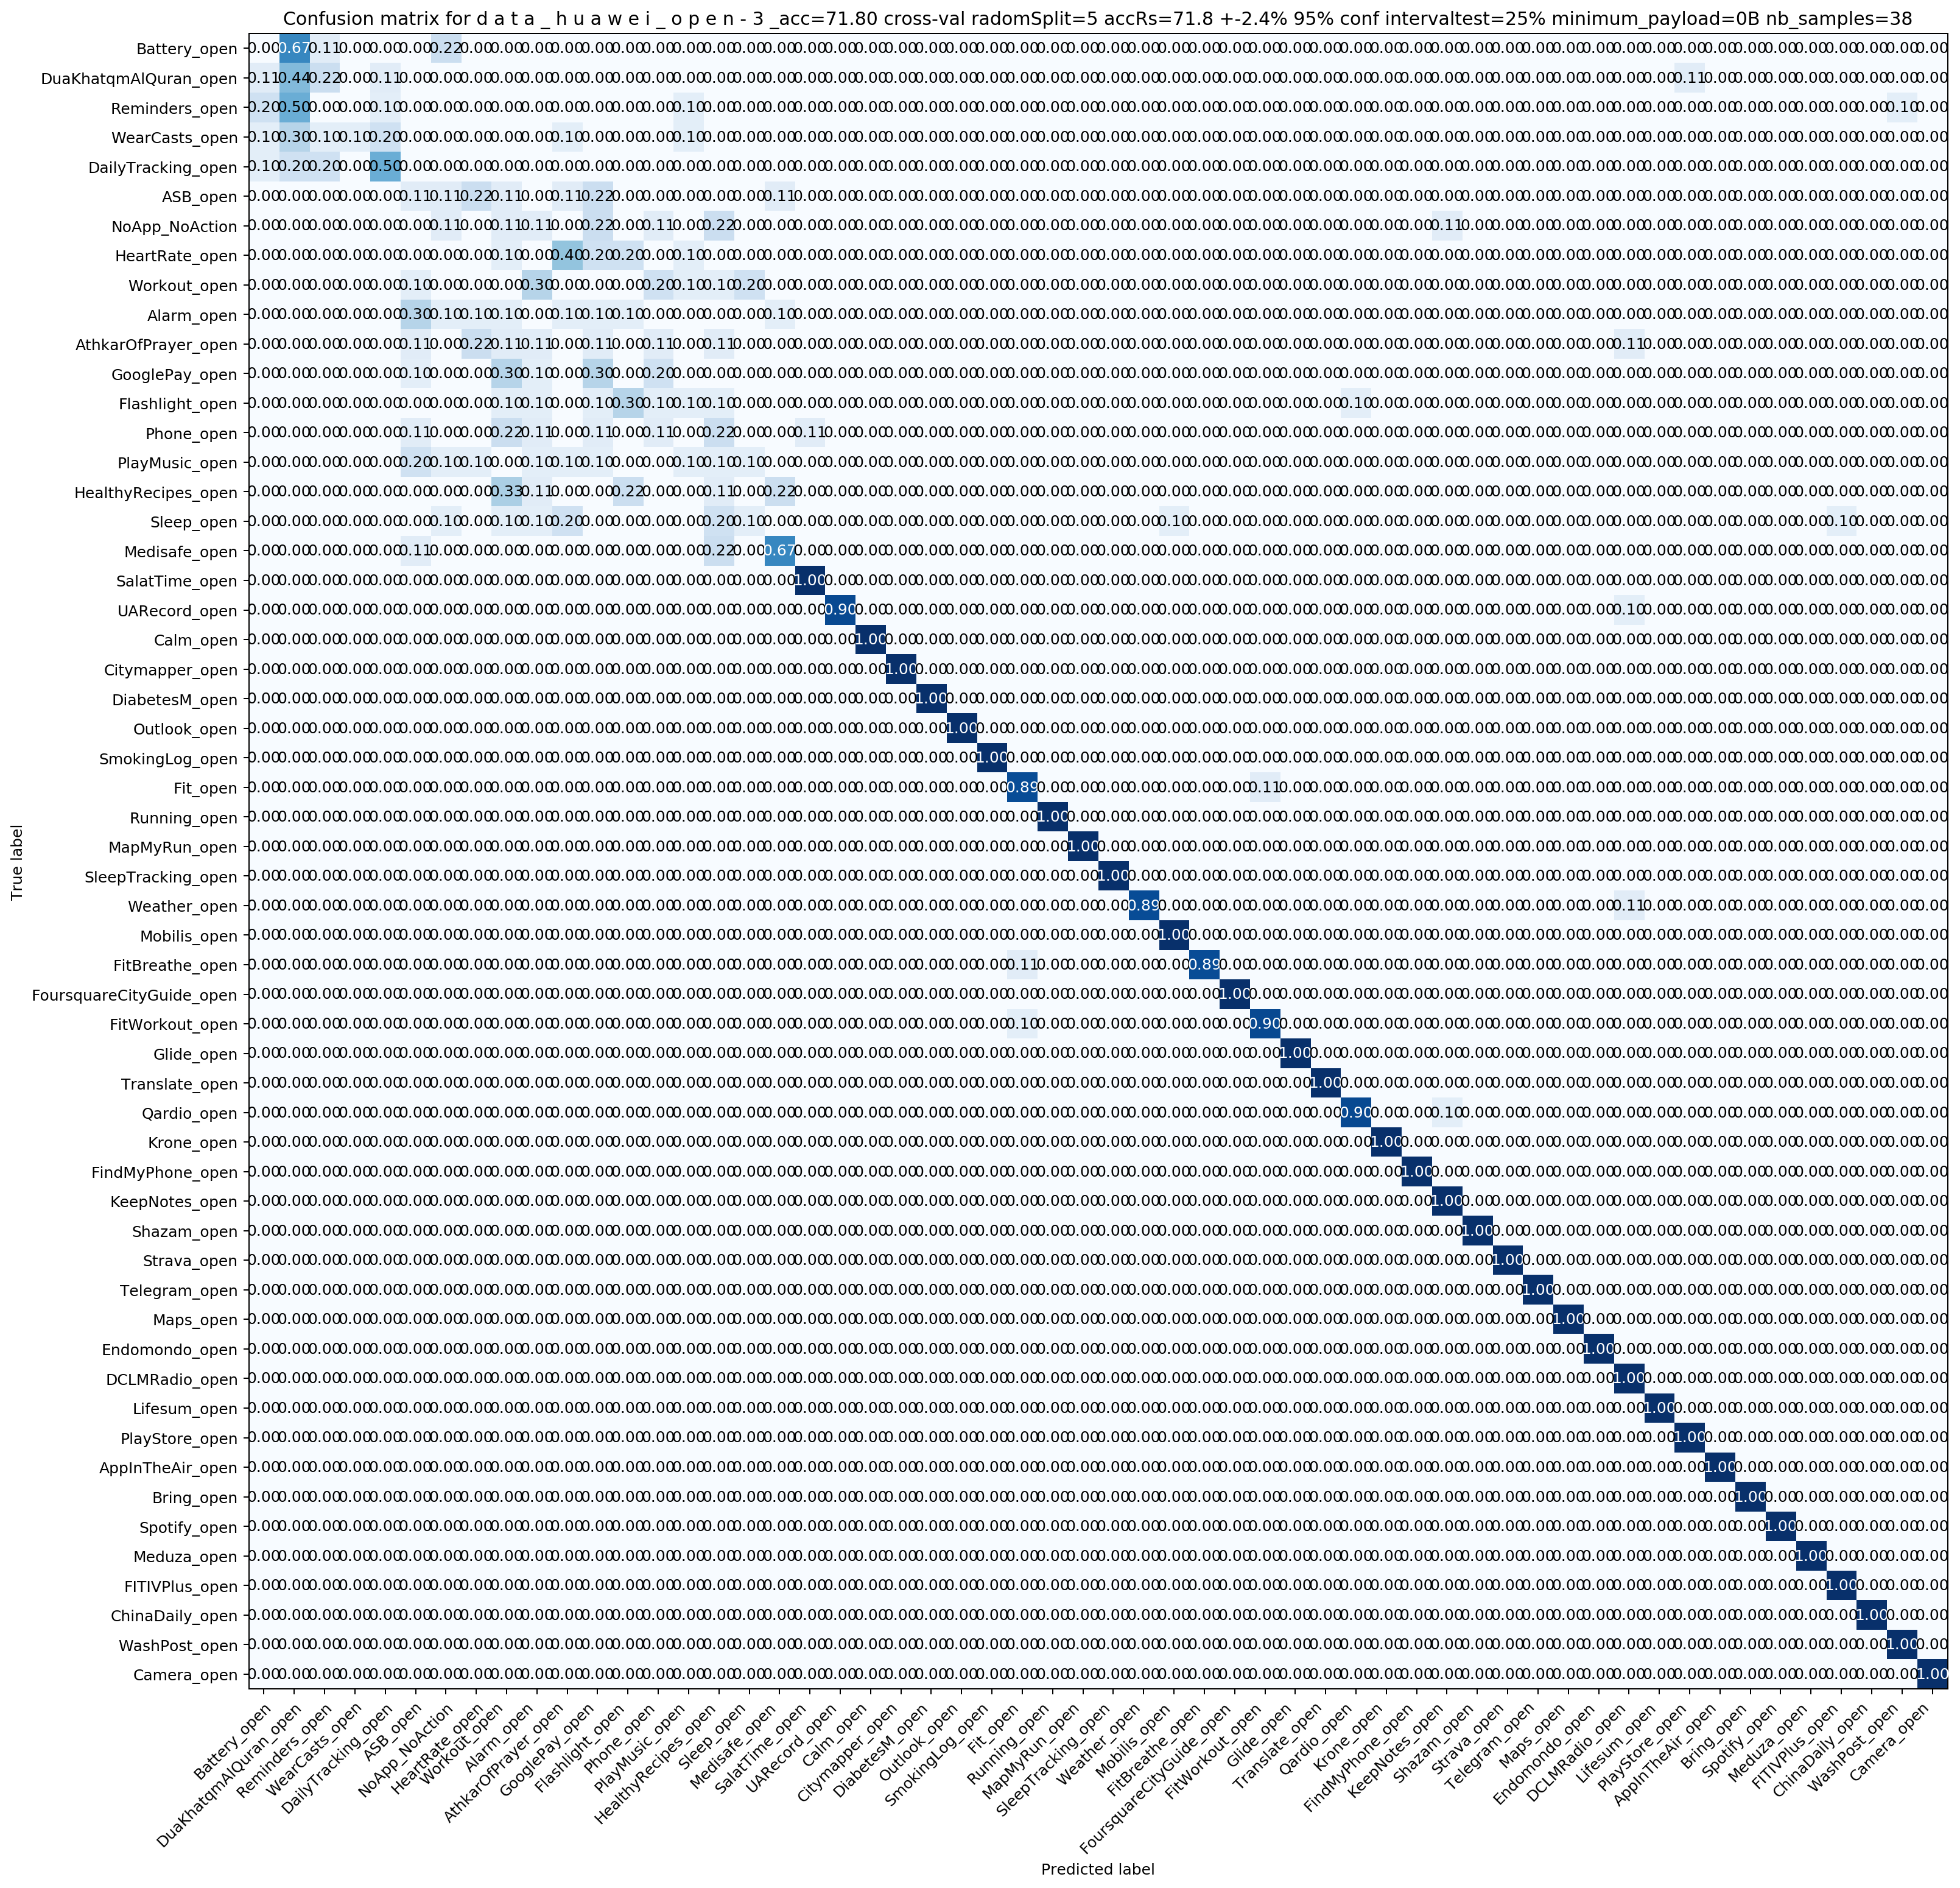

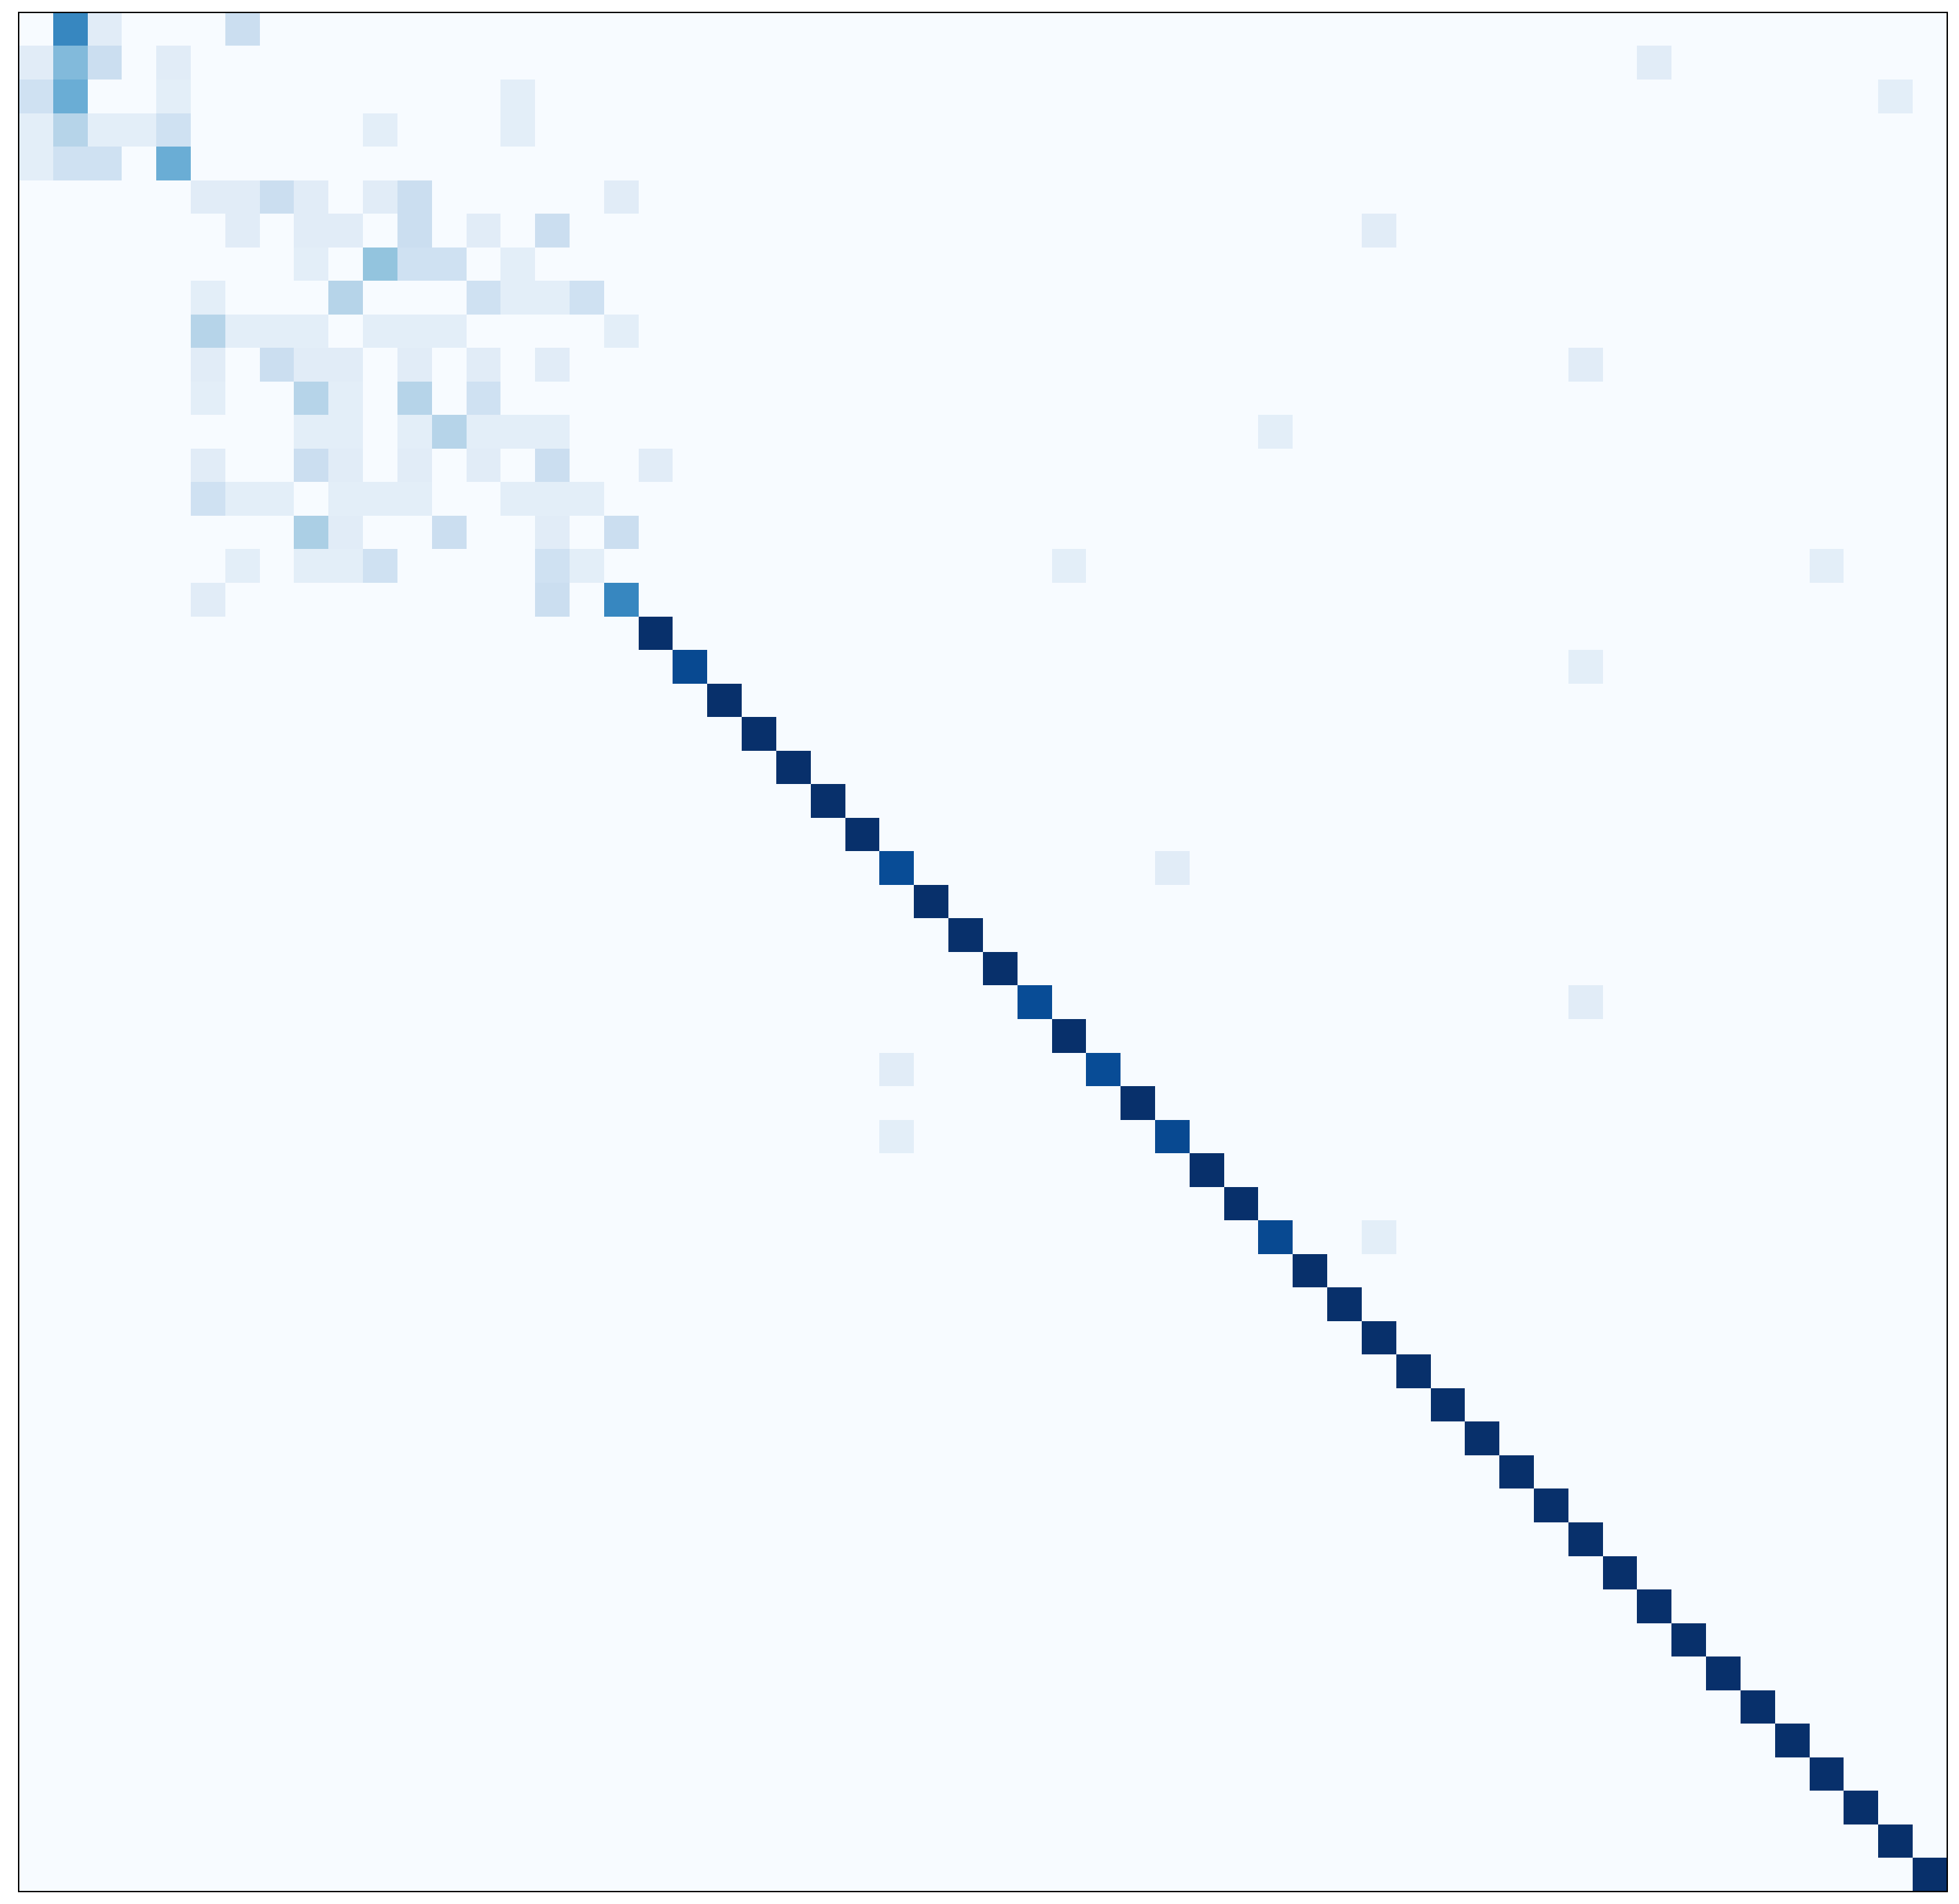

In [393]:
DATA_PATH = "data/huawei/open-3/"
cm = evaluate(DATA_PATH, MINIMUM_PAYLOAD=0, ORDER_CM_BY_SIZE=True, CM_NO_LABELS=True, RETURN_CM=True, figname="Confusion_matrix_ordered_by_amount_of_traffic", DETAIL_PRINT=True)

Accuracy vs median total payload length

In [67]:
plt.plot?

Text(0, 0.5, 'Accuracy')

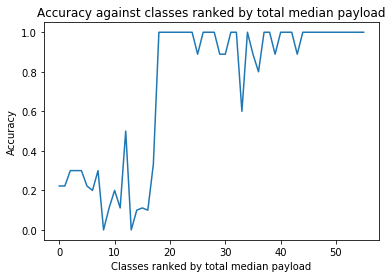

In [80]:
# t = [0.0, 0.0, 0.0, 29.5, 44.0, 75.0, 104.0, 121.0, 122.5, 123.0, 130.5, 137.5, 156.0, 156.0, 156.0, 167.5, 172.0, 223.5, 631.0, 648.0, 1205.5, 1226.5, 1467.5, 1529.5, 1632.5, 1709.5, 1836.0, 1876.0, 1974.0, 2017.5, 2120.0, 2277.5, 2522.5, 3024.0, 4165.5, 5806.5, 6367.5, 6658.5, 7051.5, 7600.0, 7645.0, 8275.5, 8897.5, 10838.5, 12384.0, 17525.0, 17748.0, 23972.0, 26996.0, 34539.5, 38606.5, 47060.5, 51607.5, 53267.0, 119736.0, 610100.5]
accuracies = np.diag(cm)
plt.plot(accuracies)
plt.title("Accuracy against classes ranked by total median payload")
plt.xlabel("Classes ranked by total median payload")
plt.ylabel("Accuracy")


In [98]:
separation = np.where(accuracies < 0.6)[0][-1] + 1

In [99]:
accuracies_bellow = accuracies[:separation]
accuracies_beyond = accuracies[separation:]

In [100]:
print("Mean Accuracy by taking the first n that have less than x total payload", accuracies_bellow.mean())
print("Mean Accuracy by taking the first n that have more than x total payload", accuracies_beyond.mean())


Mean Accuracy by taking the first n that have less than x total payload 0.20185185185185187
Mean Accuracy by taking the first n that have more than x total payload 0.9666666666666667


In [110]:
accuracies[separation +1]

1.0

In [108]:
print("Huge separation "t[separation -1],t[separation])
print()

223.5
631.0


<a id="dataset_size"></a>
### Dataset size Investigation
[Table of Content](#dataset_size)

In [ ]:
DATA_PATH = "data/huawei/open-3/"


n_splits = 3
n_repeat = 15
accuracies_dataset_size = []
confs_dataset_size = []
steps = np.arange(2, 29)

for i in steps:
    print("Keep only ",i, " samples per category")
    for _ in range(n_repeat):
        acc, conf = evaluate(DATA_PATH=DATA_PATH, N_SPLITS=2, RETURN_ACC_AND_CONF=True, DATA_SIZE_FILTER=i)
        print(" %0.2f (+/- %0.2f)" % (acc, conf))
        accuracies_dataset_size.append(acc)
        confs_dataset_size.append(conf)


In [ ]:
xlabel="dataset size per class"
ylabel="accuracy"
title="Accuracy against dataset size per class for Huawei\n25% test "+str(n_splits)+" Random split cross validation ("+ str(n_repeat)+" runs avg)"
fname="./plots/Accuracy_against_dataset_size_per_class_for_Huawei.png"
plot_acc_and_conf(steps, accuracies_dataset_size, confs_dataset_size, n_repeat, y_lim=[0.3, 1.01], 
                  xlabel=xlabel, ylabel=ylabel, title=title, fname=fname, dpi=500)

<img src="./Results/Accuracy_against_dataset_size_per_class_for_Huawei_open-3.png" width='500px'>

In [ ]:
DATA_PATH = "data/fossil/open-6/"

n_splits = 3
n_repeat = 15
accuracies_dataset_size = []
confs_dataset_size = []
steps = np.arange(2, 29)

for i in steps:
    print("Keep only ",i, " samples per category")
    for _ in range(n_repeat):
        acc, conf = evaluate(DATA_PATH=DATA_PATH, N_SPLITS=2, RETURN_ACC_AND_CONF=True, DATA_SIZE_FILTER=i)
        print(" %0.2f (+/- %0.2f)" % (acc, conf))
        accuracies_dataset_size.append(acc)
        confs_dataset_size.append(conf)


In [ ]:
xlabel="dataset size per class"
ylabel="accuracy"
title="Accuracy against dataset size per class for Huawei\n25% test "+str(n_splits)+" Random split cross validation ("+ str(n_repeat)+" runs avg)"
fname="./plots/Accuracy_against_dataset_size_per_class_for_Fossil.png"

plot_acc_and_conf(steps, accuracies_dataset_size, confs_dataset_size, n_repeat, y_lim=[0.3, 1.01],
                  xlabel=xlabel, ylabel=ylabel, title=title, fname=fname, dpi=500)

<img src="./Results/Accuracy_against_dataset_size_per_class_for_Fossil.png" width='500px'>

<a id = "huawei"></a>
### Huaweiwatch 2
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/open-3/"] #, "data/huawei/open-3/", "data/huawei/open-6/"] # all
evaluate(DATA_PATH, DETAIL_PRINT=True, TITLE="", CM_NO_LABELS=True)

In [ ]:
_, _, f_name = evaluate(DATA_PATH, RETURN_FEATURES_AND_LABELS=True)

In [ ]:
features_importance = clf.feature_importances_
top_args = np.argsort(-features_importance)[:30].tolist()

top_feat_name = np.array(f_name)[top_args]
top_importance = np.array(features_importance)[top_args]
print("Top features: ")
print(top_feat_name)
print("Top importance")
print(top_importance)

In [ ]:
f_name

In [ ]:
np.flatnonzero(np.core.defchararray.find(f_name,"unique")!=-1)

In [ ]:
plt.plot(features[:10])

plt.plot(steps, cumul_acc, label="Accuracy when trained with day 0")
plt.scatter(steps, self_acc, color="r", label="Accuracy with itself")
plt.ylim([0.3, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time (huawei open only)")
plt.savefig("Accuracy_over_time_03to1", dpi= 80)


<a id=fossil_eval></a>
### Fossil Evaluation
[Table of content](#tc)

In [ ]:
DATA_PATH = ["data/fossil/open-6/"] # all
evaluate(DATA_PATH)

<a id="apple_watch"></a>
## Apple Watch

[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/iwatch/batch-1/"] #, "data/huawei/open-3/", "data/huawei/open-6/"] # all
events = evaluate(DATA_PATH, DETAIL_PRINT=True, CM_NO_LABELS=True, PRINT_COUNT=True)

### Force-stop
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/force-stop-2/"] # all
DISCARDED_ACTION = [] 
evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, SHUFFLE=True, ORDER_CM_BY_SIZE=True, TITLE="")

<a id='actions'></a>
### Actions

[Table of Content](#tc)


<a id='Foursquarecityguide'></a>
#### Foursquare City Guide

In [ ]:
def extract_features(xy, capture_duration_does_nothing=0, unique_from=46, unique_to=1006, unique_granularity=1): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size
    xs = xy['xs']
    ys = xy['ys']
    f = dict()
    bins = np.arange(0, 1000, step = unique_granularity)
    def extract_bins(x):
        
        if x > bins[-1]:
            b = bins[-1] + 10
        else:
            b = bins[np.digitize(x, bins, right = True)]
        return b

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        f['kurtosis_'+key] = kurtosis(data)



    # general statistics
    stats("non_null", [abs(y) for y in ys if abs(y) < unique_from])
    stats("outgoing", [abs(y) for y in ys if y > unique_from])
    stats("incoming", [abs(y) for y in ys if y < -unique_from])
    #stats("outgoing_30", [abs(y) for y in take(ys) if y > unique_from])
    #stats("incoming_30", [abs(y) for y in take(ys) if y < -unique_from])

    # f["total_payload"] = sum([abs(y) for y in ys])

    # statistics about timings
    x_deltas = []
    i = 1
    
   
    x_deltas_no_zeros = []
    while i<len(xs):
        x_deltas.append(xs[i]-xs[i-1])
        i += 1
    
    xs_no_zeros = [xs[i] for i, y in enumerate(ys) if abs(y) > unique_from]
    i = 1
    while i<len(xs_no_zeros):
        x_deltas_no_zeros.append(xs_no_zeros[i]-xs_no_zeros[i-1])
        i += 1

    stats("x_deltas", x_deltas)
    stats("x_deltas_no_zeros", x_deltas_no_zeros)

    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(unique_from, unique_to):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    stats("unique_lengths", lengths_array)
    for l in lengths:
        f['unique_lengths_'+str(l)] = extract_bins(lengths[l])
        
    return f


In [ ]:
DATA_PATH = ["data/huawei/FoursquareCityGuide-1/"] # all
DISCARDED_ACTION = ["DiabetesM_addCarbsaddInsulin"] 
evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, SHUFFLE=True, N_ESTIMATOR=1000)

<a id='DiabetesM'></a>

#### DiabetesM
[Table of Content](#tc)

with both: 57_5_+-7_9%
with non_zeros only: 55_8_+-6_0%
with zeros only: 45_2_+-6_4%_95%


Saved image ./plots/Confusion_matrix_for_huawei_DiabetesM-1__huawei_DiabetesM-2__huawei_DiabetesM-3__huawei_DiabetesM-4_acc=55_88_cross-val_radomSplit=5_accRs=56_6_+-5_6%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=113.png


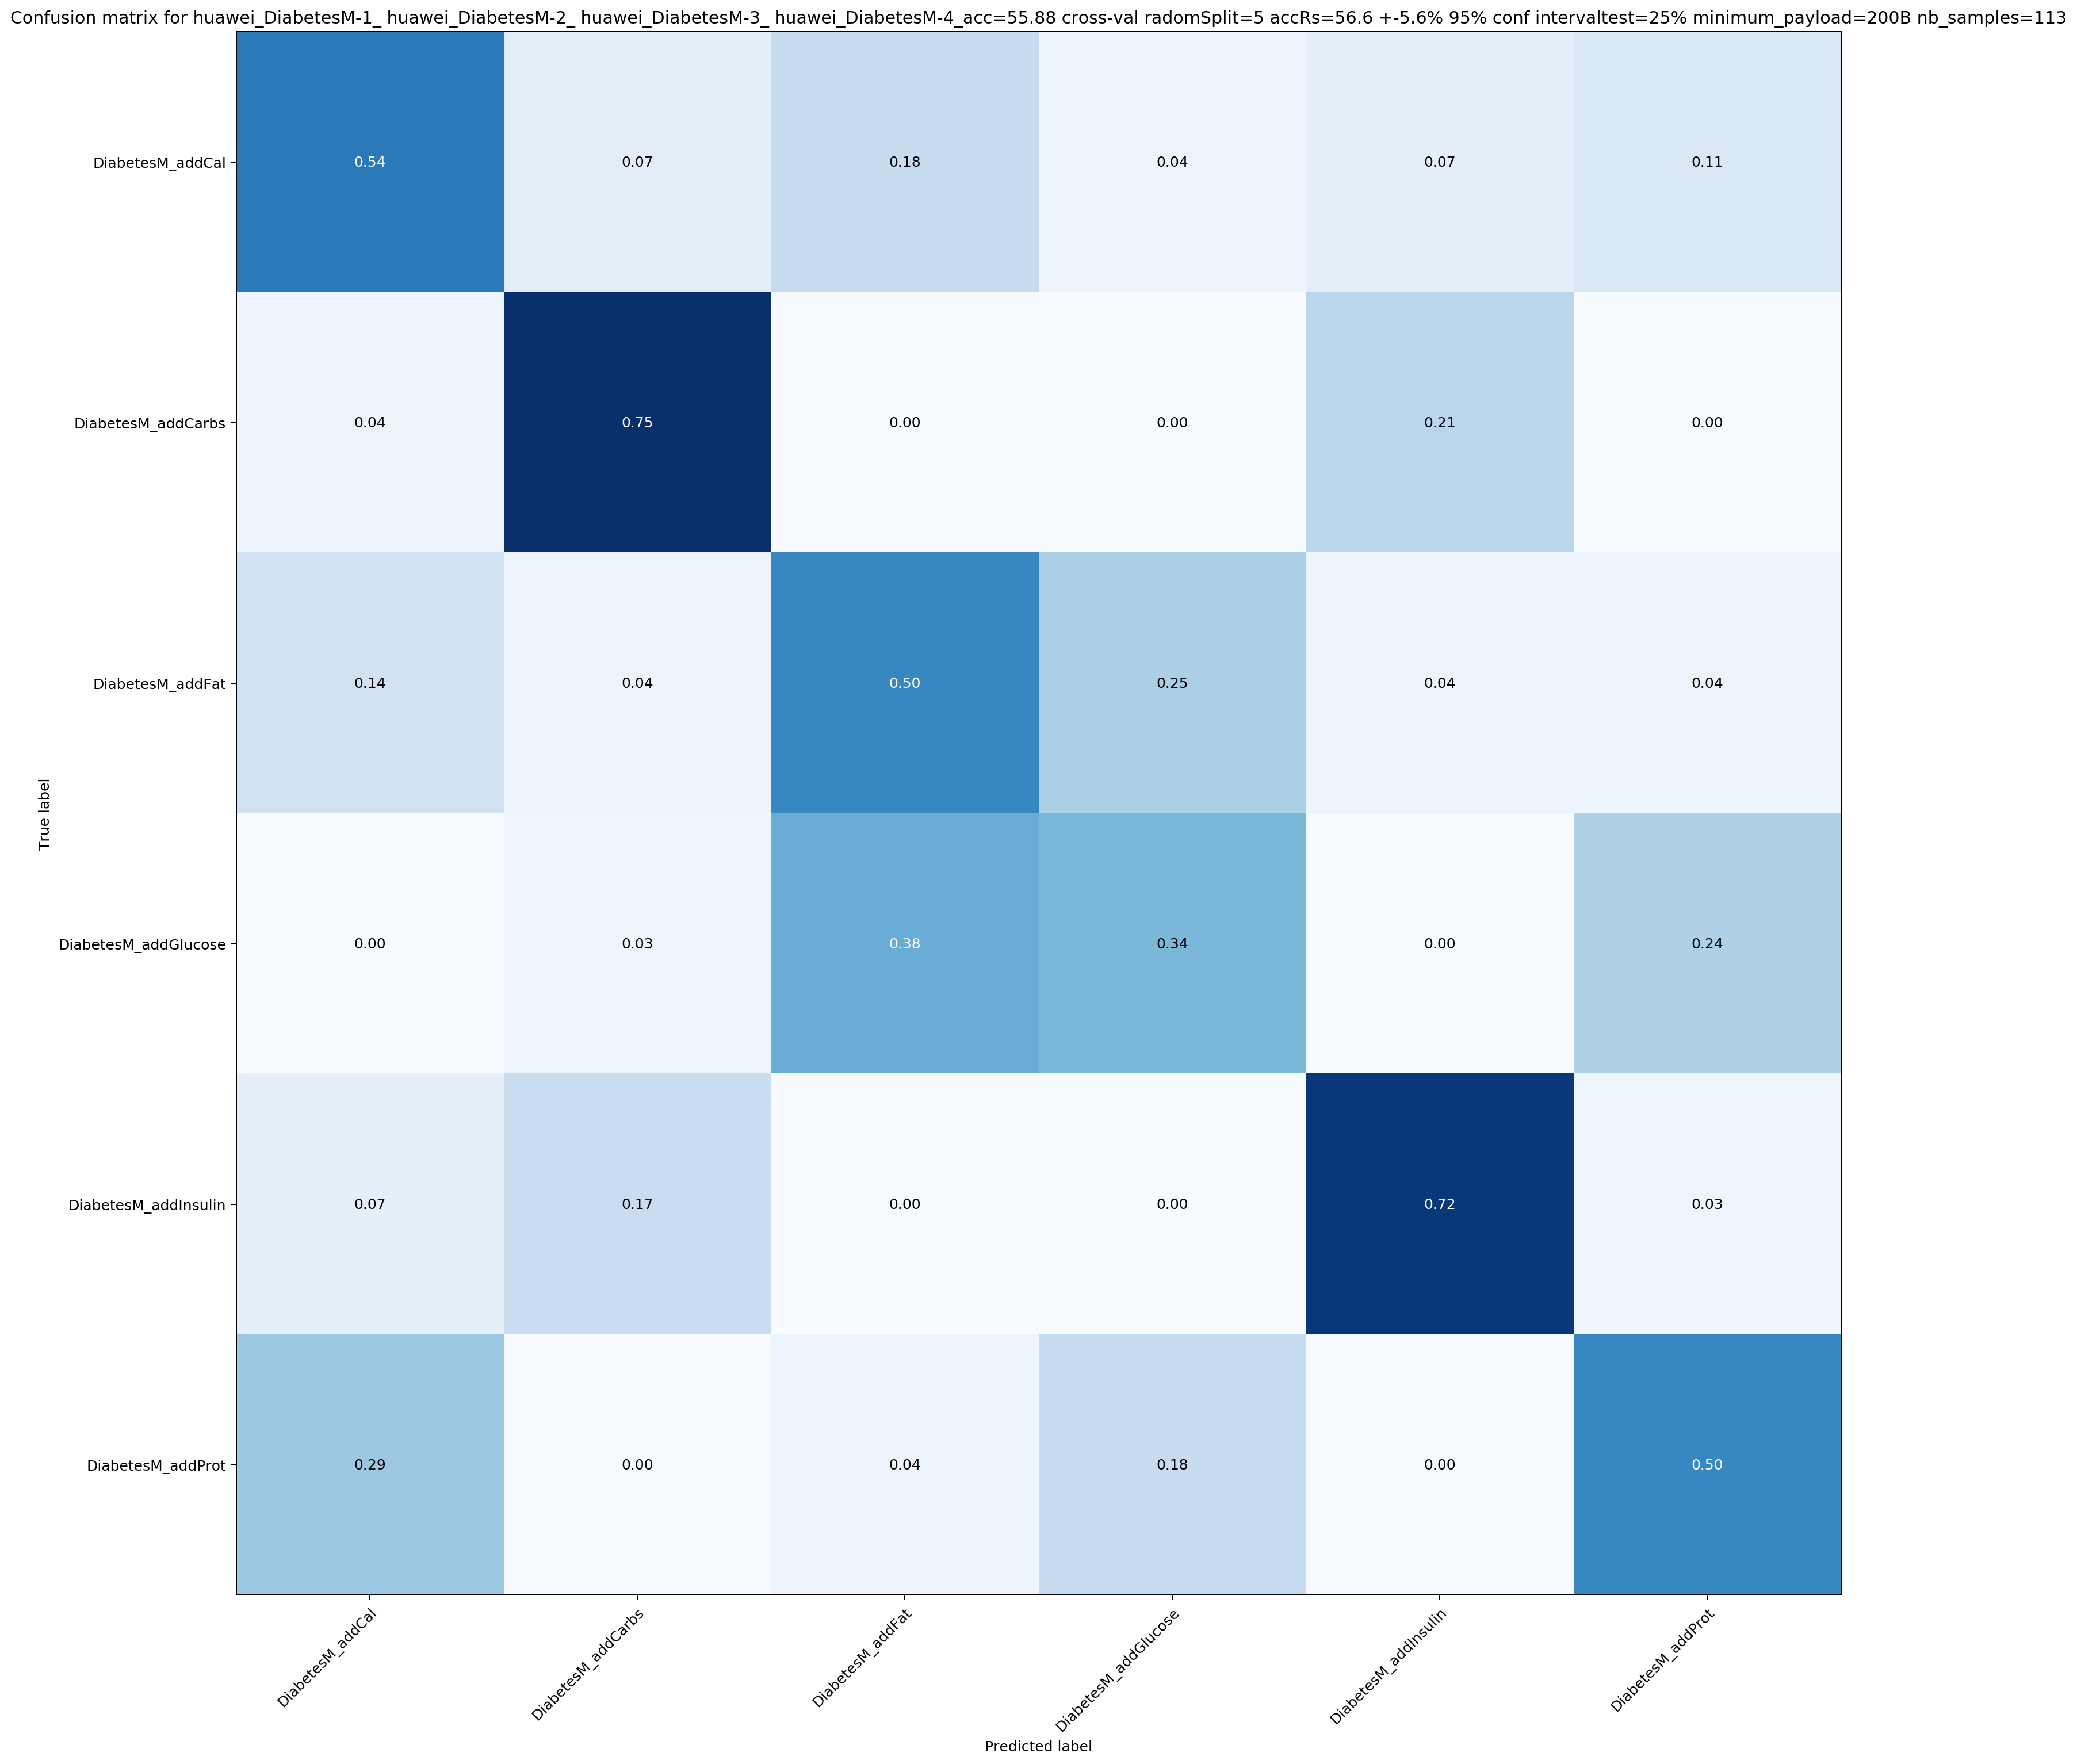

In [401]:
DATA_PATH = ["data/huawei/DiabetesM-1/", "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/"] # all
DISCARDED_ACTION = ["DiabetesM_addCarbsaddInsulin"] 
evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION,SHUFFLE=True, N_ESTIMATOR=1000)

##### Most used features classification

In [292]:
import shap

In [226]:
X, y, f_name = evaluate(DATA_PATH, RETURN_FEATURES_AND_LABELS=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
X_train, X_test, f_name = np.array(X_train), np.array(X_test), np.array(f_name)
clf=RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)
feat_importance_filter = 0.005
to_withdraw = np.where(features_importance<feat_importance_filter)
X_filtered, f_name_filtered = feat_filter(X, f_name, to_withdraw)

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y, stratify=y, test_size=0.25)
clf=RandomForestClassifier(n_estimators=200)
clf.fit(X_train_filtered, y_train_filtered)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [227]:
features_importance = clf.feature_importances_
top_args = np.argsort(-features_importance)[:30].tolist()
print("Top features: ")
print(np.array(f_name)[top_args])
print("Top importance")
print(np.array(features_importance)[top_args])

Top features: 
['mean_incoming' 'min_incoming' 'max_outgoing' 'min_outgoing'
 'kurtosis_outgoing' 'unique_lengths_69' 'count_incoming'
 'kurtosis_incoming' 'count_outgoing' 'mean_outgoing' 'kurtosis_non_null'
 'mean_x_deltas_no_zeros' 'std_x_deltas' 'min_x_deltas' 'max_x_deltas'
 'count_x_deltas' 'kurtosis_x_deltas_no_zeros' 'mean_unique_lengths'
 'std_unique_lengths' 'std_outgoing' 'unique_lengths_46' 'max_incoming'
 'max_non_null' 'count_x_deltas_no_zeros' 'min_unique_lengths'
 'unique_lengths_64' 'min_x_deltas_no_zeros' 'unique_lengths_47'
 'unique_lengths_56' 'unique_lengths_58']
Top importance
[0.0577539  0.03920632 0.03873554 0.03759866 0.03744636 0.0364024
 0.03481825 0.0342872  0.03386153 0.03042467 0.02264989 0.02248564
 0.02126786 0.02057875 0.01950088 0.01900767 0.01890622 0.01884848
 0.01859576 0.0181156  0.01811024 0.01736292 0.01712424 0.01700841
 0.01634358 0.01527808 0.01451169 0.01325879 0.01323393 0.01311662]


In [228]:
clf.feature_importances_

array([0.00739101, 0.00888168, 0.01712424, 0.00990563, 0.00733474,
       0.02264989, 0.03759866, 0.03042467, 0.03873554, 0.03386153,
       0.0181156 , 0.03744636, 0.03920632, 0.0577539 , 0.01736292,
       0.03481825, 0.01227273, 0.0342872 , 0.02057875, 0.0077321 ,
       0.01950088, 0.01900767, 0.02126786, 0.00708067, 0.01451169,
       0.02248564, 0.01304732, 0.01700841, 0.00958821, 0.01890622,
       0.01634358, 0.01884848, 0.00933291, 0.00709686, 0.01859576,
       0.00762866, 0.01811024, 0.01325879, 0.00966547, 0.00821749,
       0.00752578, 0.00865826, 0.00620272, 0.01040695, 0.00607855,
       0.01175604, 0.01323393, 0.01118818, 0.01311662, 0.00635972,
       0.0086916 , 0.0103376 , 0.01012962, 0.01000548, 0.01527808,
       0.01033339, 0.00359987, 0.00996659, 0.0077441 , 0.0364024 ])

In [229]:
features_importance[np.where(f_name == 'min_x_deltas')]

array([0.02057875])

In [235]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(np.array(np.array(X_train_filtered)))
shap.summary_plot(shap_values, X_test, plot_type="bar")

SHAPError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 0.940000, while the model output was -1.060000. If this difference is acceptable you can set check_additivity=False to disable this check.

In [236]:

shap_values_rf = shap.TreeExplainer(clf).shap_values(X_test)


KeyboardInterrupt: 

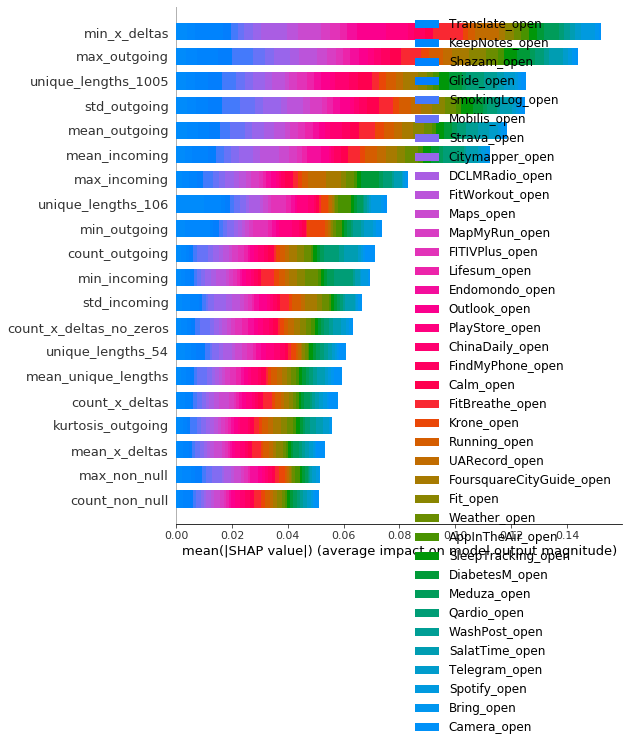

In [151]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=f_name, class_names=clf.classes_)

In [156]:
shap.dependence_plot('unique_lengths_106', shap_values, X_train, feature_names=f_name)#, class_names=clf.classes_)

TypeError: The passed shap_values are a list not an array! If you have a list of explanations try passing shap_values[0] instead to explain the first output class of a multi-output model.

In [136]:
clf = evaluate(DATA_PATH, RETURN_CLF=True)
X, y, f_name = evaluate(DATA_PATH, RETURN_FEATURES_AND_LABELS=True)
keep_feat_ratio = 0.01
X = np.array(X)
y = np.array(y).reshape(-1,1)
dataset = np.c_[y, X]
df = pd.DataFrame(X, columns= f_name, dtype=np.float64)
df["class"] = y
sum_by_class_on_features = df.groupby("class").sum()
std_by_class_on_features = sum_by_class_on_features.std()
std_by_class_on_features

min_non_null               0.000000
mean_non_null             23.998953
max_non_null             290.584192
count_non_null         76319.435739
std_non_null              32.258484
                           ...     
unique_lengths_1001        0.000000
unique_lengths_1002        6.867420
unique_lengths_1003        0.000000
unique_lengths_1004        0.000000
unique_lengths_1005     2053.105620
Length: 996, dtype: float64

In [137]:
shap.TreeExplainer(clf)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
std_by_class_on_features[std_by_class_on_features > 10]

In [ ]:
std_by_class_on_features[std_by_class_on_features > 10]  # which are the features that differs accorss classes

df[df["unique_lengths_216"] > 0].groupby("class").count()


In [ ]:
df["possess_216"] = df["unique_lengths_216"].map(lambda x: 1 if x > 0 else 0)

In [ ]:
df[df["possess_216"]].groupby("class").count()

In [ ]:
keep_unique = [
    "unique_lengths_51",
    "unique_lengths_54",
    "unique_lengths_57",
    "unique_lengths_78" ,
    "unique_lengths_159",
    "unique_lengths_162",
    "unique_lengths_165" ,
    "unique_lengths_168",
    "unique_lengths_170" ,
    "unique_lengths_172"  ,
    "unique_lengths_174" ,
    "unique_lengths_176" ,
    "unique_lengths_192",
    "unique_lengths_194" ,
    "unique_lengths_213",
    "unique_lengths_216" ,
    "unique_lengths_1005" 
]

In [ ]:
not_unique_length = [i for i, n in enumerate(f_name) if n not in keep_unique]
evaluate(DATA_PATH, FILTER_FEATURE=to_remove)

In [131]:
clf = evaluate(DATA_PATH, RETURN_CLF=True)
# Test accuracy when removing all best params
features_importance = clf.feature_importances_
zeros_importance = np.argwhere(features_importance == 0).flatten().tolist()
not_unique_length = [i for i, n in enumerate(f_name) if not "unique" in n]
to_remove = zeros_importance + not_unique_length
# Removing all features that has no importance
evaluate(DATA_PATH, FILTER_FEATURE=to_remove)

NameError: name 'f_name' is not defined

In [ ]:
print(len(X[0]))

In [ ]:
features_importance = clf.feature_importances_
top_args = np.argsort(-features_importance)[:30].tolist()
print("Top features: ")
print(np.array(f_name)[top_args])
print("Top importance")
print(np.array(features_importance)[top_args])

In [ ]:
np.arg

In [ ]:

to_withdraw = [200]
X_filtered, f_name_filtered = feat_filter(X, f_name, to_withdraw)

<a id = "endomondo"></a>
#### Endomondo

In [ ]:
DATA_PATH = ["data/huawei/Endomondo-1/"] # all
evaluate(DATA_PATH, figsize=(5,5))

In [ ]:
X_test = np.array(X_test)

In [ ]:
X_test[0,3]

In [ ]:
X_test[0,:10]

<a id='lifesum'></a>
#### Lifesum
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/Lifesum-1/"] # all
evaluate(DATA_PATH, figsize=(5,5))

<a id="all_action_within_apps"></a>
#### All action within apps
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/DiabetesM-2/",
             "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/"]

evaluate(DATA_PATH, figname="all_within_app", TITLE= "", DETAIL_PRINT=True)

### Focus on addInsuline action

In [ ]:
DATA_PATH = ["data/huawei/DiabetesM-1/", "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/"] # all
TO_MERGE = [["DiabetesM_addCal", "DiabetesM_addCarbs", "DiabetesM_addFat", "DiabetesM_addProt", "DiabetesM_addProt", "DiabetesM_addGlucose"]] 
evaluate(DATA_PATH, TO_MERGE=TO_MERGE, figsize=(8,8), PRINT_COUNT=True, N_ESTIMATOR=1000)

In [ ]:
precisions = []
recalls = []

In [ ]:
# Merge further more

DATA_PATH = ["data/huawei/DiabetesM-1/", "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/"] # all
TO_MERGE = [["DiabetesM_addCal", "DiabetesM_addCarbs", "DiabetesM_addFat", "DiabetesM_addProt", "DiabetesM_addGlucose"]] 

for _ in range(10):
    y_test, y_pred = evaluate(DATA_PATH, TO_MERGE=TO_MERGE, PRINT_COUNT=False, N_ESTIMATOR=100, RETURN_PRED= True)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=["DiabetesM_addInsulin"])
    precisions += precision.tolist()
    recalls += recall.tolist()

In [ ]:
print("precisions_avg={} recall_avg={}".format(sum(precisions)/len(precisions),sum(recalls)/len(recalls)))
print("precision min: {} - max {}".format(min(precisions), max(precisions)))
print("recall_min: {} - max {}".format(min(precisions), max(precisions)))

Way to improve:
    - Make the dataset balanced when merging app (It could be that a class is much more present than other classes in the train and the in test it changes).
    - Use most prunning to isolate most important features and discard other features
    - Change the model to 1d convalution

<a id = 'all'></a>
### All In-App together
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/DiabetesM-2/",
             "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/"]
evaluate(DATA_PATH, figname = "all_inApp_action_with_new_feature", TITLE="", N_ESTIMATOR=200, DETAIL_PRINT=True, CM_NO_LABELS=True)

<a id = 'all'></a>
### All acition all together
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/DiabetesM-2/",
             "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/", "data/huawei/open-3/"]
events = evaluate(DATA_PATH, RETURN_FILTIRED=True, CM_NO_LABELS=True)
all_actions = get_all_actions(events)



In [ ]:
print("There are {} actions in the matrix. Bellow is the list of all the actions".format(len(all_actions)))
print()
print(all_actions)

In [ ]:
evaluate(DATA_PATH, CM_NO_LABELS=True, TITLE="", figname = "all_action_together", DETAIL_PRINT=True)

<a id='transferability'></a>
## PART IV - Transferability
[Table of content](#tc)

<a id='huawei_fossil_train_test'></a>
### Huawei and Fossil both in train and test

Methodology: remove actions that are not common in both watches, balance data across watch and actions to be sure the 50% of the data on the train are coming from huaweiwatch and the other 50% from Fossil per class. Same for the test data. Mix all of it and separate train and test when the data is mixed. 

In [ ]:
N_ESTIMATOR = 100
REPEAT = 50
RANDOM_STATE = 42

DATA_PATH = ["data/huawei/open-6/", "data/fossil/open-6/"] # all
equilibrate_events = evaluate(DATA_PATH, RETURN_EQUILIBRATE_EVENTS=True)

equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]

print("building features and labels")
X_huawei, y_huawei, features_name = build_features_labels_dataset(equilibrate_events_huawei)
X_fossil, y_fossil, features_name  = build_features_labels_dataset(equilibrate_events_fossil)



X_train_huawei, X_test_huawei, y_train_huawei, y_test_huawei = train_test_split(X_huawei, y_huawei,
                                                                                stratify=y_huawei, 
                                                                                test_size=0.25,
                                                                                random_state=RANDOM_STATE)

X_train_fossil, X_test_fossil, y_train_fossil, y_test_fossil = train_test_split(X_fossil, y_fossil,
                                                                                stratify=y_fossil,
                                                                                test_size=0.25,
                                                                                random_state=RANDOM_STATE)

X_train = X_train_huawei + X_train_fossil
y_train = y_train_huawei + y_train_fossil

X_test = X_test_huawei + X_test_fossil
y_test = y_test_huawei + y_test_fossil


clf_2watch =RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=RANDOM_STATE)
clf_2watch.fit(X_train, y_train)
y_pred = clf_2watch.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("accuracy = ", accuracy)

title = "Train and test with huawei and fossil dataset mixed"
cm, _, _ = plot_confusion_matrix(y_test, y_pred, title= title, figname = title.replace(" ", "_"), PLOT_DIR="./plots/")
# accuracies = []
# for _ in re



<a id='huawei_fossil_train_test_class_separation'></a>
### Train and test including both watches but with class separation
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/open-6/", "data/fossil/open-6/"] # all
DISCARDED_ACTION = ["WashPost_openConnectionError", "AppInTheAir_openNotLogin"] 
evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, figsize=(25,25), SEPARATE_WATCH=True)

<a id='train_test_different_watch'></a>
### Training and testing with different watch respectively
[table of content](#tc)

Methodology: Delete app that does not occur in either the huawei and fossil dataset. Use all the huawei dataset to train, use all the Fossil dataset to test and vice versa

<a id='setup_transfer'></a>
#### Setup

In [417]:

DATA_PATH = ["data/fossil/open-6/","data/huawei/open-6/", "data/huawei/elapsed-time/open-7/","data/huawei/elapsed-time/open-8/", "data/huawei/elapsed-time/open-9/", "data/huawei/elapsed-time/open-10/","data/huawei/elapsed-time/open-11/",  "data/huawei/elapsed-time/open-12/", "data/huawei/elapsed-time/open-13/"]
DISCARD = [] # ["FindMyPhone_open", "Running_open", "Strava_open"]
TO_MERGED = [] # [["FitWorkout_open", "Fit_open", "FitBreathe_open"]]
Names = [] # ["FitGroup_open"]
equilibrate_events = evaluate(DATA_PATH, UNIQUE_DELTAS=[] , DISCARDED_ACTION=DISCARD, TO_MERGE=TO_MERGED, MERGED_NAMES=Names, EQUALIZATION=True, RETURN_EQUILIBRATE_EVENTS=True, PRINT_COUNT=False)


equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]

print("building features and labels")
X_huawei, y_huawei, f_name = build_features_labels_dataset(equilibrate_events_huawei)
X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil)

building features and labels


<a id='thtf'></a>
#### Train with Huawei, test with Fossil
[Table of Content](#tc)

With Original Features

building and training the model for cross validation 
building and training the model
accuracy =  0.8515625
Saved image ./plots/Confusion_matrix_train_with_Huawei(overtime)_test_with_Fossil_acc=85_16.png
Saved image ./plots/Confusion_matrix_train_with_Huawei(overtime)_test_with_Fossil_acc=85_16_nolabels.png


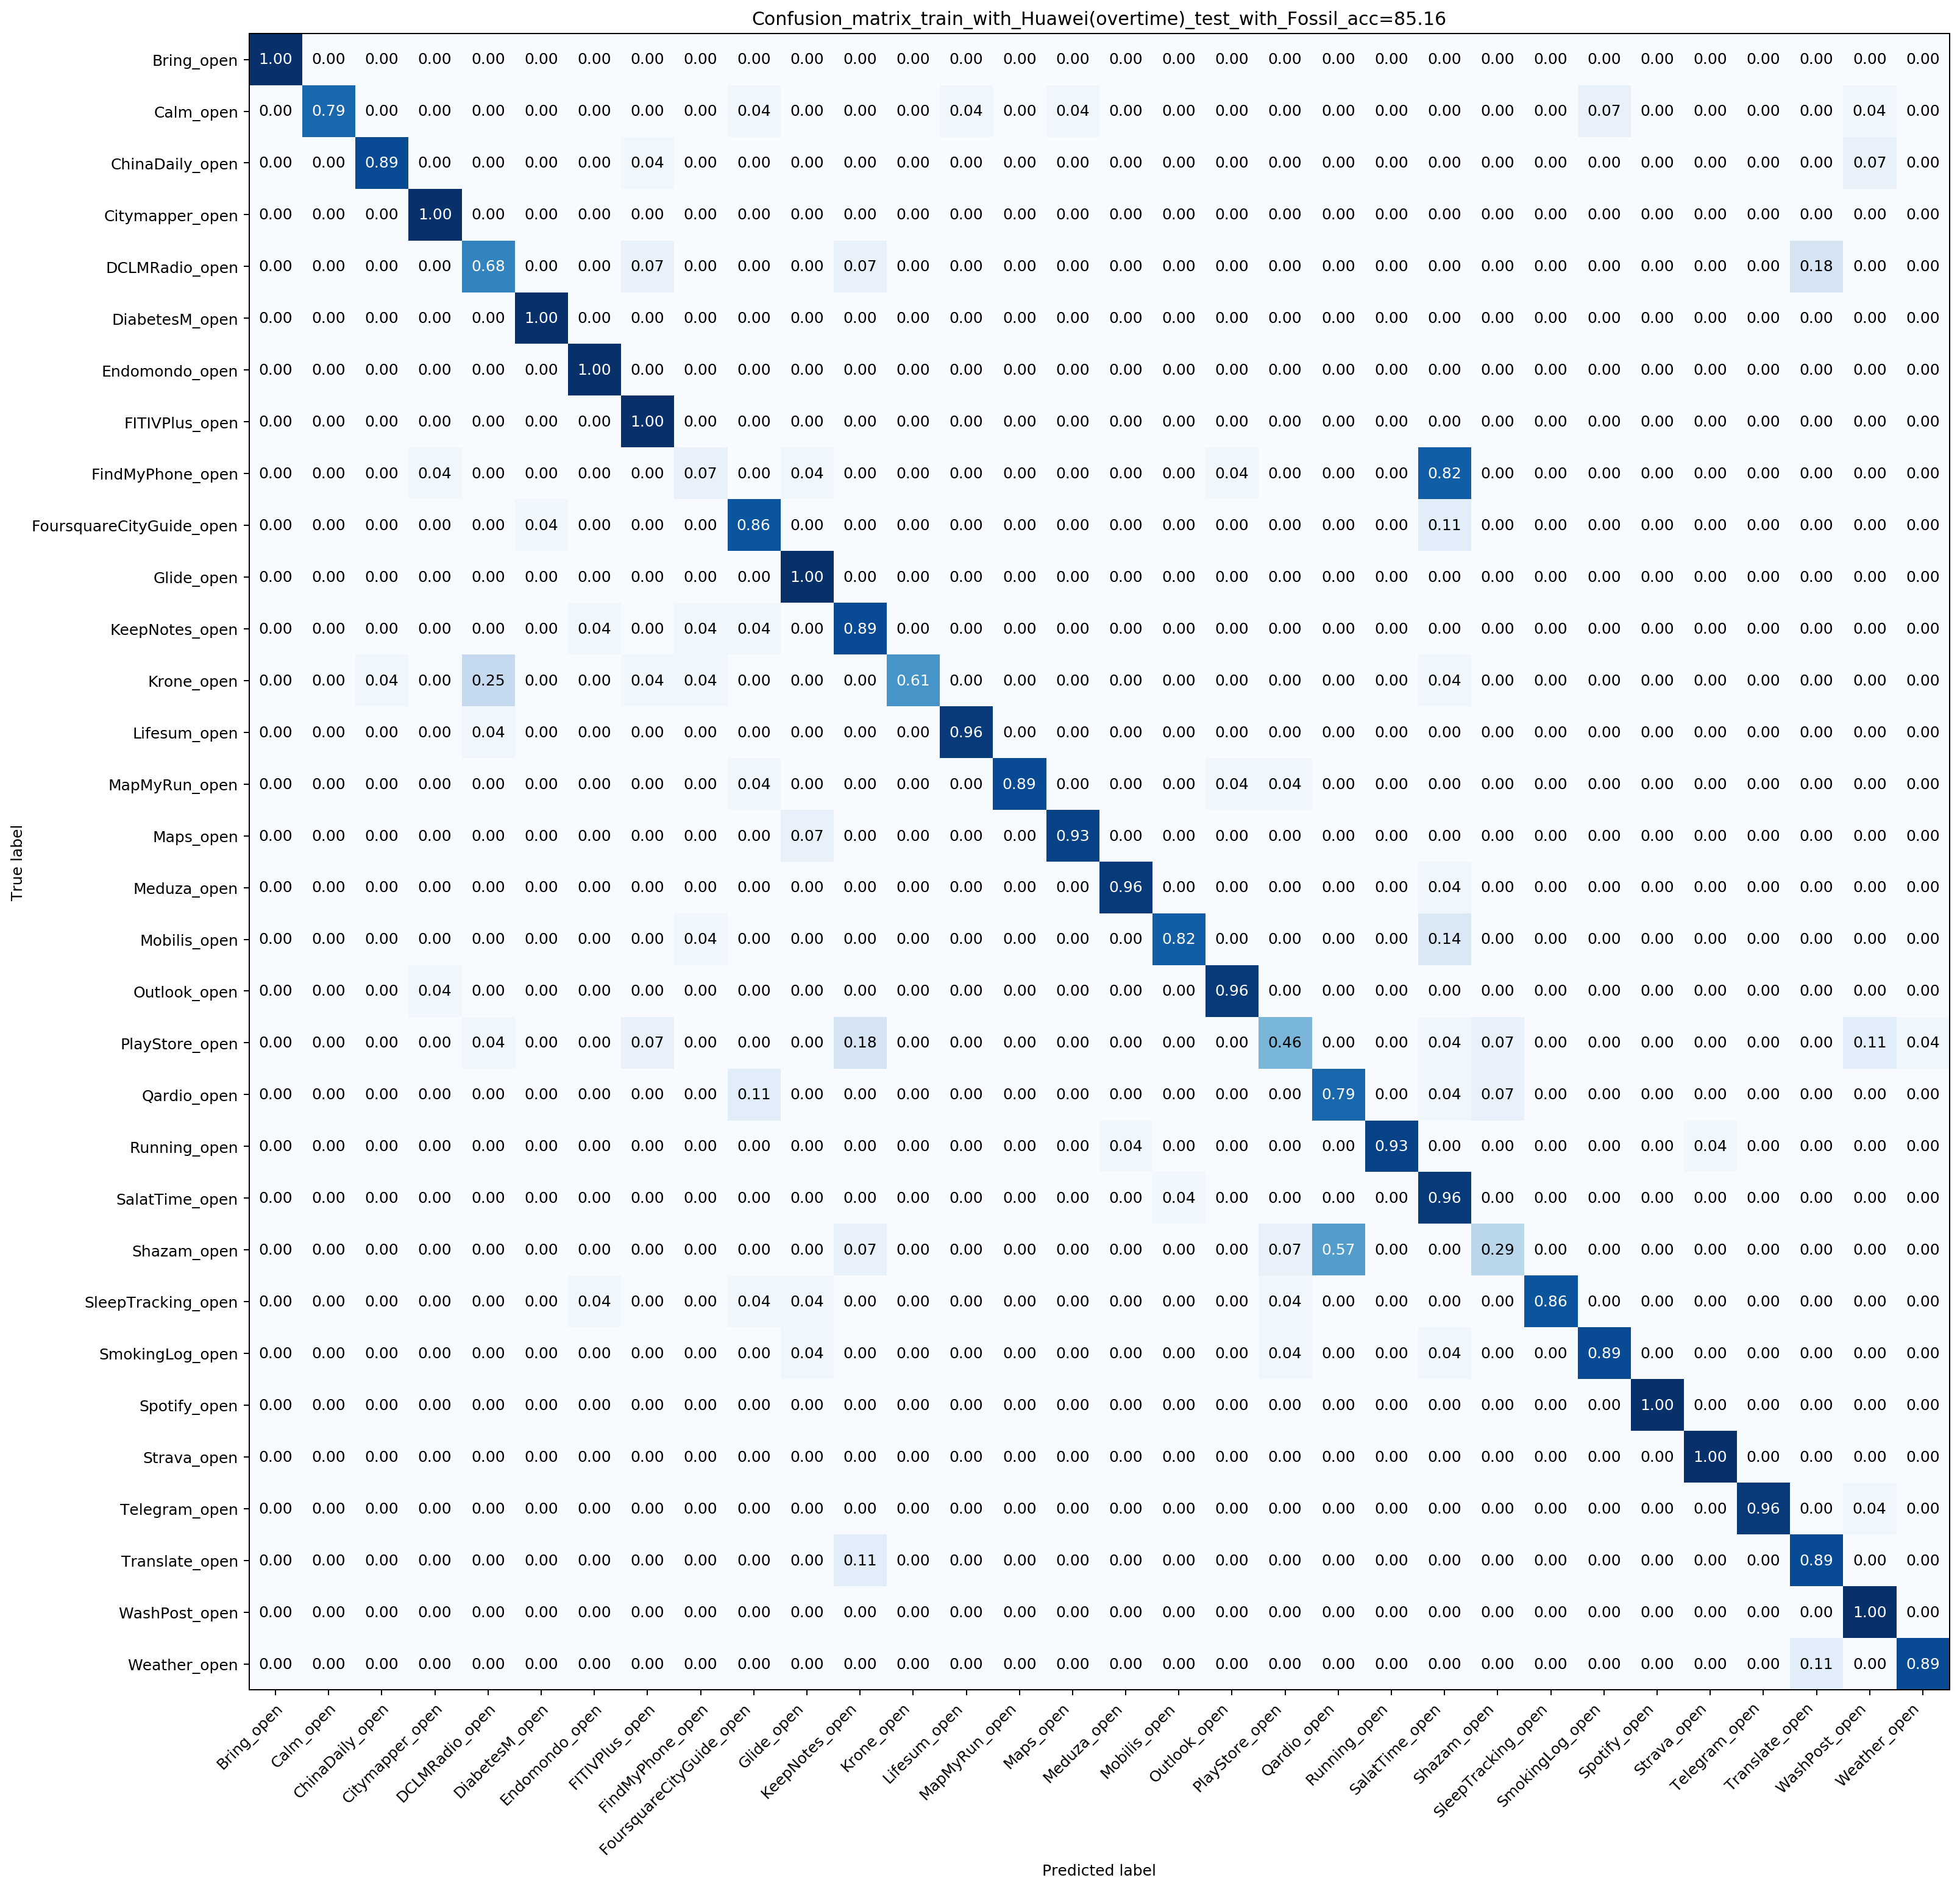

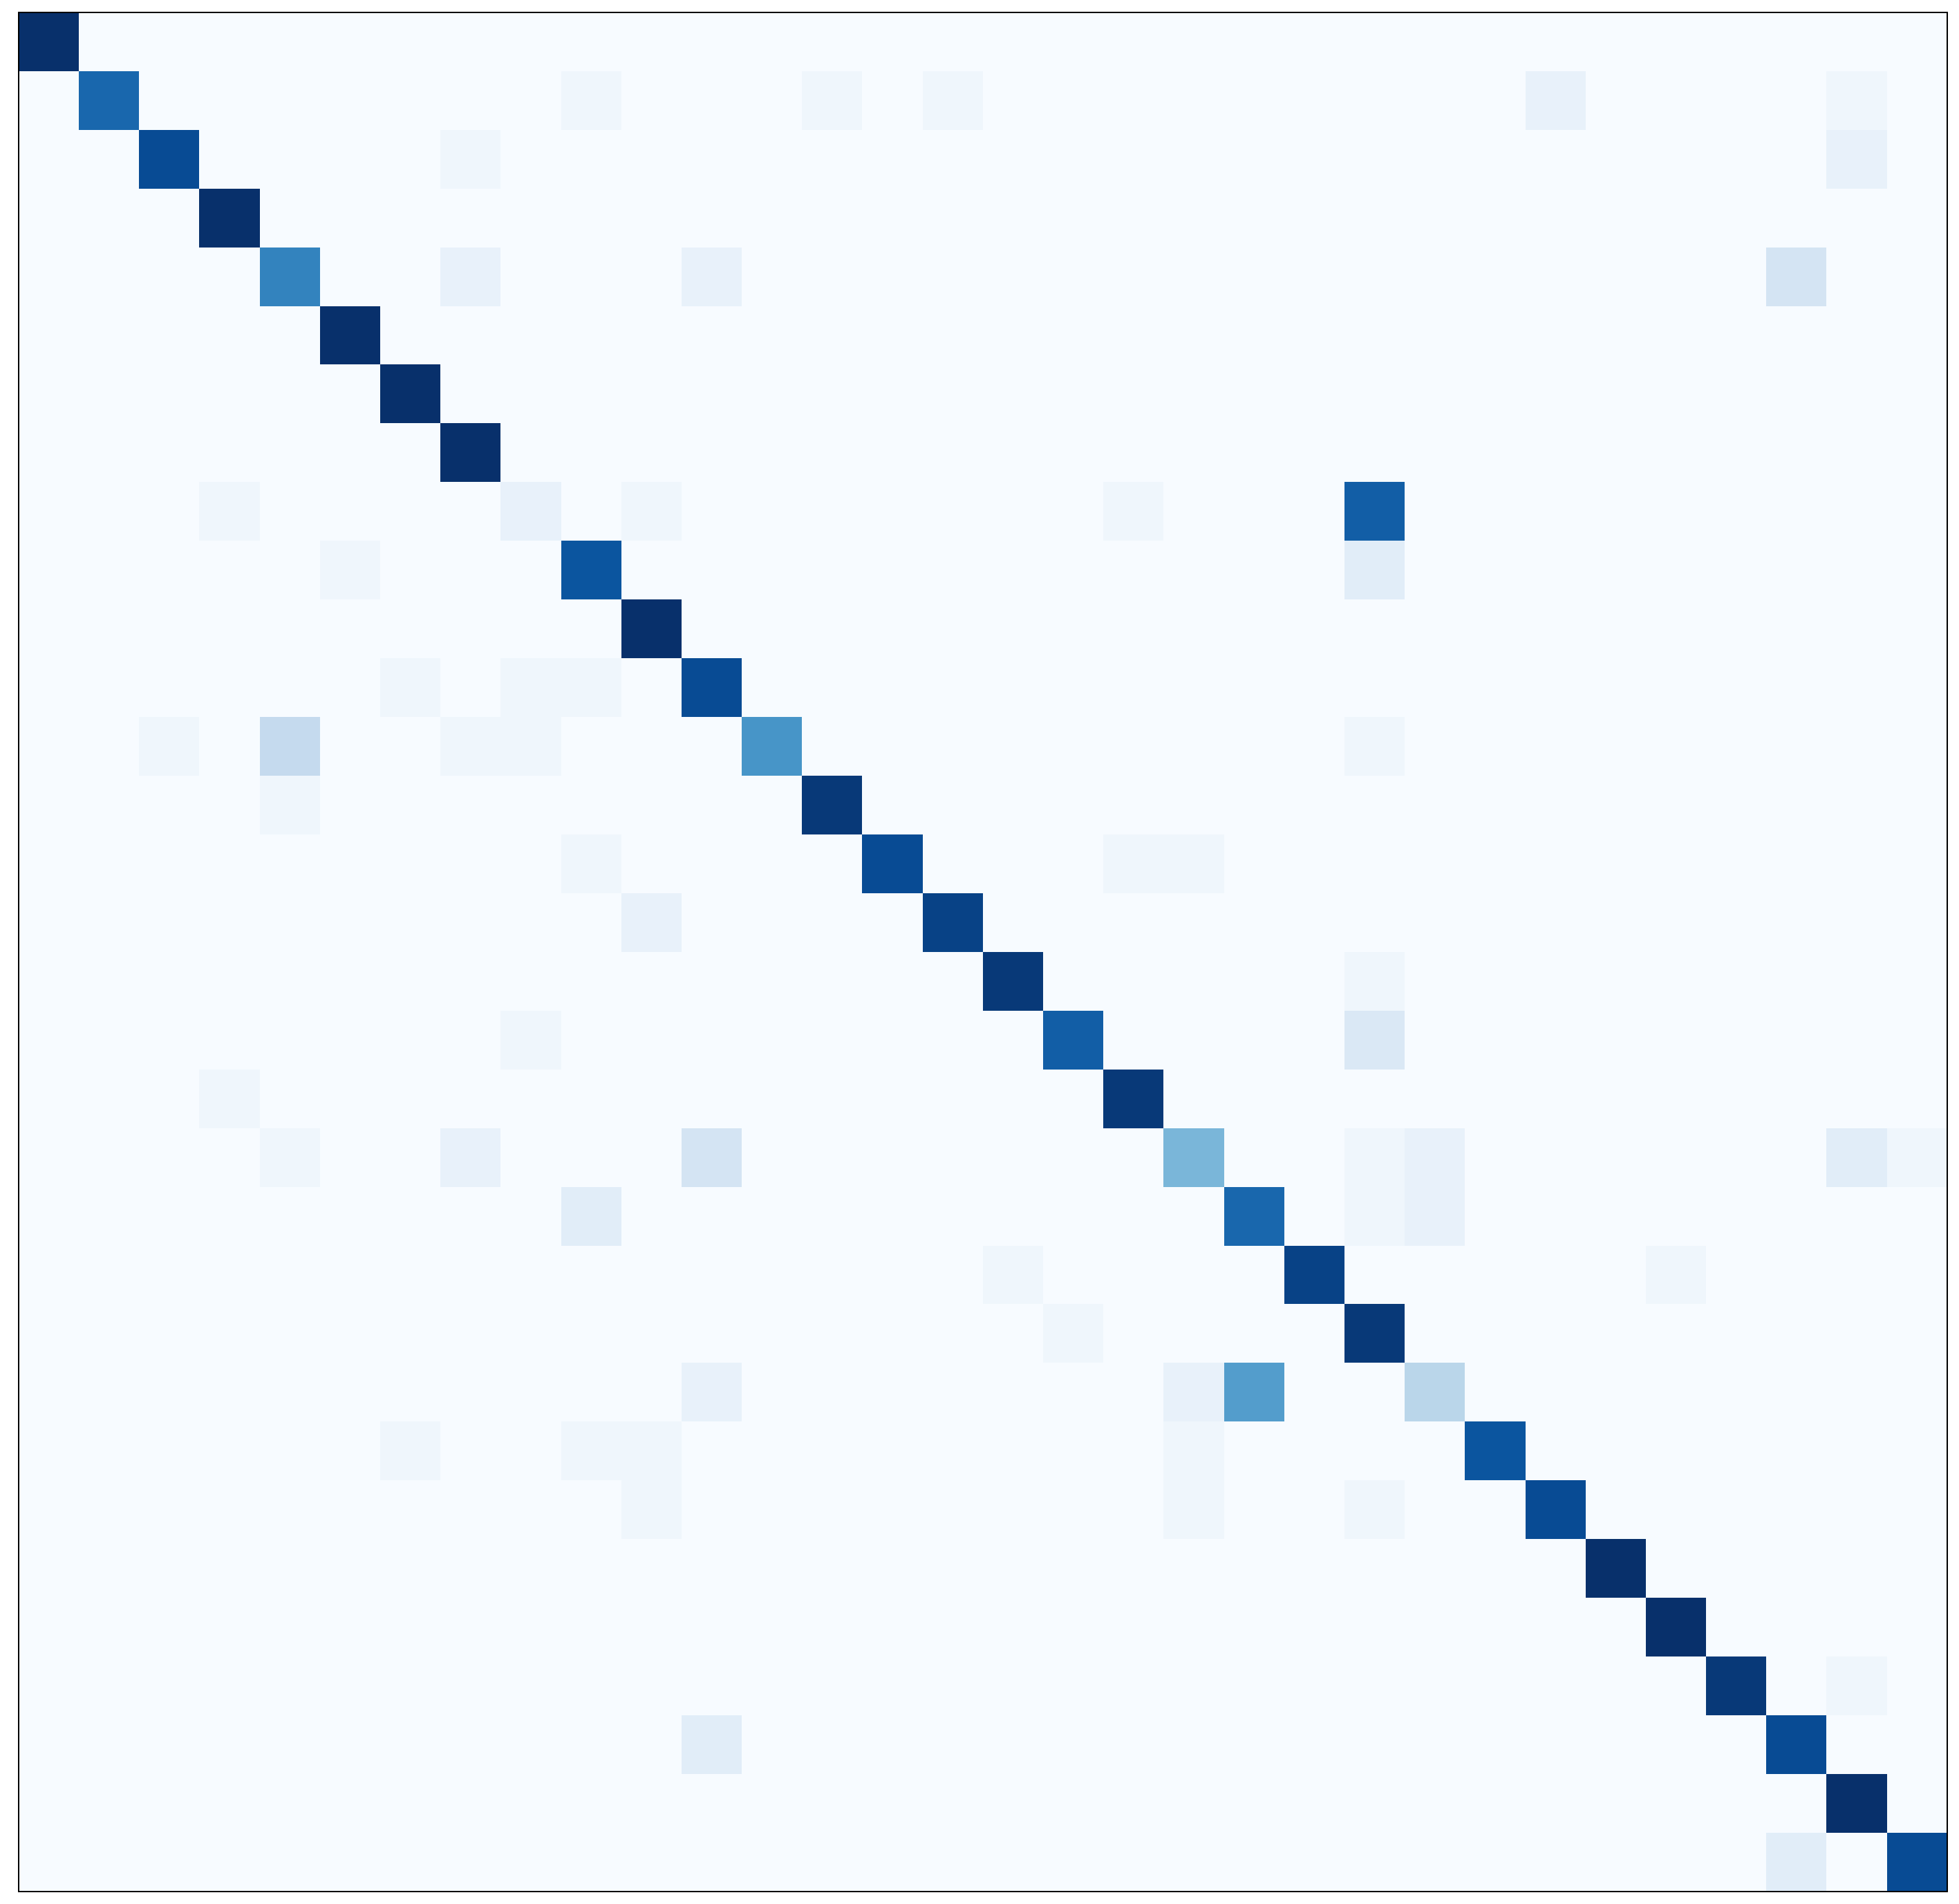

In [420]:
print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)


print("building and training the model")

clf.fit(X_huawei, y_huawei)
y_fossil_pred = clf.predict(X_fossil)

accuracy = metrics.accuracy_score(y_fossil, y_fossil_pred)
print("accuracy = ", accuracy)


title = "Confusion_matrix_train_with_Huawei(overtime)_test_with_Fossil_acc={:0.2f}".format(accuracy * 100)
saved_title = title.replace(".", "_").replace(" ", "_")
_ = plot_confusion_matrix(y_fossil, y_fossil_pred, title= title, figname = saved_title, CM_NO_LABELS=True)


In [421]:
f_name

['min_non_null',
 'mean_non_null',
 'max_non_null',
 'count_non_null',
 'std_non_null',
 'kurtosis_non_null',
 'min_outgoing',
 'mean_outgoing',
 'max_outgoing',
 'count_outgoing',
 'std_outgoing',
 'kurtosis_outgoing',
 'min_incoming',
 'mean_incoming',
 'max_incoming',
 'count_incoming',
 'std_incoming',
 'kurtosis_incoming',
 'min_unique_lengths',
 'mean_unique_lengths',
 'max_unique_lengths',
 'count_unique_lengths',
 'std_unique_lengths',
 'kurtosis_unique_lengths',
 'unique_lengths_46',
 'unique_lengths_47',
 'unique_lengths_48',
 'unique_lengths_49',
 'unique_lengths_50',
 'unique_lengths_51',
 'unique_lengths_52',
 'unique_lengths_53',
 'unique_lengths_54',
 'unique_lengths_55',
 'unique_lengths_56',
 'unique_lengths_57',
 'unique_lengths_58',
 'unique_lengths_59',
 'unique_lengths_60',
 'unique_lengths_61',
 'unique_lengths_62',
 'unique_lengths_63',
 'unique_lengths_64',
 'unique_lengths_65',
 'unique_lengths_66',
 'unique_lengths_67',
 'unique_lengths_68',
 'unique_lengths_69',
 'unique_lengths_70',
 'unique_lengths_71',
 'unique_lengths_72',
 'unique_lengths_73',
 'unique_lengths_74',
 'unique_lengths_75',
 'unique_lengths_76',
 'unique_lengths_77',
 'unique_lengths_78',
 'unique_lengths_79',
 'unique_lengths_80',
 'unique_lengths_81',
 'unique_lengths_82',
 'unique_lengths_83',
 'unique_lengths_84',
 'unique_lengths_85',
 'unique_lengths_86',
 'unique_lengths_87',
 'unique_lengths_88',
 'unique_lengths_89',
 'unique_lengths_90',
 'unique_lengths_91',
 'unique_lengths_92',
 'unique_lengths_93',
 'unique_lengths_94',
 'unique_lengths_95',
 'unique_lengths_96',
 'unique_lengths_97',
 'unique_lengths_98',
 'unique_lengths_99',
 'unique_lengths_100',
 'unique_lengths_101',
 'unique_lengths_102',
 'unique_lengths_103',
 'unique_lengths_104',
 'unique_lengths_105',
 'unique_lengths_106',
 'unique_lengths_107',
 'unique_lengths_108',
 'unique_lengths_109',
 'unique_lengths_110',
 'unique_lengths_111',
 'unique_lengths_112',
 'unique_lengths_113',
 'unique_lengths_114',
 'unique_lengths_115',
 'unique_lengths_116',
 'unique_lengths_117',
 'unique_lengths_118',
 'unique_lengths_119',
 'unique_lengths_120',
 'unique_lengths_121',
 'unique_lengths_122',
 'unique_lengths_123',
 'unique_lengths_124',
 'unique_lengths_125',
 'unique_lengths_126',
 'unique_lengths_127',
 'unique_lengths_128',
 'unique_lengths_129',
 'unique_lengths_130',
 'unique_lengths_131',
 'unique_lengths_132',
 'unique_lengths_133',
 'unique_lengths_134',
 'unique_lengths_135',
 'unique_lengths_136',
 'unique_lengths_137',
 'unique_lengths_138',
 'unique_lengths_139',
 'unique_lengths_140',
 'unique_lengths_141',
 'unique_lengths_142',
 'unique_lengths_143',
 'unique_lengths_144',
 'unique_lengths_145',
 'unique_lengths_146',
 'unique_lengths_147',
 'unique_lengths_148',
 'unique_lengths_149',
 'unique_lengths_150',
 'unique_lengths_151',
 'unique_lengths_152',
 'unique_lengths_153',
 'unique_lengths_154',
 'unique_lengths_155',
 'unique_lengths_156',
 'unique_lengths_157',
 'unique_lengths_158',
 'unique_lengths_159',
 'unique_lengths_160',
 'unique_lengths_161',
 'unique_lengths_162',
 'unique_lengths_163',
 'unique_lengths_164',
 'unique_lengths_165',
 'unique_lengths_166',
 'unique_lengths_167',
 'unique_lengths_168',
 'unique_lengths_169',
 'unique_lengths_170',
 'unique_lengths_171',
 'unique_lengths_172',
 'unique_lengths_173',
 'unique_lengths_174',
 'unique_lengths_175',
 'unique_lengths_176',
 'unique_lengths_177',
 'unique_lengths_178',
 'unique_lengths_179',
 'unique_lengths_180',
 'unique_lengths_181',
 'unique_lengths_182',
 'unique_lengths_183',
 'unique_lengths_184',
 'unique_lengths_185',
 'unique_lengths_186',
 'unique_lengths_187',
 'unique_lengths_188',
 'unique_lengths_189',
 'unique_lengths_190',
 'unique_lengths_191',
 'unique_lengths_192',
 'unique_lengths_193',
 'unique_lengths_194',
 'unique_lengths_195',
 'unique_lengths_196',
 'unique_lengths_197',
 'unique_lengths_198',
 'unique_lengths_199',
 'unique_lengths_200',
 'unique_leng

### Filtering!

building and training the model for cross validation 
building and training a model for confusion matrix
495  features removed
accuracy =  0.859375
Saved image ./plots/Confusion_matrix_train_with_Huawei(overtime)_test_with_Fossil_acc=85_94.png
Saved image ./plots/Confusion_matrix_train_with_Huawei(overtime)_test_with_Fossil_acc=85_94_nolabels.png


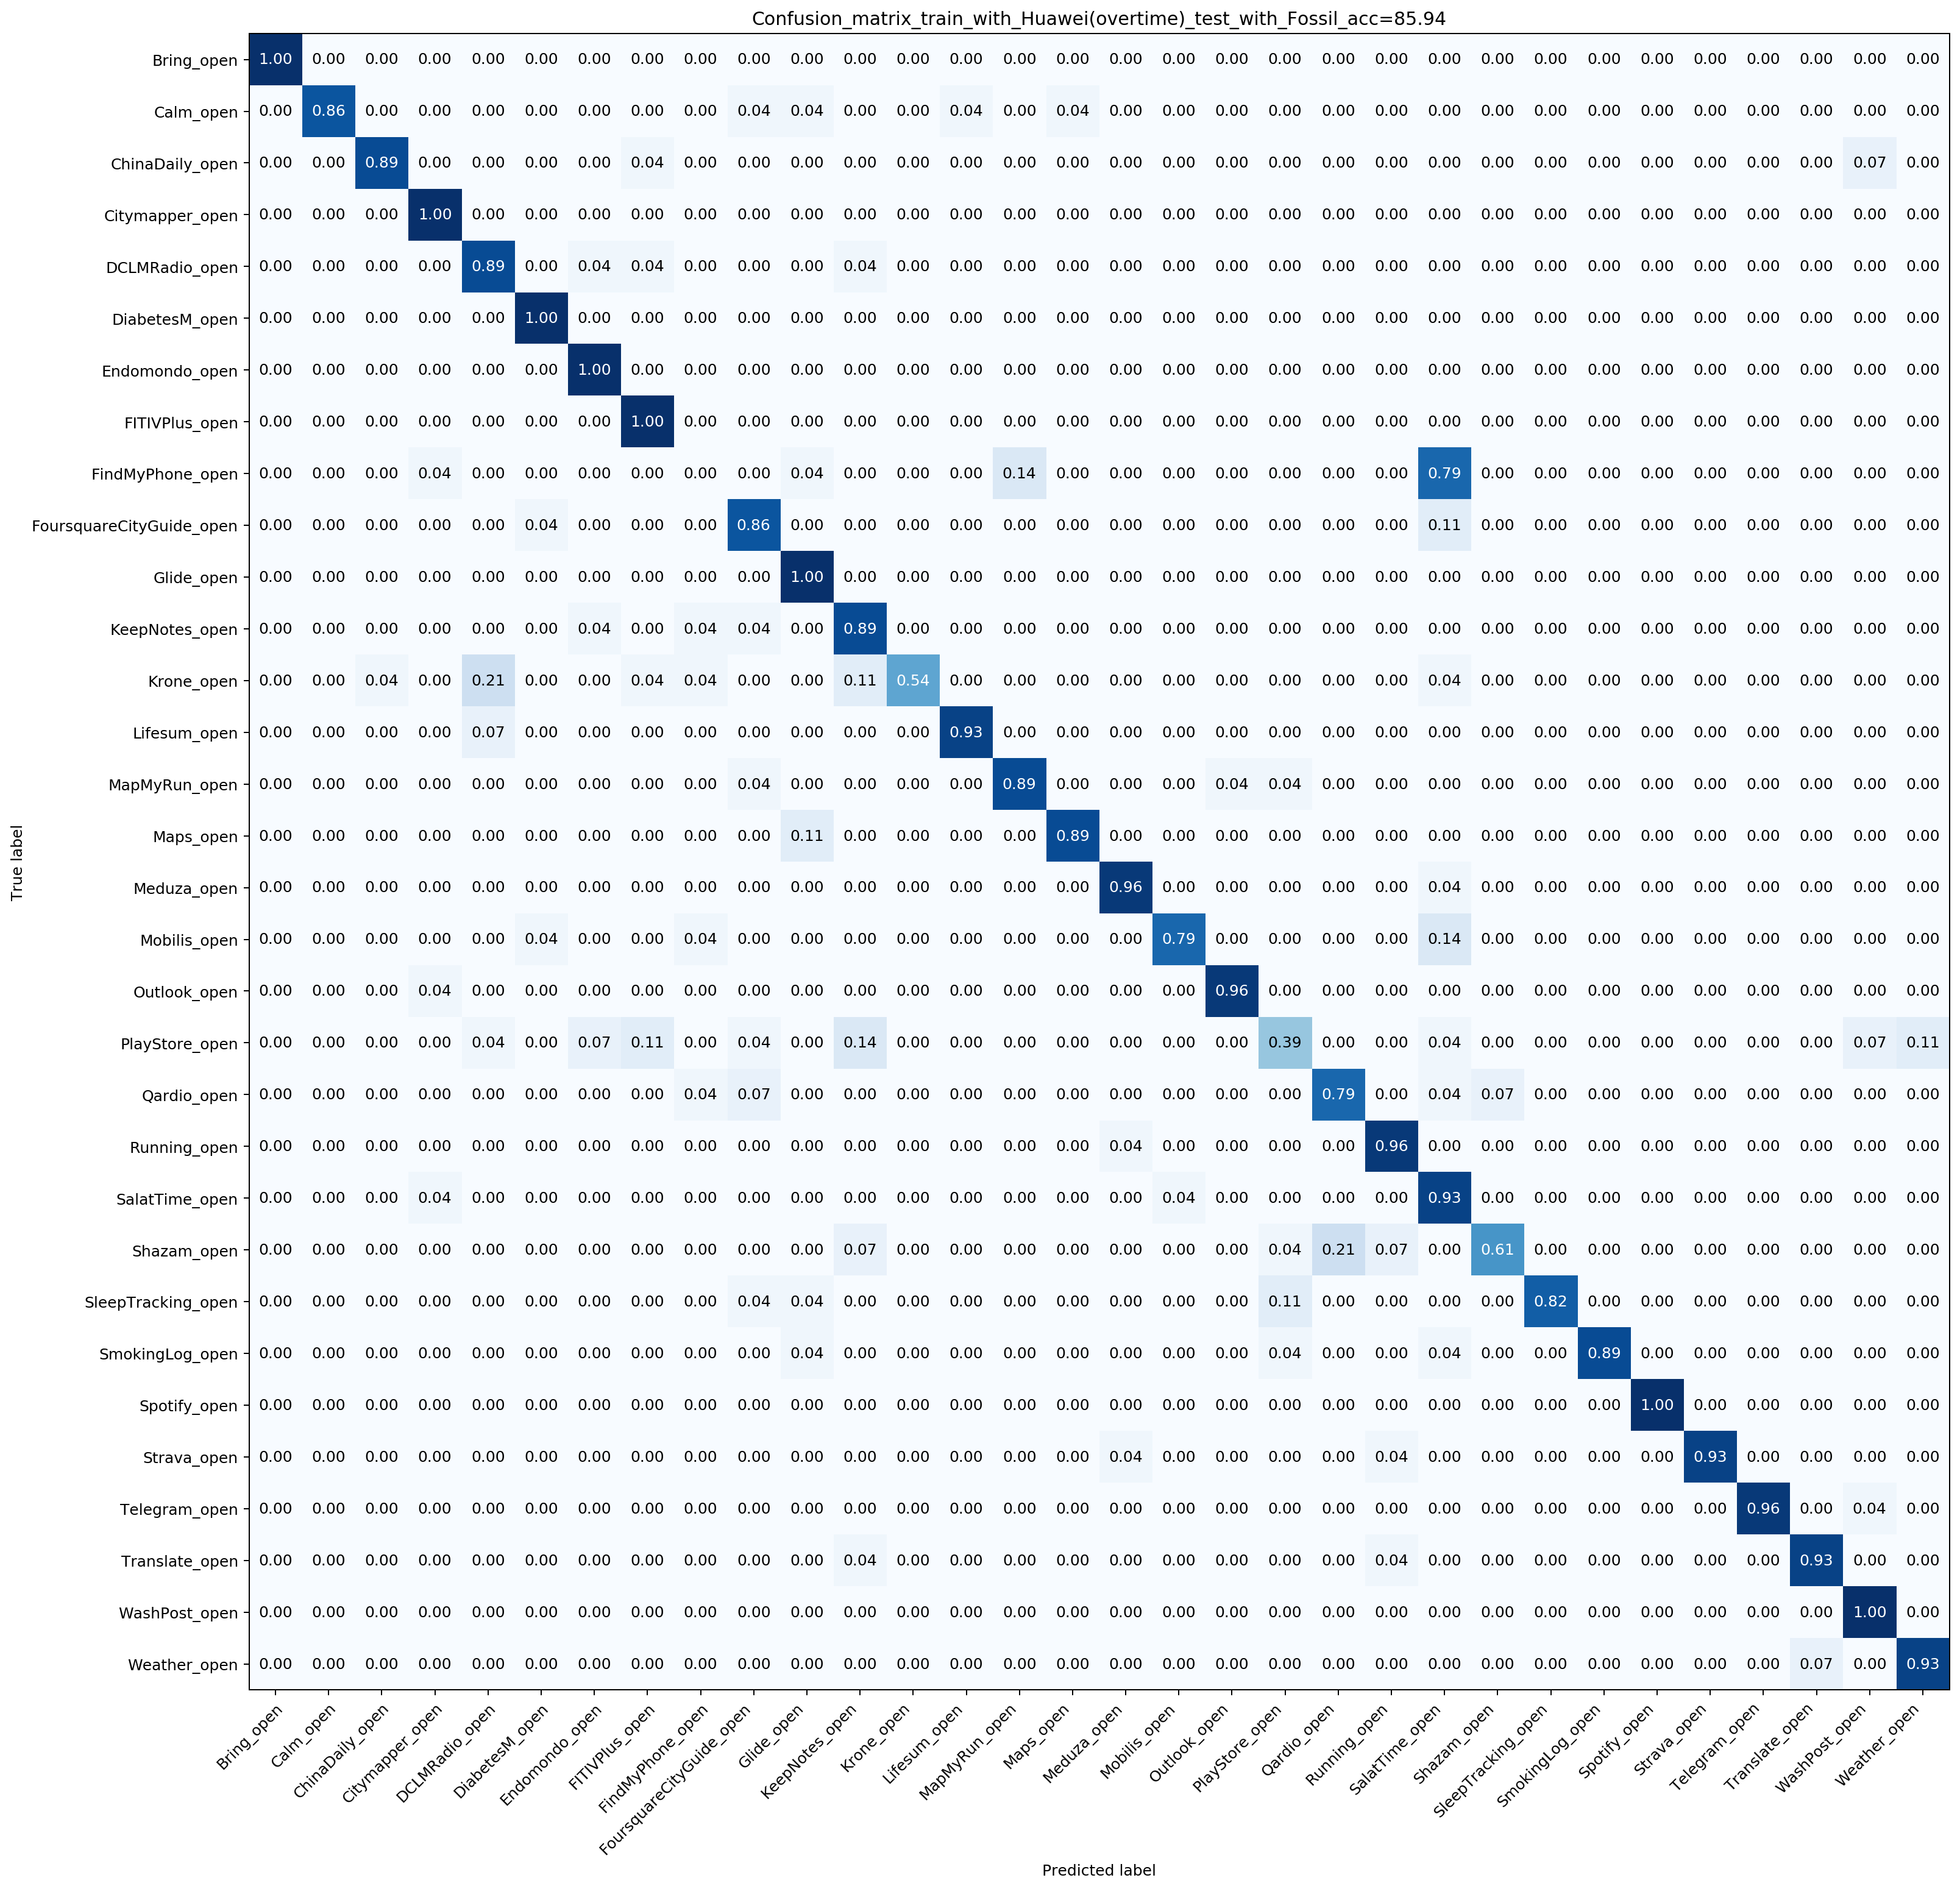

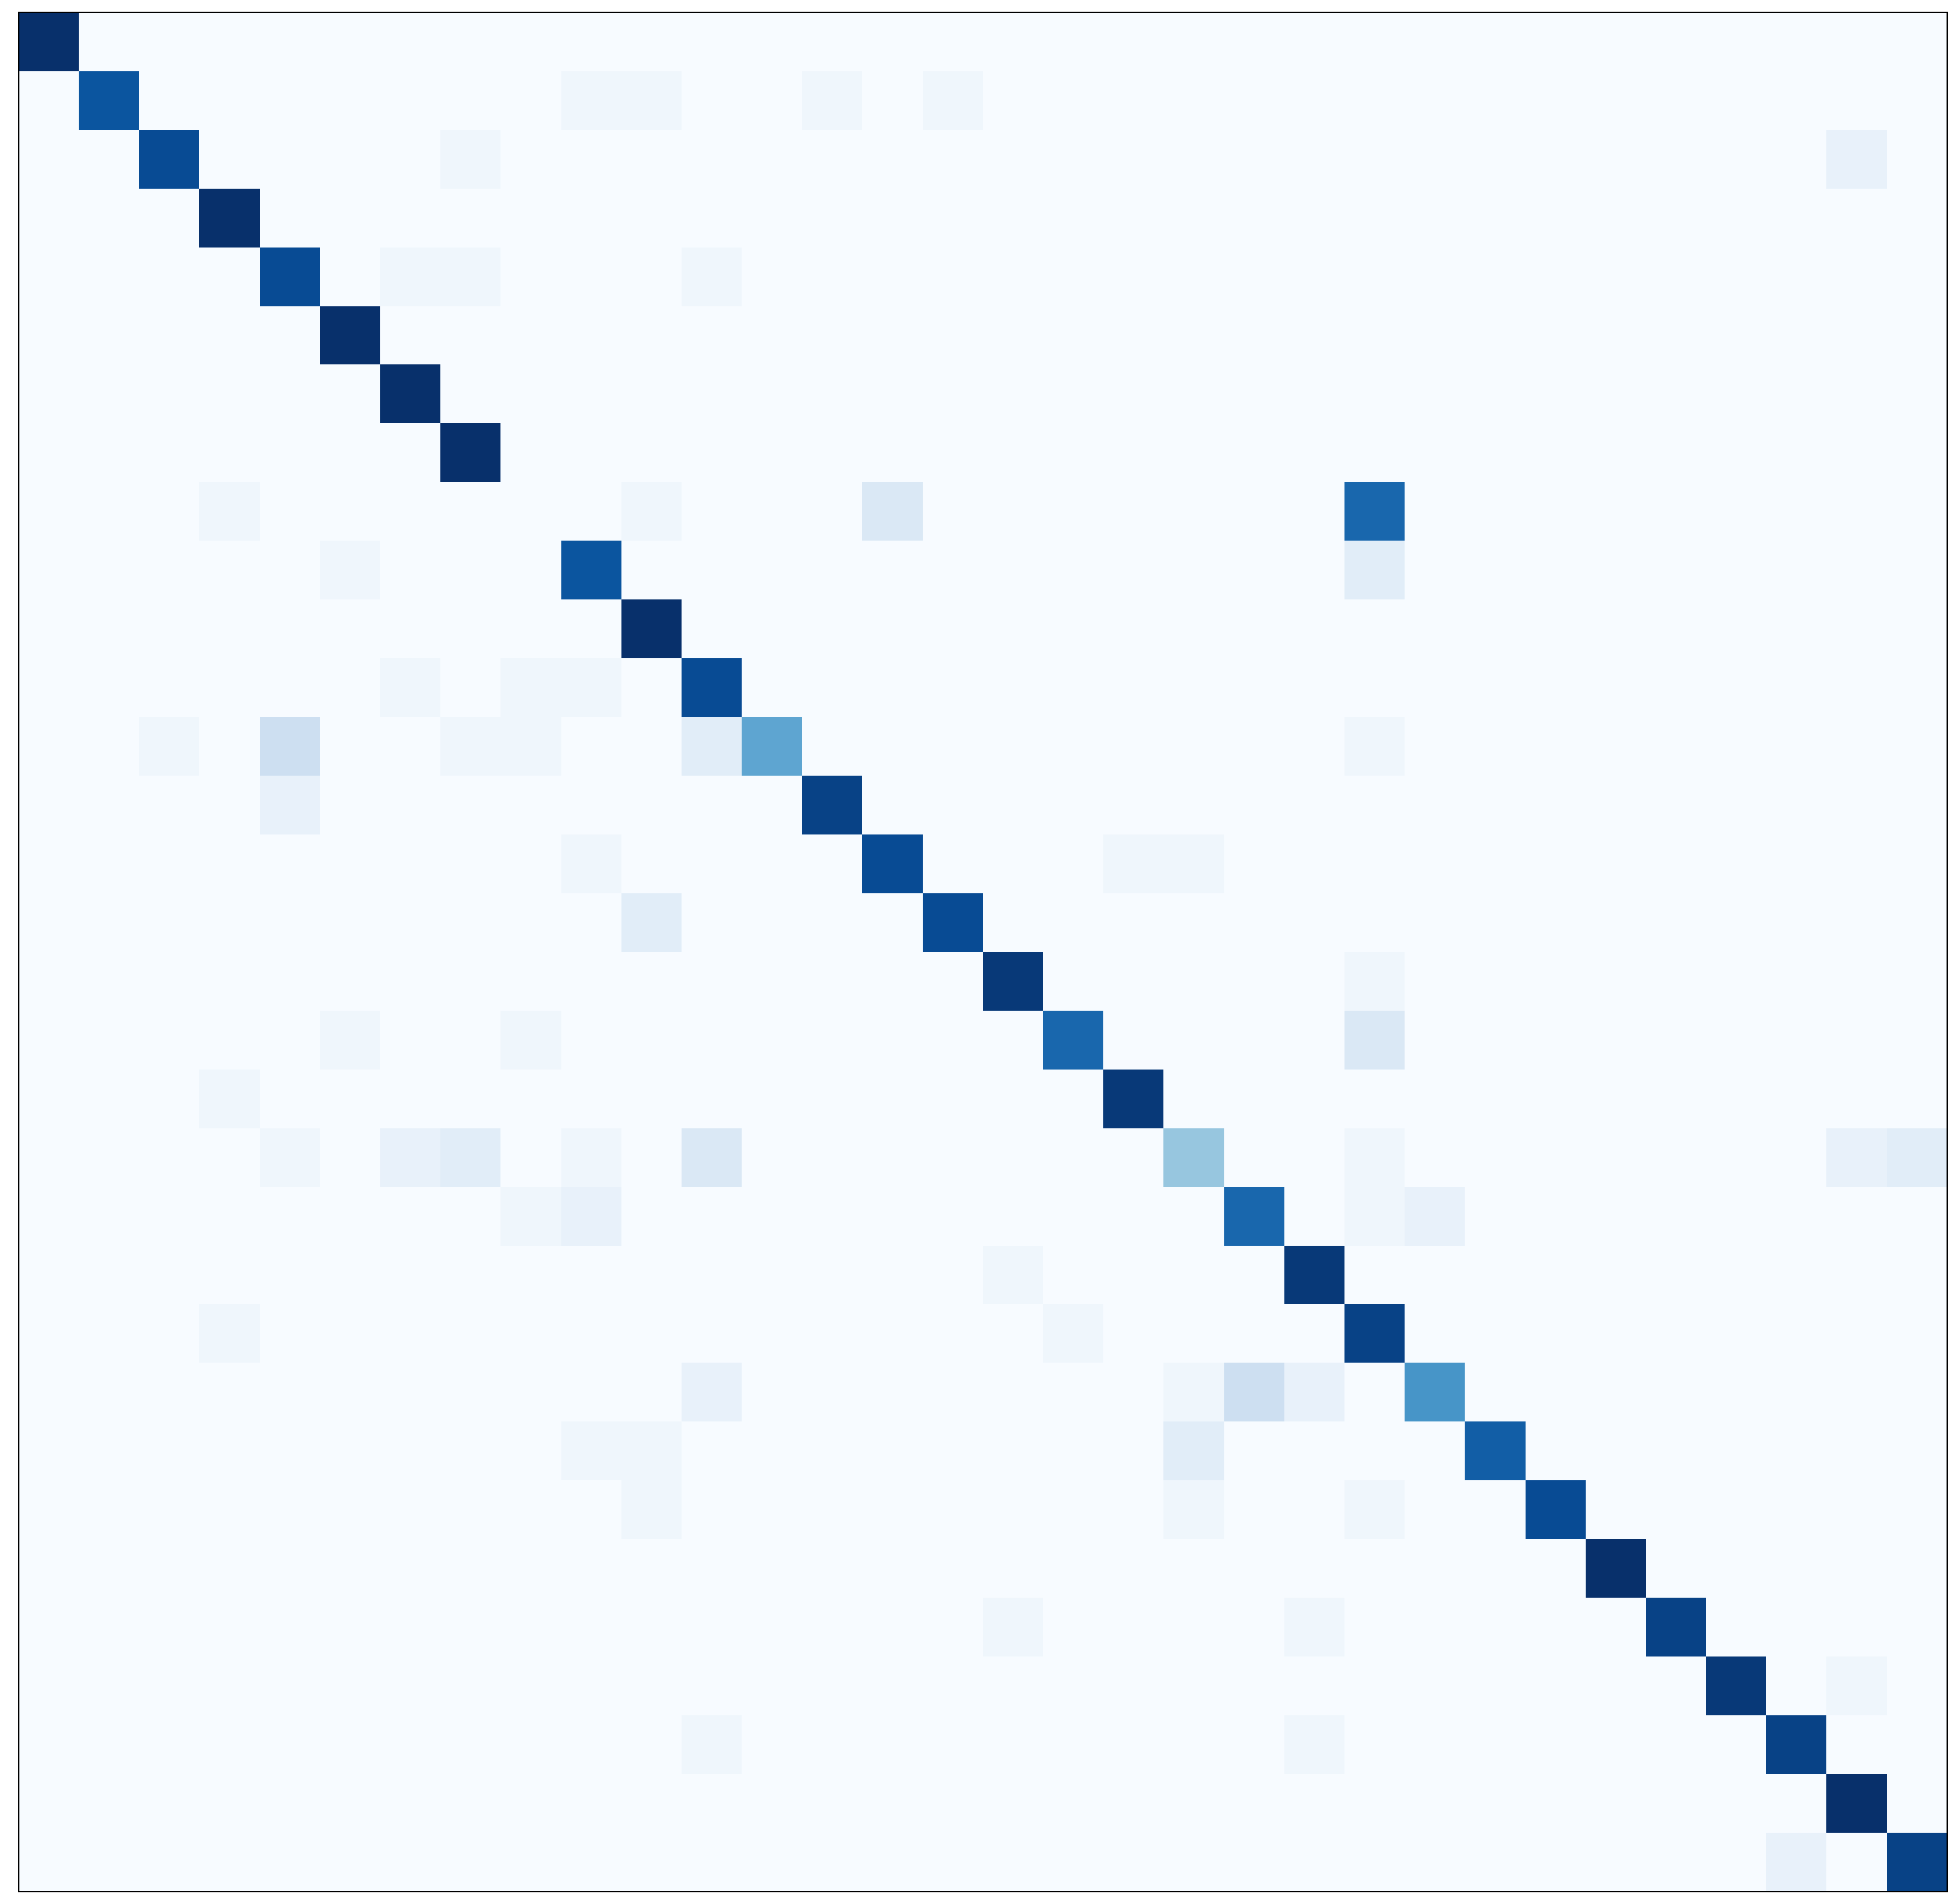

In [414]:
print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)


print("building and training a model for confusion matrix")

clf.fit(X_huawei, y_huawei)

features_importance = clf.feature_importances_
feat_importance_filter = 0.0000


to_withdraw = np.where(features_importance<=feat_importance_filter)[0]
to_withdraw_extra = np.where(f_name == "min_x_deltas")[0]
#indices_uniques = np.array([i for i, n in enumerate(f_name_filtered) if not n.startswith("unique_lengths")])
to_withdraw = np.append(to_withdraw, to_withdraw_extra)

X_huawei_filtered, f_name_filtered = feat_filter(X_huawei, f_name, to_withdraw)
X_fossil_filtered, f_name_filtered = feat_filter(X_fossil, f_name, to_withdraw)

print(len(f_name) - len(f_name_filtered), " features removed")

clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_huawei_filtered, y_huawei)



y_fossil_pred = clf.predict(X_fossil_filtered)

accuracy = metrics.accuracy_score(y_fossil, y_fossil_pred)
print("accuracy = ", accuracy)


title = "Confusion_matrix_train_with_Huawei(overtime)_test_with_Fossil_acc={:0.2f}".format(accuracy * 100)
saved_title = title.replace(".", "_").replace(" ", "_")
_ = plot_confusion_matrix(y_fossil, y_fossil_pred, title= title, figname = saved_title, CM_NO_LABELS=True)


In [327]:
for i in f_name_filtered:
    print(i)
    print(i.endswith("56"))

mean_non_null
False
max_non_null
False
count_non_null
False
std_non_null
False
kurtosis_non_null
False
min_outgoing
False
mean_outgoing
False
max_outgoing
False
count_outgoing
False
std_outgoing
False
kurtosis_outgoing
False
min_incoming
False
mean_incoming
False
max_incoming
False
count_incoming
False
std_incoming
False
kurtosis_incoming
False
min_x_deltas
False
mean_x_deltas
False
max_x_deltas
False
count_x_deltas
False
std_x_deltas
False
kurtosis_x_deltas
False
min_x_deltas_no_zeros
False
mean_x_deltas_no_zeros
False
max_x_deltas_no_zeros
False
count_x_deltas_no_zeros
False
std_x_deltas_no_zeros
False
kurtosis_x_deltas_no_zeros
False
mean_unique_lengths
False
max_unique_lengths
False
std_unique_lengths
False
kurtosis_unique_lengths
False
unique_lengths_46
False
unique_lengths_48
False
unique_lengths_50
False
unique_lengths_51
False
unique_lengths_52
False
unique_lengths_54
False
unique_lengths_55
False
unique_lengths_56
True
unique_lengths_57
False
unique_lengths_58
False
unique_len

In [412]:
#def f_name_filtered = np.array(f_name_filtered):
feature_importances = clf.feature_importances_
indices_uniques = np.array([i for i, n in enumerate(f_name_filtered) if n.startswith("unique_lengths")])
indices_deltas = np.array([i for i, n in enumerate(f_name_filtered) if "deltas" in n])
indices_non_zeros = np.array([i for i, n in enumerate(f_name_filtered) if "deltas" in n])
indices_zeros = np.array([i for i, n in enumerate(f_name_filtered) if n.endswith("deltas") ])
indices_mean = np.array([i for i, n in enumerate(f_name_filtered) if "mean" in n])
indices_kurtosis = np.array([i for i, n in enumerate(f_name_filtered) if "kurtosis" in n])
indices_count = np.array([i for i, n in enumerate(f_name_filtered) if "count" in n])
indices_min = np.array([i for i, n in enumerate(f_name_filtered) if "min" in n])
indices_max = np.array([i for i, n in enumerate(f_name_filtered) if "max" in n])
indices_std = np.array([i for i, n in enumerate(f_name_filtered) if "std" in n])
indices_incoming = np.array([i for i, n in enumerate(f_name_filtered) if "incoming" in n])
indices_outgoing = np.array([i for i, n in enumerate(f_name_filtered) if "outgoing" in n])


In [413]:
print(np.sum(feature_importances[indices_uniques]), " unique importances")
print(np.sum(feature_importances[indices_deltas]), " deltas importances" ) 
print(np.sum(feature_importances[indices_non_zeros]), " non_zeros")
print(np.sum(feature_importances[indices_zeros]), " zeros")
print(np.sum(feature_importances[indices_mean]), " mean")
print(np.sum(feature_importances[indices_kurtosis]), " kutosis")
print(np.sum(feature_importances[indices_count]), " count")
print(np.sum(feature_importances[indices_min]), " min")
print(np.sum(feature_importances[indices_max]), " max")
print(np.sum(feature_importances[indices_std]), " std")
print(np.sum(feature_importances[indices_incoming]), " incoming")
print(np.sum(feature_importances[indices_outgoing]), " outgoing")

0.43000346614846785  unique importances
0.0048163221677001555  deltas importances
0.0048163221677001555  non_zeros


IndexError: arrays used as indices must be of integer (or boolean) type

In [374]:
indices_uniques_all = np.array([i for i, n in enumerate(f_name) if n.startswith("unique_lengths")])
print("number of unique lengths cut off: ", len(indices_uniques_all) - len(indices_uniques))

number of unique lengths cut off:  495


In [352]:
np.where(f_name_filtered == "unique_lengths_543")

(array([311]),)

We did not kept only go higher than 0% to filter out otherwise, it could delete a unique length and could hurt accuracy of a specific class percent of the

In [348]:
indices_sorted = np.argsort(feature_importances[indices_uniques])
f_name_filtered[indices_uniques][indices_sorted][::-1]


array(['unique_lengths_1005', 'unique_lengths_333', 'unique_lengths_537',
       'unique_lengths_54', 'unique_lengths_195', 'unique_lengths_106',
       'unique_lengths_261', 'unique_lengths_198', 'unique_lengths_254',
       'unique_lengths_670', 'unique_lengths_702', 'unique_lengths_148',
       'unique_lengths_111', 'unique_lengths_279', 'unique_lengths_274',
       'unique_lengths_312', 'unique_lengths_112', 'unique_lengths_207',
       'unique_lengths_870', 'unique_lengths_194', 'unique_lengths_306',
       'unique_lengths_714', 'unique_lengths_156', 'unique_lengths_266',
       'unique_lengths_200', 'unique_lengths_267', 'unique_lengths_188',
       'unique_lengths_861', 'unique_lengths_366', 'unique_lengths_348',
       'unique_lengths_122', 'unique_lengths_560', 'unique_lengths_150',
       'unique_lengths_171', 'unique_lengths_63', 'unique_lengths_72',
       'unique_lengths_918', 'unique_lengths_174', 'unique_lengths_178',
       'unique_lengths_165', 'unique_lengths_158', 'u

In [406]:
feature_importances



array([4.44942224e-03, 7.36227354e-03, 1.04313437e-02, 4.70059555e-03,
       4.62226852e-03, 1.94764529e-02, 2.28666180e-02, 2.30054110e-02,
       1.49156215e-02, 2.21221893e-02, 1.02738133e-02, 1.39363669e-02,
       3.18720933e-02, 3.35285743e-02, 2.50621638e-02, 2.99262764e-02,
       1.91560809e-02, 1.04333423e-02, 3.57174689e-03, 1.08385823e-02,
       1.16993932e-02, 1.22319651e-02, 6.52951844e-03, 1.13352404e-02,
       1.66330197e-02, 1.16304934e-02, 1.51131217e-02, 1.13050480e-02,
       1.69191557e-02, 1.32234493e-02, 1.65860276e-02, 9.28699031e-03,
       2.23508759e-04, 2.35186385e-03, 1.71245619e-03, 3.87992660e-03,
       4.64058271e-03, 1.33416500e-02, 7.63514281e-06, 3.04505924e-03,
       3.07089757e-03, 3.89128802e-03, 6.37635272e-04, 4.42305321e-03,
       2.29624528e-05, 2.39772224e-03, 9.66719967e-06, 4.29717172e-04,
       4.66545608e-03, 7.67386734e-04, 1.15364312e-06, 1.46945442e-04,
       1.51715118e-05, 6.20321318e-04, 6.19327250e-06, 1.57623212e-03,
      

In [407]:
top_unique = np.argsort()

TypeError: _argsort_dispatcher() missing 1 required positional argument: 'a'

In [408]:

print("trop unique indices: ")

trop unique indices: 


In [315]:
print(np.sum(feature_importances[indices_uniques]), " unique importances")
print(np.sum(feature_importances[indices_deltas]), " deltas importances" ) 
print(np.sum(feature_importances[indices_non_zeros]), " non_zeros")
print(np.sum(feature_importances[indices_mean]), " mean")
print(np.sum(feature_importances[indices_kurtosis]), " kutosis")
print(np.sum(feature_importances[indices_count]), " count")
print(np.sum(feature_importances[indices_min]), " min")
print(np.sum(feature_importances[indices_max]), " max")

0.5855247299397182  unique importances
0.11855779935402402  deltas importances
0.06965973763222662  non_zeros
0.09464454794263158  mean
0.0627889703807938  kutosis
0.07518110390429271  count
0.17976602515476034  min
0.09842894695915588  max


In [ ]:
np.sum()

Removing not usefull features while training with both

In [ ]:
print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)

# Test accuracy when removing all worse params
features_importance = clf_2watch.feature_importances_
zeros_importance = np.argwhere(features_importance == 0).flatten().tolist()

features_importance

sys.exit(1)
not_unique_length = [i for i, n in enumerate(f_name) if not "unique" in n]
to_remove = zeros_importance + not_unique_length

X_huawei, feature_names = feat_filter(X_huawei, feature_names, FILTER_FEATURE)


print("building and training a model for confusion matrix")



clf.fit(X_huawei, y_huawei)
y_fossil_pred = clf.predict(X_fossil)

accuracy = metrics.accuracy_score(y_fossil, y_fossil_pred)
print("accuracy = ", accuracy)


# Removing all features that has no importance
evaluate(DATA_PATH, FILTER_FEATURE=to_remove)

<a id='tfth'></a>
#### Train with Fossil, test with Huawei
[Table of Content](#tc)

building and training the model for cross validation 
building and training a model for confusion matrix
accuracy =  0.8537946428571429
Saved image ./plots/Confusion_matrix_train_with_Fossil_test_with_Huawei(overtime)_acc=85_38.png
Saved image ./plots/Confusion_matrix_train_with_Fossil_test_with_Huawei(overtime)_acc=85_38_nolabels.png


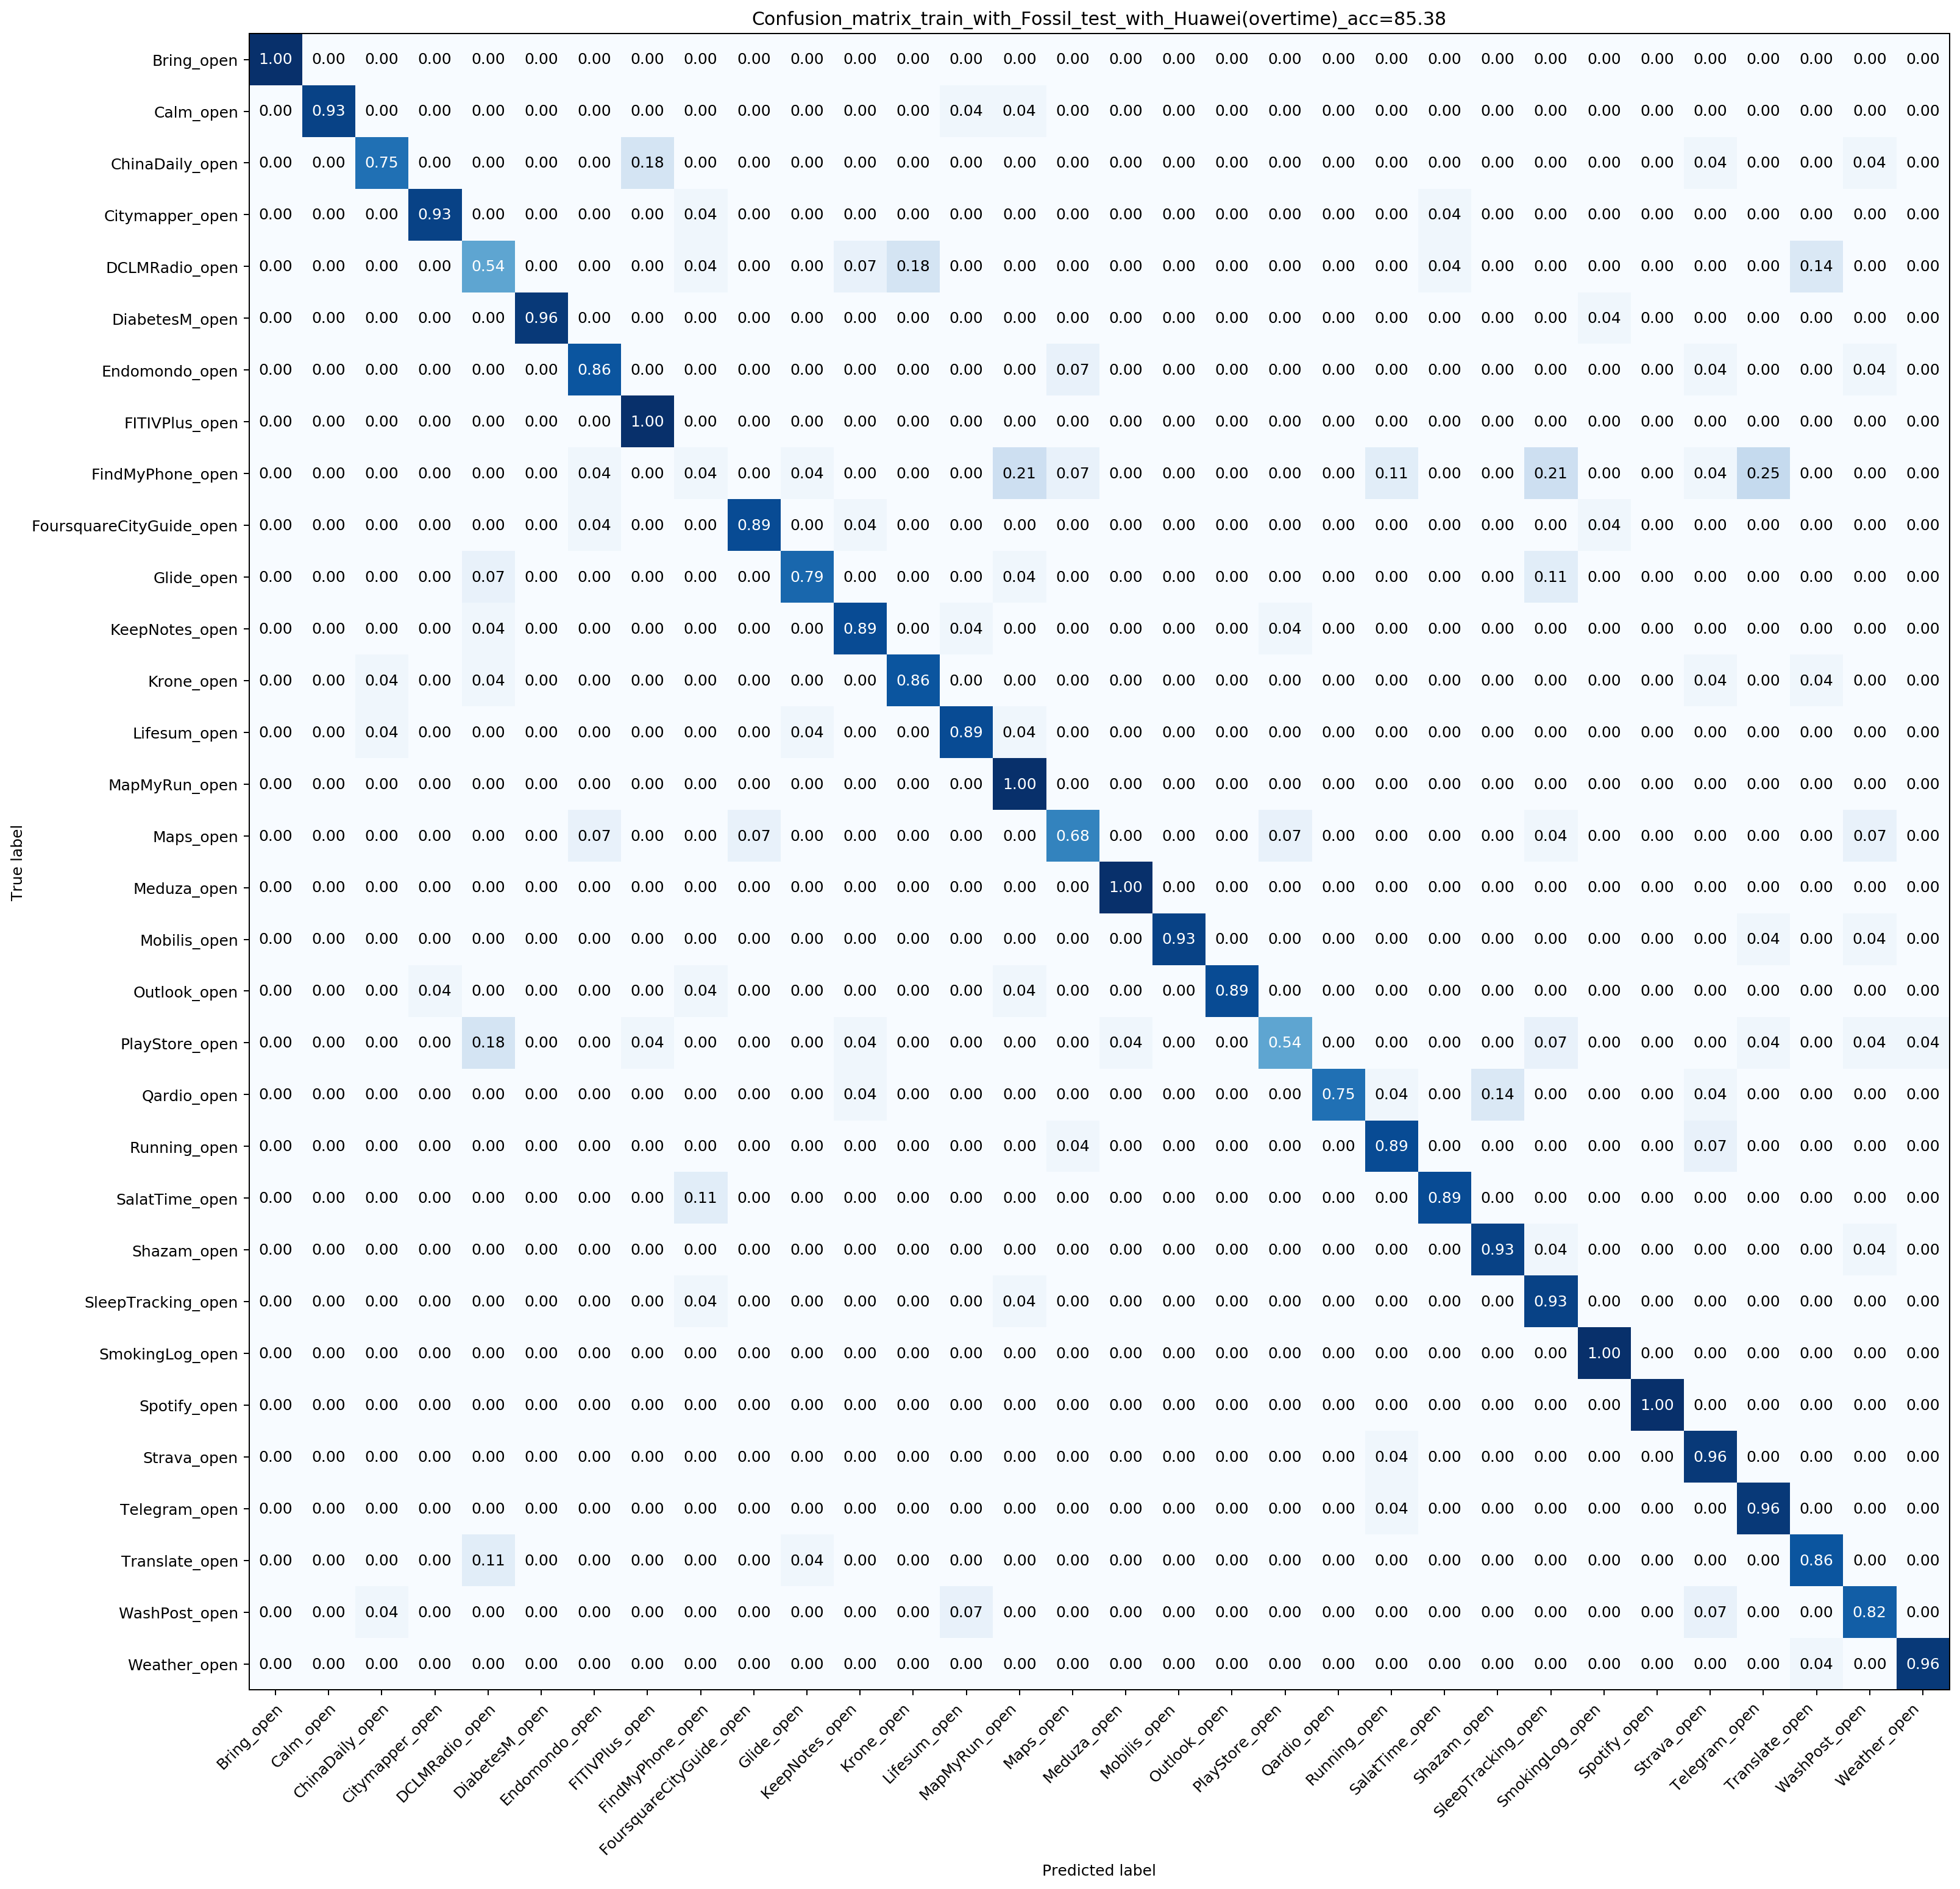

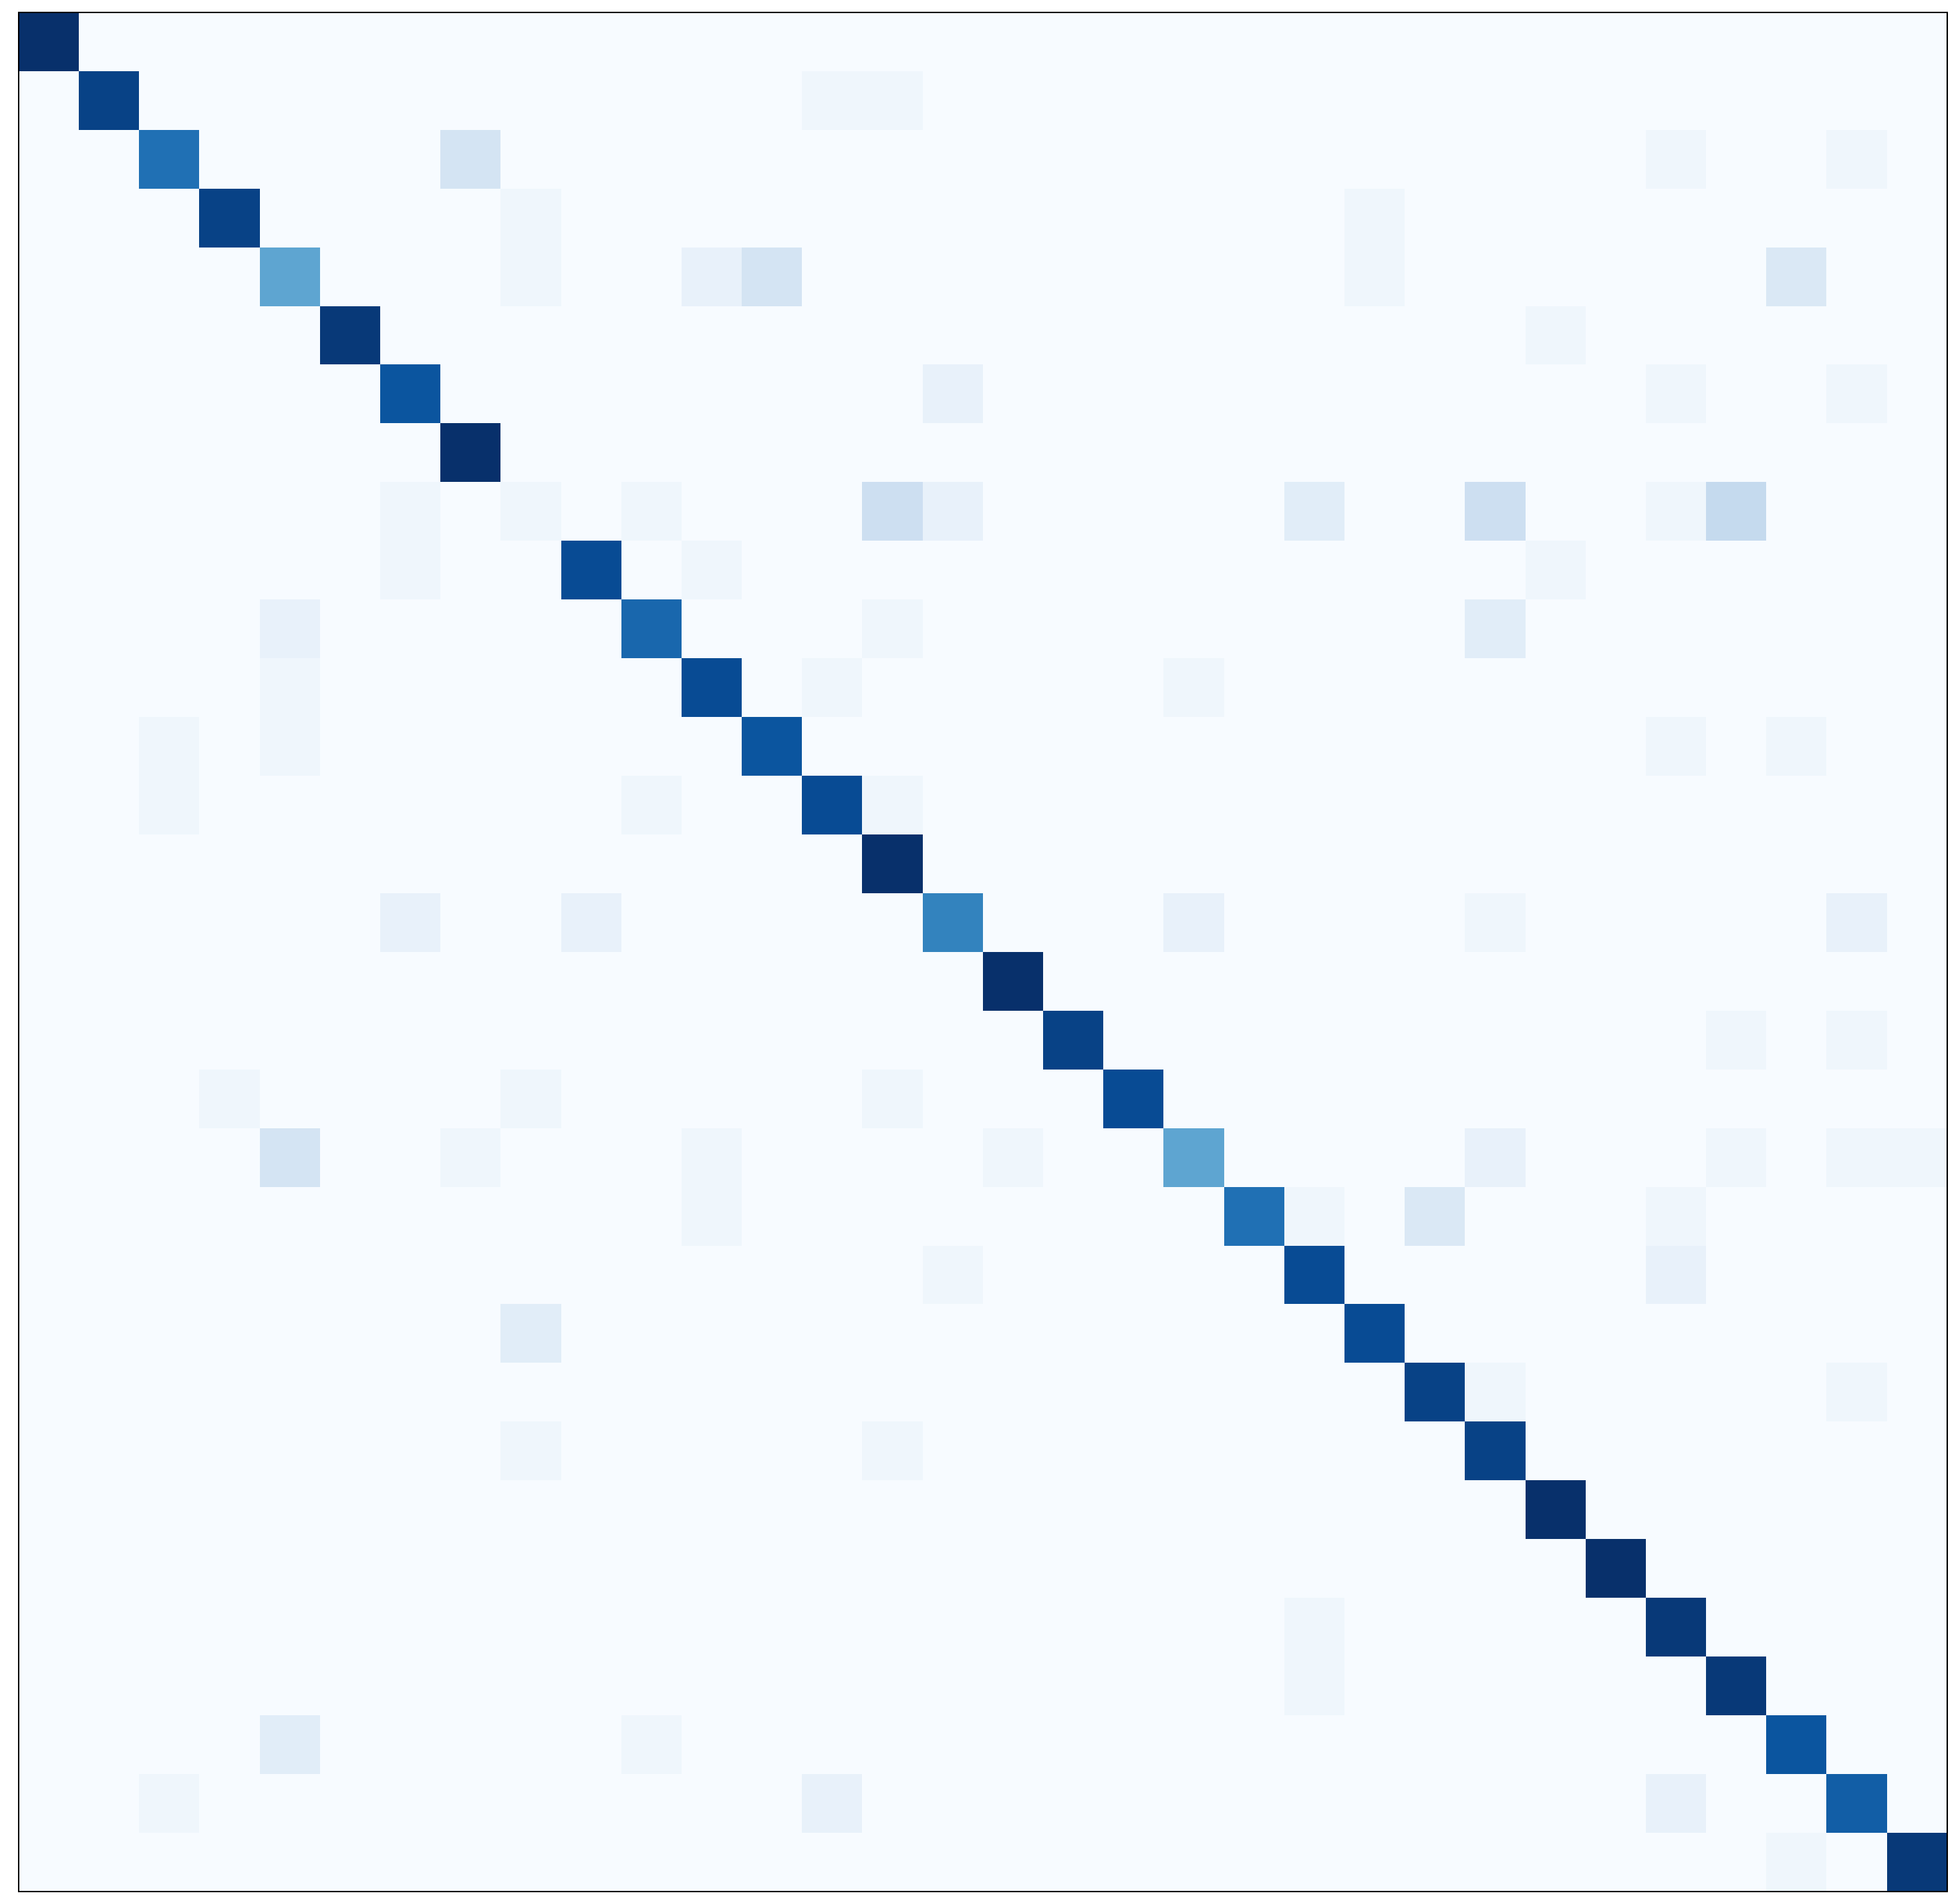

In [405]:
print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)


print("building and training a model for confusion matrix")
#X_fossil, y_fossil = shuffle(X_fossil, y_fossil)
clf.fit(X_fossil, y_fossil)
y_huawei_pred = clf.predict(X_huawei)
accuracy = metrics.accuracy_score(y_huawei, y_huawei_pred)
print("accuracy = ", accuracy)



title = "Confusion_matrix_train_with_Fossil_test_with_Huawei(overtime)_acc={:0.2f}".format(accuracy * 100)
saved_title = title.replace(".", "_").replace(" ", "_")
_ = plot_confusion_matrix(y_huawei, y_huawei_pred, title= title, figname = saved_title, CM_NO_LABELS=True)

<a id="capa_tr"></a>
### Capacity for Transferability
[Table of Content](#tc)

<a id="setup_captr"></a>
#### Setup

In [ ]:
# Assumption: We do not need to rebuild the dataset

DATA_PATH = ["data/fossil/open-6/", "data/huawei/open-6/"] #, "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
DISCARD = [] # ["FindMyPhone_open", "Running_open", "Strava_open"]
equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, PRINT_COUNT=False, RETURN_EQUILIBRATE_EVENTS=True)


equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]



In [ ]:
# Assumption: We do not need to rebuild the dataset

DATA_PATH = ["data/fossil/open-6/", "data/huawei/open-6/"] #, "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
DISCARD = [] # ["FindMyPhone_open", "Running_open", "Strava_open"]
equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, PRINT_COUNT=False, RETURN_EQUILIBRATE_EVENTS=True)


equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]

print("building features")
X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei)
X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil)



<a id="decrease_nb_features"></a>
#### Decrease number of features
[Table of Content](#tc)

Using shap value with the dataset containing both watches

Using bins for unique length 

In [ ]:
tfossil_repeat = 25
n_samples_tfossil_feat = n_samples = []
accuracies_tfossil_feat = n_samples = []


for i in range(109, 1, -3):
    print("launching i=", i, " experiment")
    for _ in range(tfossil_repeat):
        
        X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei, unique_from=i)
        X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil, unique_from=i)
        
        clf=RandomForestClassifier(n_estimators=200, random_state=None)
        clf.fit(X_fossil, y_fossil)
        y_pred = clf.predict(X_huawei)
        accuracy = metrics.accuracy_score(y_huawei, y_pred)
        print(accuracy)
        n_samples_tfossil_feat.append(i)
        accuracies_tfossil_feat.append(accuracy)



In [ ]:
thuawei_repeat = 5
n_samples_thuawei_feat = n_samples = []
accuracies_thuawei_feat = n_samples = []


for i in range(109, 1, -3):
    print("launching i=", i, " experiment")
    for _ in range(thuawei_repeat):
        
        X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei, unique_from=i)
        X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil, unique_from=i)
        
        clf=RandomForestClassifier(n_estimators=200, random_state=None)
        clf.fit(X_huawei, y_huawei)
        y_pred = clf.predict(X_fossil)
        accuracy = metrics.accuracy_score(y_fossil, y_pred)
        print(accuracy)
        n_samples_thuawei_feat.append(i)
        accuracies_thuawei_feat.append(accuracy)

#### Plot
[Table of content](#tc)

In [ ]:

n_samples_tfossil_repr, acc_tfossil_avg = plot_acc_and_conf(n_samples_tfossil_feat, accuracies_tfossil_feat, RETURN_ACC=True)
n_samples_thuawei_repr, acc_thuawei_avg = plot_acc_and_conf(n_samples_tfossil_feat, accuracies_thuawei_feat, RETURN_ACC=True)

n_samples_tfossil_repr = n_samples_tfossil_repr[2:]
acc_thuawei_avg = acc_thuawei_avg[2:]

acc_tfossil_avg = acc_tfossil_avg[2:]
n_samples_thuawei_repr = n_samples_thuawei_repr[2:]

fig, ax1 = plt.subplots(figsize=(6.3,5))
plt.title("Accuracy against first n 'unique-length' features removed\n25 run averaged")
color = 'tab:red'
ax1.set_xlabel("first n 'unique-length' features removed")
ax1.set_ylabel('accuracy: Fossil train Huawei test', color=color)
p1 =ax1.plot(n_samples_tfossil_repr, acc_tfossil_avg, color=color, label='Fossil train Huawei test')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy: Huawei train Fossil test', color=color)  # we already handled the x-label with ax1
p2 = ax2.plot(n_samples_thuawei_repr, acc_thuawei_avg, color=color, label='Huawei train Fossil test')
ax2.tick_params(axis='y', labelcolor=color)

leg = p1 + p2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc="best")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("./plots/accuracy_first_n_unique-length2.png", dpi=500)
plt.show()

In [ ]:
max_huawei = n_samples_thuawei_repr[np.argmax(acc_thuawei_avg)]
max_fossil = n_samples_tfossil_repr[np.argmax(acc_tfossil_avg)]
print("We have to remove the first {} 'unique-length' features (pick on the Fig. above).".format(max_huawei))
print("Since max for Fossil as train is {} and max for Huawei as train is {}".format(max_fossil, max_huawei))

#### For unique granularity

In [ ]:
tfossil_repeat = 10
n_samples_tfossil_feat = n_samples = []
accuracies_tfossil_feat = n_samples = []


for i in [1,2,3,4,5,8,10,15,20,30,50]:
    print("launching i=", i, " experiment")
    for _ in range(tfossil_repeat):
        
        X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei, unique_granularity=i)
        X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil, unique_granularity=i)
        
        clf=RandomForestClassifier(n_estimators=200, random_state=None)
        clf.fit(X_fossil, y_fossil)
        y_pred = clf.predict(X_huawei)
        accuracy = metrics.accuracy_score(y_huawei, y_pred)
        print(accuracy)
        n_samples_tfossil_feat.append(i)
        accuracies_tfossil_feat.append(accuracy)



In [ ]:
thuawei_repeat = 25
n_samples_thuawei_feat = n_samples = []
accuracies_thuawei_feat = n_samples = []


for i in [1,2,3,4,5,8,10,15,20,30,50]:
    print("launching i=", i, " experiment")
    for _ in range(thuawei_repeat):
        
        X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei, unique_granularity=i)
        X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil, unique_granularity=i)
        
        clf=RandomForestClassifier(n_estimators=200, random_state=None)
        clf.fit(X_huawei, y_huawei)
        y_pred = clf.predict(X_fossil)
        accuracy = metrics.accuracy_score(y_fossil, y_pred)
        print(accuracy)
        n_samples_thuawei_feat.append(i)
        accuracies_thuawei_feat.append(accuracy)

In [ ]:
X_huawei_ori, y_huawei, fname = build_features_labels_dataset(equilibrate_events_huawei, unique_granularity=1)

<img src="./Results/accuracy_first_n_unique-length2.png" alt="Drawing" style="width: 500px;"/>

In [ ]:
n_samples_tfossil_repr, acc_tfossil_avg = plot_acc_and_conf(n_samples_tfossil_feat, accuracies_tfossil_feat, repeat= 15, RETURN_ACC=True)
n_samples_thuawei_repr, acc_thuawei_avg = plot_acc_and_conf(n_samples_thuawei_feat, accuracies_thuawei_feat, 25, RETURN_ACC=True)


n_samples_tfossil_repr = n_samples_tfossil_repr[2:]
acc_thuawei_avg = acc_thuawei_avg[2:]

acc_tfossil_avg = acc_tfossil_avg[2:]
n_samples_thuawei_repr = n_samples_thuawei_repr[2:]

fig, ax1 = plt.subplots(figsize=(6.3,5))
plt.title("Accuracy against first n 'unique-length' features removed\n25 run averaged")
color = 'tab:red'
ax1.set_xlabel("first n 'unique-length' features removed")
ax1.set_ylabel('accuracy: Fossil train Huawei test', color=color)
p1 =ax1.plot(n_samples_tfossil_repr, acc_tfossil_avg, color=color, label='Fossil train Huawei test')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy: Huawei train Fossil test', color=color)  # we already handled the x-label with ax1
p2 = ax2.plot(n_samples_thuawei_repr, acc_thuawei_avg, color=color, label='Huawei train Fossil test')
ax2.tick_params(axis='y', labelcolor=color)

leg = p1 + p2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc="best")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("./plots/accuracy_first_n_unique-length2.png", dpi=500)
plt.show()

In [ ]:
help(plot_acc_and_conf)

<a id='increase_complexity'></a>
#### Increase model capacity in terms of complexity
[Table of Content](#tc)

Please run the [setup](#setup_captr) before running the cell bellow. It takes a while to finish running

In [ ]:
# Train Fossil Test Huawei
n_samples_fossil = []
accuracies_fossil = []
repeat = 25
for i in range(40, 710,10):
    print("n_estimator=",i)
    for _ in range(repeat):
        
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_fossil, y_fossil)
        y_huawei_pred = clf.predict(X_huawei)
        accuracy = metrics.accuracy_score(y_huawei, y_huawei_pred)
        n_samples_fossil.append(i)
        accuracies_fossil.append(accuracy)

In [ ]:
# Train Huawei Test Fossil
n_samples_huawei = []
accuracies_huawei = []
repeat = 25
for i in range(40, 710,10):
    print("n_estimator=",i)
    for _ in range(repeat):
        
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_huawei, y_huawei)
        y_pred = clf.predict(X_fossil)
        accuracy = metrics.accuracy_score(y_huawei, y_pred)
        n_samples_huawei.append(i)
        accuracies_huawei.append(accuracy)

In [ ]:
# Huawei only
repeat=25
n_samples_huawei_alone_light = []
accuracies_huawei_alone_light = []
for i in range(1, 50, 1):
    print("n_estimator=",i)
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X_huawei, y_huawei, test_size=0.25, random_state=None)
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        n_samples_huawei_alone_light.append(i)
        accuracies_huawei_alone_light.append(accuracy)

In [ ]:
# Fossil only
repeat=25
n_samples_fossil_alone_light = []
accuracies_fossil_alone_light = []
for i in range(1, 50, 1):
    print("n_estimator=",i)
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X_fossil, y_fossil, test_size=0.25, random_state=None)
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        n_samples_fossil_alone_light.append(i)
        accuracies_fossil_alone_light.append(accuracy)

### Plots

In [ ]:
plot_acc_and_conf(n_samples_fossil, accuracies_fossil, repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Transfer accuracy against model complexity\nFossil train Huawei test ({} run averaged)".format(repeat), fname="./Results/transfer_accuracy_to_complexity_Fossil_train.png")
plot_acc_and_conf(n_samples_huawei, accuracies_huawei, repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Transfer accuracy against model complexity\nHuawei train Fossil test ({} run averaged)".format(repeat), fname="./Results/transfer_accuracy_to_complexity_Huawei_train.png")
plot_acc_and_conf(n_samples_huawei_alone, accuracies_huawei_alone, repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Accuracy against model complexity for Huawei\n25% test ({} run averaged)".format(repeat), fname="./Results/accuracy_to_complexity_Huawei_alone_40_to_700_estimator.png")
plot_acc_and_conf(n_samples_fossil_alone, accuracies_fossil_alone, repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Accuracy against model complexity for Fossil\n25% test ({} run averaged)".format(repeat), fname="./Results/accuracy_to_complexity_Fossil_alone_40_to_700_estimator.png")

plot_acc_and_conf(n_samples_huawei_alone_light, accuracies_huawei_alone_light, y_lim=[0.55, 1.01], repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Accuracy against model complexity for Huawei\n25% test ({} run averaged)".format(repeat), fname="./Results/accuracy_to_complexity_Huawei_alone_1_to_49_estimator.png")
plot_acc_and_conf(n_samples_fossil_alone_light, accuracies_fossil_alone_light, y_lim=[0.55, 1.01], repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Accuracy against model complexity for Fossil\n25% test ({} run averaged)".format(repeat), fname="./Results/accuracy_to_complexity_Fossil_alone_1_to_49_estimator.png")


In [ ]:
# Assumption: We do not need to rebuild the dataset

DATA_PATH = ["data/fossil/open-6/"] #, "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
DISCARD = [] # ["FindMyPhone_open", "Running_open", "Strava_open"]
equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, PRINT_COUNT=False, RETURN_EQUILIBRATE_EVENTS=True)


equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]

# This might take some time to run. (1h30min)
repeat=25
n_samples_huawei = []
accuracies_huawei = []
for i in range(40, 710,10):
    print("n_estimator=",i)
    for _ in range(repeat):
        
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_huawei, y_huawei)
        y_fossil_pred = clf.predict(X_fossil)
        accuracy = metrics.accuracy_score(y_fossil, y_fossil_pred)
        n_samples_huawei.append(i)
        accuracies_huawei.append(accuracy)

<a id="acc_time"></a>
### Accuracy vs Temporal and Environmental changes
[Table of Content](#tc)


#### WARNINGS: Calm was not part of it, Shazam was listen music for open-10

In this subsection, we test our model overtime. 




To that end, after 

Try with Shazam music

In [9]:

DATA_PATH_REF = ["data/huawei/open-6/"] #, "./data/huawei/Shazam_openFound/",  "data/huawei/DCLM_openError/"]
DISCARDED_ACTION = ['Calm_open', 'AppInTheAir_open', 'Fit_open', 'FitBreathe_open', "FitWorkout_open", 'Qardio_open']

cumul_acc = []
cumul_true = []
cumul_pred = []
self_acc = []


X_past, y_past, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=8, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)

clf=RandomForestClassifier(n_estimators=200, random_state=None)
clf.fit(X_past, y_past)


steps = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
repeat = 10

for _ in range(repeat):
    y_true, y_pred = evaluate(DATA_PATH_REF, RETURN_PRED=True, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=10, EQUALIZATION=False, PRINT_COUNT=False, N_ESTIMATOR=200)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    cumul_acc.append(accuracy)
    self_acc.append(accuracy)

for i, step in zip(range(7, 17), steps):
    DATA_PATH_NEW = ["data/huawei/elapsed-time/open-"+str(i)+"/"] # all
    print("day elapsed: ", step)
    for _ in range(repeat):
        X_new, y_new, _ = evaluate(DATA_PATH_NEW, DISCARDED_ACTION=DISCARDED_ACTION, PRINT_COUNT=False, EQUALIZATION=False, DATA_SIZE_FILTER=3, RETURN_FEATURES_AND_LABELS=True)


        y_new_pred = clf.predict(X_new)
        accuracy = metrics.accuracy_score(y_new, y_new_pred)
        print("accuracy = ", accuracy)


        cumul_acc.append(accuracy)
        cumul_true.append(y_new)
        cumul_pred.append(y_new_pred)

        # Self accuracy 
        acc, conf = evaluate(DATA_PATH_NEW, RATIO=0.2, DISCARDED_ACTION=DISCARDED_ACTION, PRINT_COUNT=False, N_SPLITS=5, EQUALIZATION=False, DATA_SIZE_FILTER=10, N_ESTIMATOR=200, RETURN_ACC_AND_CONF=True)
        self_acc.append(acc)
        print("Self acc = {}, conf = {}".format(acc, conf))
        print()
    

day elapsed:  1
accuracy =  0.8888888888888888
Self acc = 0.952, conf = 0.027194770739161538

accuracy =  0.8777777777777778
Self acc = 0.944, conf = 0.056944417344167005

accuracy =  0.9222222222222223
Self acc = 0.9653333333333333, conf = 0.043328204824725144

accuracy =  0.9333333333333333
Self acc = 0.9413333333333334, conf = 0.05744175794276806

accuracy =  0.9111111111111111
Self acc = 0.9520000000000002, conf = 0.03617242657666814

accuracy =  0.8888888888888888
Self acc = 0.968, conf = 0.036172426576668124

accuracy =  0.9111111111111111
Self acc = 0.96, conf = 0.047702783519995524

accuracy =  0.9
Self acc = 0.9653333333333333, conf = 0.021333333333333395

accuracy =  0.9
Self acc = 0.9626666666666667, conf = 0.035377331097124286

accuracy =  0.9111111111111111
Self acc = 0.9493333333333334, conf = 0.019955506062794316

day elapsed:  2
accuracy =  0.9
Self acc = 0.9573333333333334, conf = 0.01995550606279439

accuracy =  0.9333333333333333
Self acc = 0.968, conf = 0.0271947707

Self acc = 0.9706666666666667, conf = 0.031098410105841644

day elapsed:  28
accuracy =  0.8888888888888888
Self acc = 0.952, conf = 0.03617242657666813

accuracy =  0.8777777777777778
Self acc = 0.9466666666666667, conf = 0.05593647190240813

accuracy =  0.9111111111111111
Self acc = 0.9466666666666667, conf = 0.04462186808181733

accuracy =  0.9222222222222223
Self acc = 0.9413333333333332, conf = 0.04945929864264378

accuracy =  0.8555555555555555
Self acc = 0.9493333333333334, conf = 0.056944417344167046

accuracy =  0.9111111111111111
Self acc = 0.9359999999999999, conf = 0.045879068090893996

accuracy =  0.9222222222222223
Self acc = 0.944, conf = 0.04266666666666673

accuracy =  0.9111111111111111
Self acc = 0.9573333333333334, conf = 0.045879068090894

accuracy =  0.8777777777777778
Self acc = 0.9413333333333334, conf = 0.04945929864264374

accuracy =  0.9
Self acc = 0.9279999999999999, conf = 0.04945929864264376

day elapsed:  32
accuracy =  0.9333333333333333
Self acc = 0.946

In [10]:
cumul_acc_avg = np.array(cumul_acc).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg = np.array(self_acc).reshape((-1,repeat)).mean(axis = 1)

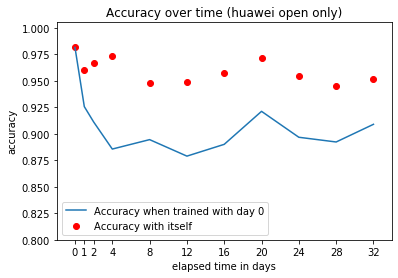

In [19]:
steps = [0, 1, 2, 4, 8, 12, 16, 20, 24, 28, 32]

plt.plot(steps, cumul_acc_avg, label="Accuracy when trained with day 0")
plt.scatter(steps, self_acc_avg, color="r", label="Accuracy with itself")
plt.ylim([0.8, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time (huawei open only)")
plt.savefig("Accuracy_over_time_08to1_train_only0_bis", dpi= 80)


In [11]:

DATA_PATH_REF_1 = ["data/huawei/open-6/"] #, "./data/huawei/Shazam_openFound/",  "data/huawei/DCLM_openError/"]
DATA_PATH_REF_2 = ["data/huawei/elapsed-time/open-7/"]
DATA_PATH_REF_3 = ["data/huawei/elapsed-time/open-8/"]
DATA_PATH_REF = DATA_PATH_REF_1 + DATA_PATH_REF_3 + DATA_PATH_REF_3
DISCARDED_ACTION = ['Calm_open', 'AppInTheAir_open', 'Fit_open', 'FitBreathe_open', "FitWorkout_open", 'Qardio_open']

cumul_acc_mix = []
cumul_true_mix = []
cumul_pred_mix = []
self_acc_mix = []


X_past_1, y_past_1, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=4, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)
X_past_2, y_past_2, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=3, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)
X_past_3, y_past_3, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=3, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)

X_past = X_past_1 + X_past_2 + X_past_3
y_past = y_past_1 + y_past_2 + y_past_3

X_past = np.array(X_past) 
X_past = X_past.tolist()
clf=RandomForestClassifier(n_estimators=200, random_state=None)
clf.fit(X_past, y_past)


steps = [4, 8, 12, 16, 20, 24, 28, 32]
repeat = 10

for _ in range(repeat):
    y_true, y_pred = evaluate(DATA_PATH_REF, RETURN_PRED=True, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=10, EQUALIZATION=False, PRINT_COUNT=False, N_ESTIMATOR=200)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    cumul_acc_mix.append(accuracy)
    self_acc_mix.append(accuracy)

for i, step in zip(range(9, 17), steps):
    DATA_PATH_NEW = ["data/huawei/elapsed-time/open-"+str(i)+"/"] # all
    print("day elapsed: ", step)
    for _ in range(repeat):
        X_new, y_new, _ = evaluate(DATA_PATH_NEW, DISCARDED_ACTION=DISCARDED_ACTION, PRINT_COUNT=False, EQUALIZATION=False, DATA_SIZE_FILTER=3, RETURN_FEATURES_AND_LABELS=True)
        X_new = np.array(X_new) 
        X_new = X_new.tolist()


        y_new_pred = clf.predict(X_new)
        accuracy = metrics.accuracy_score(y_new, y_new_pred)
        print("accuracy = ", accuracy)
        title = "Huawei train open 6 test open {}".format(i)
        # _ = plot_confusion_matrix(y_new, y_new_pred, title= title, figname = title.replace(" ", "_"), PLOT_DIR="./plots/")

        cumul_acc_mix.append(accuracy)
        cumul_true_mix.append(y_new)
        cumul_pred_mix.append(y_new_pred)

        # Self accuracy 
        acc, conf = evaluate(DATA_PATH_NEW, DISCARDED_ACTION=DISCARDED_ACTION, PRINT_COUNT=False, N_SPLITS=5, EQUALIZATION=False, DATA_SIZE_FILTER=10, N_ESTIMATOR=200, RETURN_ACC_AND_CONF=True)
        self_acc_mix.append(acc)
        print("Self acc = {}, conf = {}".format(acc, conf))
        print()
    

day elapsed:  4
accuracy =  0.9444444444444444
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
Self acc = 0.9760000000000002, conf = 0.010666666666666647

accuracy =  0.9666666666666667
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
Self acc = 0.9786666666666667, conf = 0.03200000000000004

accuracy =  0.9555555555555556
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
Self acc = 0.9733333333333333, conf = 0.029211869733608883

accuracy =  0.9333333333333333
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
Self acc = 0.9733333333333334, conf = 0.016865480854231396

accuracy =  0.9666666666666667
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
Self acc = 0.9733333333333333, conf = 0.03771236166328256

accuracy =  0.9222222222222223
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
Self acc = 0.9813333333333333, conf = 0.021333333333333385

accuracy =  0.9333333333333333
N

accuracy =  0.9444444444444444
Self acc = 0.9493333333333333, conf = 0.05438954147832304

accuracy =  0.9555555555555556
Self acc = 0.944, conf = 0.042666666666666644

accuracy =  0.9666666666666667
Self acc = 0.952, conf = 0.04332820482472512



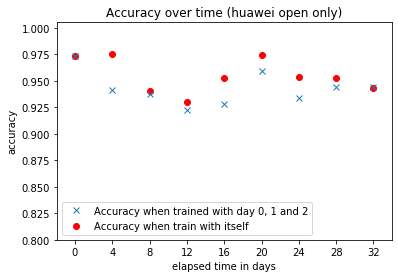

In [16]:
cumul_acc_avg_mix = np.array(cumul_acc_mix).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg_mix = np.array(self_acc_mix).reshape((-1,repeat)).mean(axis = 1)

steps = [0, 4, 8, 12, 16, 20, 24, 28, 32]

plt.plot(steps, cumul_acc_avg_mix, 'x', label="Accuracy when trained with day 0, 1 and 2")
plt.scatter(steps, self_acc_avg_mix, color="r", label="Accuracy when train with itself")
plt.ylim([0.8, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time (huawei open only)")
plt.savefig("Accuracy_over_time_08to1_mix", dpi= 80)


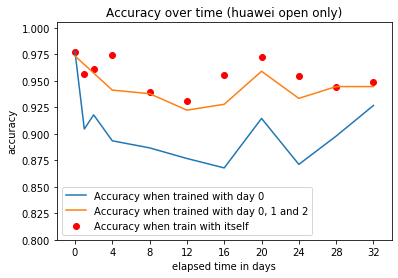

In [13]:
cumul_acc_avg_mix = np.array(cumul_acc_mix).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg_mix = np.array(self_acc_mix).reshape((-1,repeat)).mean(axis = 1)

steps = [0, 4, 8, 12, 16, 20, 24, 28, 32]
steps_all = [0, 1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
plt.plot(steps_all, cumul_acc_avg, label="Accuracy when trained with day 0")
plt.plot(steps, cumul_acc_avg_mix, label="Accuracy when trained with day 0, 1 and 2")
plt.scatter(steps_all, self_acc_avg, color="r", label="Accuracy when train with itself")
plt.ylim([0.8, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time (huawei open only)")
plt.savefig("Accuracy_over_time_08to1_all_bis", dpi= 80)


In [7]:
DISCARDED_ACTION = ['Calm_open', 'AppInTheAir_open', 'Fit_open', 'FitBreathe_open', "FitWorkout_open", 'Qardio_open']


DATA_PATH_REF_1 = ["data/huawei/open-6/"] #, "./data/huawei/Shazam_openFound/",  "data/huawei/DCLM_openError/"]
DATA_PATH_REF_2 = ["data/huawei/elapsed-time/open-7/"]
DATA_PATH_REF_3 = ["data/huawei/elapsed-time/open-8/"]
DATA_PATH_REF_MIX = DATA_PATH_REF_1 + DATA_PATH_REF_3 + DATA_PATH_REF_3

DATA_PATH_REF = DATA_PATH_REF_1

self_acc = []

cumul_acc = []
cumul_pred = []


cumul_acc_mix = []
cumul_pred_mix = []

cumul_true = []



mergred_until_day = 2

steps = [0, 1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
repeat = 15


for i, step in zip(range(6, 17), steps):
    DATA_PATH_NEW = ["data/huawei/elapsed-time/open-"+str(i)+"/"] # all
    print("day elapsed: ", step)
    for _ in range(repeat):
        
        # Import test data
        X_new, y_new, _ = evaluate(DATA_PATH_NEW, DISCARDED_ACTION=DISCARDED_ACTION, PRINT_COUNT=False, EQUALIZATION=False, DATA_SIZE_FILTER=2, RETURN_FEATURES_AND_LABELS=True)
        cumul_true.append(y_new)
        
        # Self accuracy 
        acc, _ = evaluate(DATA_PATH_NEW, RATIO=0.2, DISCARDED_ACTION=DISCARDED_ACTION, PRINT_COUNT=False, N_SPLITS=1, EQUALIZATION=False, DATA_SIZE_FILTER=10, N_ESTIMATOR=200, RETURN_ACC_AND_CONF=True)
        self_acc.append(acc)

        # delayed accuracy
        X_past, y_past, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=8, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)
        clf=RandomForestClassifier(n_estimators=200, random_state=None)
        clf.fit(X_past, y_past)
        y_new_pred = clf.predict(X_new)
        accuracy = metrics.accuracy_score(y_new, y_new_pred)
        cumul_acc.append(accuracy)
        cumul_pred.append(y_new_pred)
        

        X_past_1, y_past_1, _ = evaluate(DATA_PATH_REF_1, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=3, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)
        X_past_2, y_past_2, _ = evaluate(DATA_PATH_REF_2, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=3, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)
        X_past_3, y_past_3, _ = evaluate(DATA_PATH_REF_3, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=2, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)
        X_past_mix, y_past_mix = X_past_1 + X_past_2 + X_past_3, y_past_1 + y_past_2 + y_past_3
        
        clf_mix = RandomForestClassifier(n_estimators=200, random_state=None)
        clf_mix.fit(X_past_mix, y_past_mix)
        y_new_pred_mix = clf_mix.predict(X_new)        
        accuracy_mix = metrics.accuracy_score(y_new, y_new_pred_mix)
        
        cumul_acc_mix.append(accuracy_mix)
        cumul_pred_mix.append(y_new_pred_mix)

    

day elapsed:  0
day elapsed:  1
day elapsed:  2
day elapsed:  4
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobilis_open  instead
N_TO_PICK too large. Took all the dataset for Mobili

Software update in the middle (around day 16

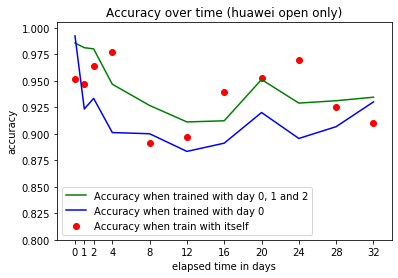

In [8]:
cumul_acc_avg_mix = np.array(cumul_acc_mix).reshape((-1,repeat)).mean(axis = 1)
cumul_acc_avg = np.array(cumul_acc).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg = np.array(self_acc).reshape((-1,repeat)).mean(axis = 1)


fig, ax = plt.subplots()


ax.plot(steps, cumul_acc_avg_mix, 'g', label="Accuracy when trained with day 0, 1 and 2")
ax.plot(steps, cumul_acc_avg, 'b', label="Accuracy when trained with day 0")
ax.scatter(steps, self_acc_avg, color="r", label="Accuracy when train with itself")
plt.ylim(0.8, 1.005)
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time (huawei open only)")
plt.savefig("Accuracy_over_time_08to1_mix_TEST", dpi= 80)


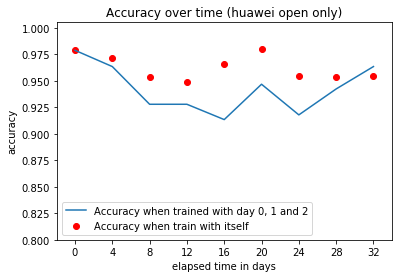

In [22]:
cumul_acc_avg_mix = np.array(cumul_acc_mix).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg_mix = np.array(self_acc_mix).reshape((-1,repeat)).mean(axis = 1)

steps = [0, 4, 8, 12, 16, 20, 24, 28, 32]

plt.plot(steps, cumul_acc_avg_mix, label="Accuracy when trained with day 0, 1 and 2")
plt.scatter(steps, self_acc_avg_mix, color="r", label="Accuracy when train with itself")
plt.ylim([0.8, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time (huawei open only)")
plt.savefig("Accuracy_over_time_08to1_mix", dpi= 80)


In [17]:
cumul_true_mix_flat = [t for ts in cumul_true_mix for t in ts]
cumul_pred_mix_flat = [t for ts in cumul_pred_mix for t in ts]
cumul_true_flat = [t for ts in cumul_true for t in ts]
cumul_pred_flat = [t for ts in cumul_pred for t in ts]

In [18]:
cumul_pred_mix_flat

['Bring_open',
 'Bring_open',
 'Bring_open',
 'ChinaDaily_open',
 'ChinaDaily_open',
 'ChinaDaily_open',
 'Citymapper_open',
 'Citymapper_open',
 'Citymapper_open',
 'DCLMRadio_open',
 'DCLMRadio_open',
 'FindMyPhone_open',
 'DiabetesM_open',
 'DiabetesM_open',
 'DiabetesM_open',
 'Endomondo_open',
 'Endomondo_open',
 'Endomondo_open',
 'FITIVPlus_open',
 'FITIVPlus_open',
 'FITIVPlus_open',
 'FindMyPhone_open',
 'FindMyPhone_open',
 'FindMyPhone_open',
 'FoursquareCityGuide_open',
 'FoursquareCityGuide_open',
 'FoursquareCityGuide_open',
 'Glide_open',
 'Glide_open',
 'Glide_open',
 'KeepNotes_open',
 'KeepNotes_open',
 'KeepNotes_open',
 'Krone_open',
 'Krone_open',
 'Krone_open',
 'Lifesum_open',
 'Lifesum_open',
 'Lifesum_open',
 'MapMyRun_open',
 'MapMyRun_open',
 'MapMyRun_open',
 'Maps_open',
 'Maps_open',
 'Maps_open',
 'Meduza_open',
 'Meduza_open',
 'Meduza_open',
 'Mobilis_open',
 'Mobilis_open',
 'WashPost_open',
 'Outlook_open',
 'Outlook_open',
 'Outlook_open',
 'PlayStor

Saved image ./plots/Huawei_train_open_6_test_open_16.png


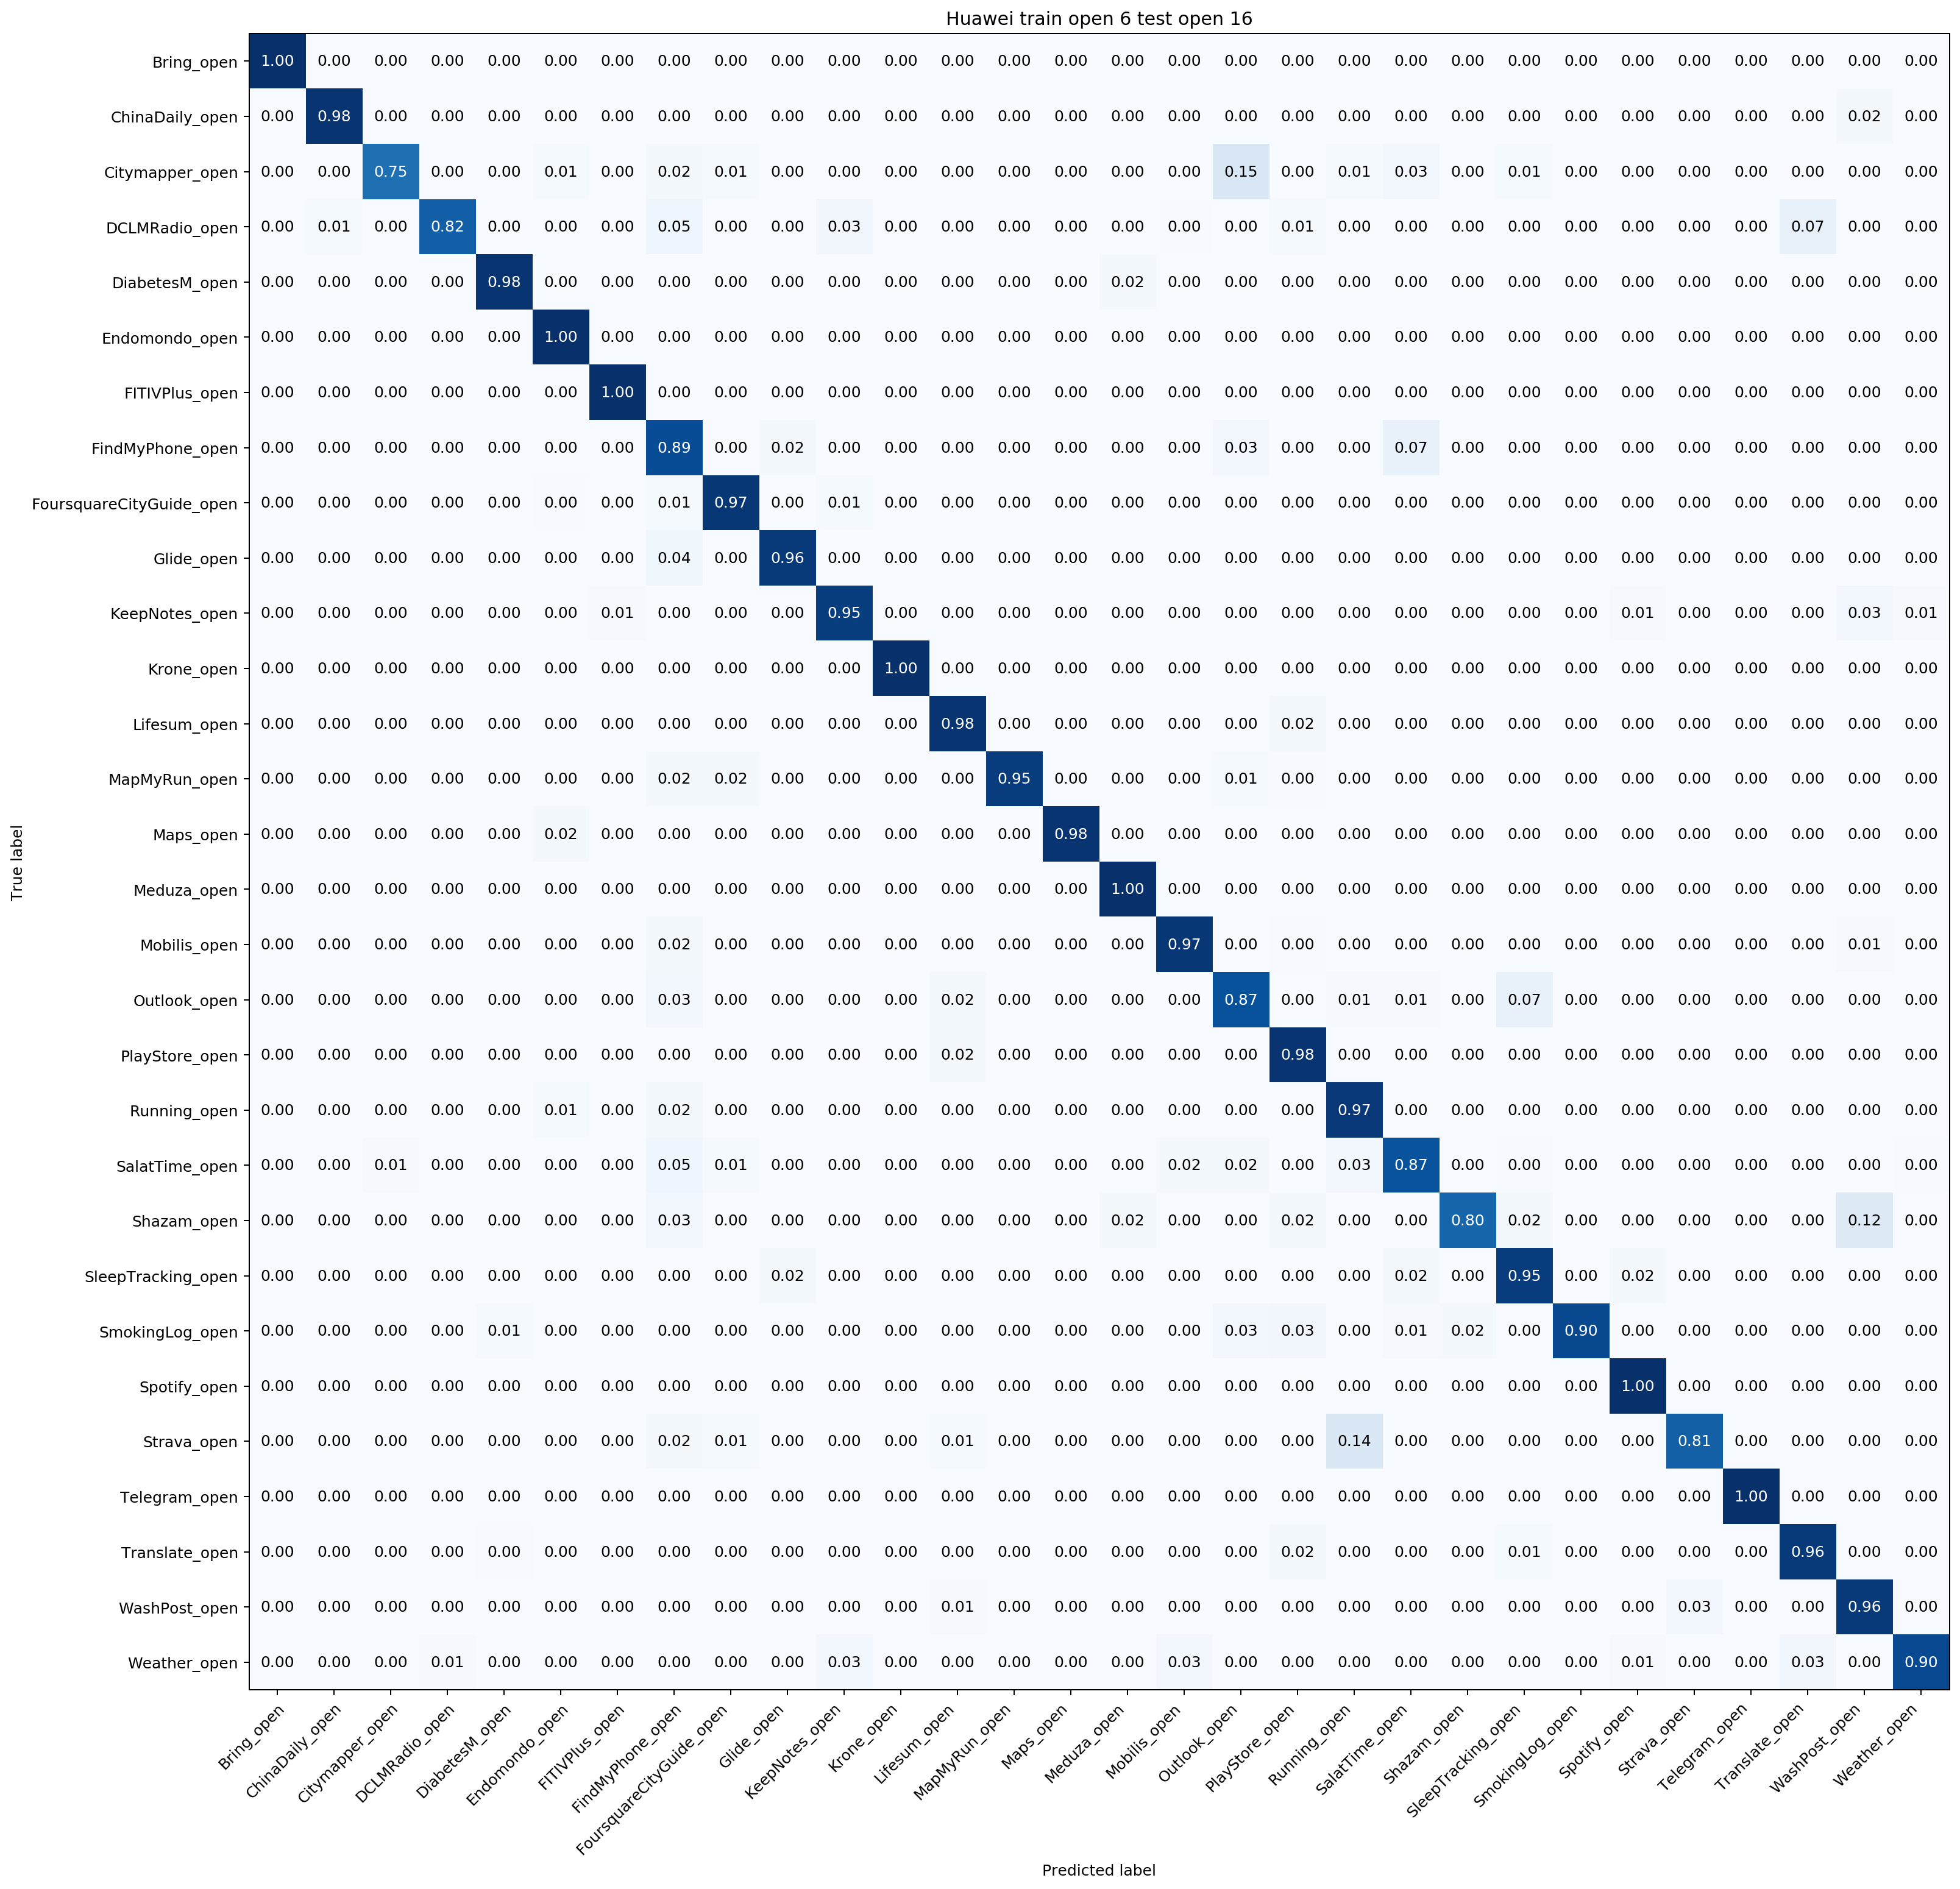

In [19]:
cm_mix, a2, a3 = plot_confusion_matrix(cumul_true_mix_flat, cumul_pred_mix_flat, title= title, figname = title.replace(" ", "_"), PLOT_DIR="./plots/")

Saved image ./plots/Huawei_train_open_6_test_open_16.png


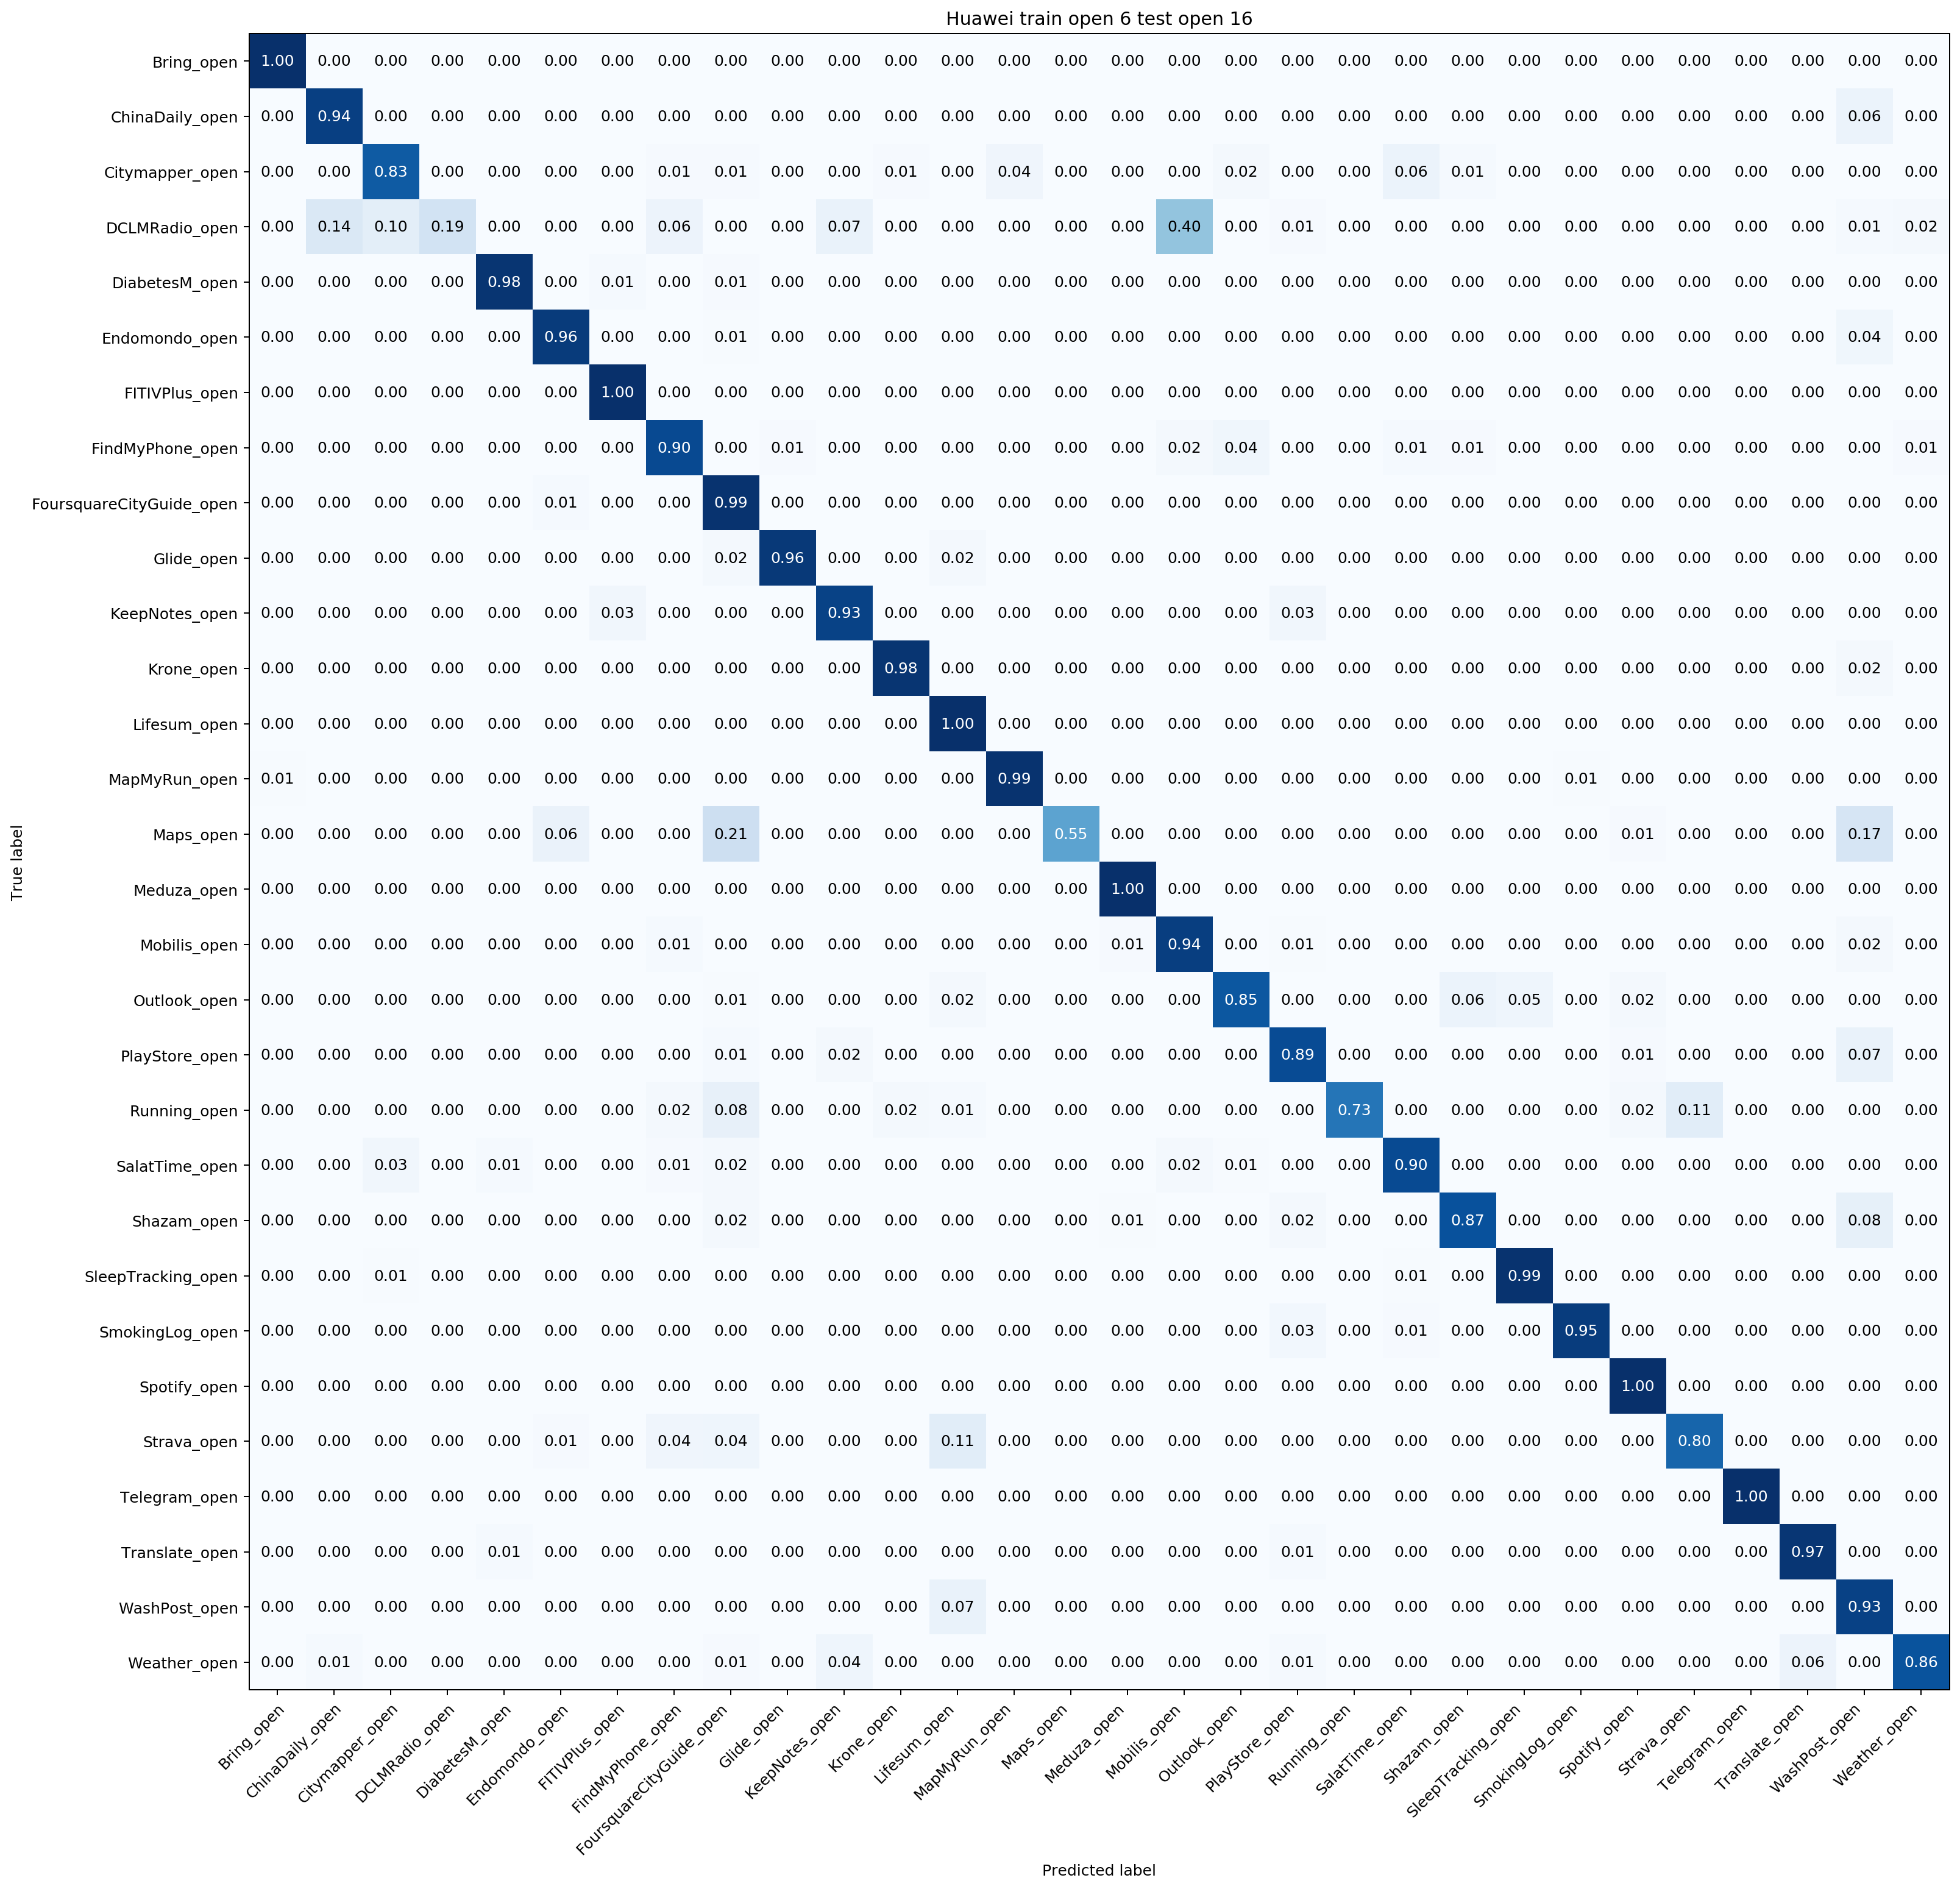

In [20]:
cm, _, _ = plot_confusion_matrix(cumul_true_flat, cumul_pred_flat, title= title, figname = title.replace(" ", "_"), PLOT_DIR="./plots/")

In [21]:
acc_diff = np.array([])
for x in range(len(cm)):
    acc_diff = np.append(acc_diff, cm_mix[x,x] - cm[x,x])

In [22]:
clf.classes_

array(['Bring_open', 'ChinaDaily_open', 'Citymapper_open',
       'DCLMRadio_open', 'DiabetesM_open', 'Endomondo_open',
       'FITIVPlus_open', 'FindMyPhone_open', 'FoursquareCityGuide_open',
       'Glide_open', 'KeepNotes_open', 'Krone_open', 'Lifesum_open',
       'MapMyRun_open', 'Maps_open', 'Meduza_open', 'Mobilis_open',
       'Outlook_open', 'PlayStore_open', 'Running_open', 'SalatTime_open',
       'Shazam_open', 'SleepTracking_open', 'SmokingLog_open',
       'Spotify_open', 'Strava_open', 'Telegram_open', 'Translate_open',
       'WashPost_open', 'Weather_open'], dtype='<U24')

In [23]:
print("%.2f increased on averaged" % (acc_diff.mean() * 100))

print(np.mean(acc_diff[np.where(acc_diff<0)]))
print(np.mean(acc_diff[np.where(acc_diff>0)]))

clf.classes_[np.where(acc_diff<0)]

4.31 increased on averaged
-0.03295454545454548
0.11821428571428573


array(['Citymapper_open', 'FindMyPhone_open', 'FoursquareCityGuide_open',
       'Glide_open', 'Lifesum_open', 'MapMyRun_open', 'SalatTime_open',
       'Shazam_open', 'SleepTracking_open', 'SmokingLog_open',
       'Translate_open'], dtype='<U24')

In [47]:
clf.classes_[np.where(acc_diff>0.1)]

array(['DCLMRadio_open', 'Maps_open', 'Running_open'], dtype='<U24')

In [28]:
acc_diff

array([ 0.        ,  0.04333333, -0.07916667,  0.63      ,  0.00666667,
        0.04333333,  0.        , -0.0125    , -0.01583333, -0.00083333,
        0.01916667,  0.02333333, -0.01666667, -0.03666667,  0.43666667,
        0.        ,  0.0275    ,  0.02083333,  0.08583333,  0.23333333,
       -0.03      , -0.0775    , -0.03666667, -0.04583333,  0.        ,
        0.01583333,  0.        , -0.01083333,  0.0325    ,  0.03666667])

In [41]:
sorted_indice = np.argsort(acc_diff)
sorted_class = clf.classes_[sorted_indice]
acc_diff_sorted = acc_diff[sorted_indice]
first_0 = np.where(acc_diff_sorted == 0)[0][0]

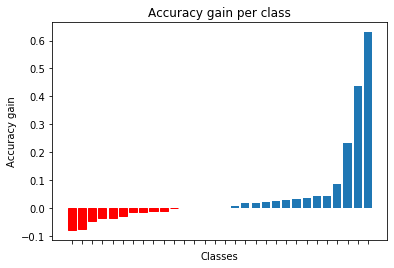

In [46]:

barlist = plt.bar(x = np.arange(len(acc_diff)), height = acc_diff_sorted, tick_label = "")
[barlist[i].set_color('r') for i in range(first_0)]
plt.xlabel("Classes")
plt.ylabel("Accuracy gain")
#plt.ylim([])
plt.title("Accuracy gain per class")
plt.xticks(ticks=None)
plt.savefig("accuracy_gain_per_class_when_mix_trained", dpi=80)
plt.show()


Hey, I found that when training with old huawei capture and test with new huawei capture I had  approximatively  results with the Fosill

(67% than with it's . So I investigate and found that some applications ). Example: Spotify was not paired. Apps are buggy in one watch but not in the other AppInTheAir, Apps requiring location on Fossil does not work. Apps that requires location does not work well on Nexus (sometimes it does that's why I am also confused). Also the settings I had to 

To confirm that: 

Improve previous results by capture both when location not found and location found. **Making the model more general by also including data when location is disabled**


Improve FN rate by adding a class missclassifed after having predicted the label. The criteria to put a label in the nocallfound class will be if the classifier has >50% confidence about this particular sample

##### Becarefull with outlook could not login on nexus

##  For Long-run Classifing NoApp_NoAction

In [ ]:
def cut_all_datasets_in_events(sources_files, timeout=-1):
    """
    Returns a map[device][app][action] => list[[(time, size)],] where list is cut by events
    Second return value is the same structure, but with # of packets instead of events

    also return map[device][app][action] => list[[event_id] used latter to track
    the missclassified events
    """
    events = dict()
    events_id = dict()
    counts = dict()

    # cut each file in events
    for s in sources_files:
        fname = filter_out_path(s)
        parts = fname.split("_")
        device, app, action, event_id = parts[0], parts[1], parts[2], parts[3]

        if not device in events:
            events[device] = dict()
        if not app in events[device]:
            events[device][app] = dict()
        if not action in events[device][app]:
            events[device][app][action] = []

        file_events = dataset_file_to_xy_events(s, timeout=timeout) # cut each trace into subtraces after 4.5 idle time

        event_index = 0
        for event in file_events:
            n_packets = len(event['xs'])
            if n_packets == 0:
                #print("Skipping", s, " (",device,app,action,") event",event_index, "as it has 0 packets")
                pass
            else:
                events[device][app][action].append(event)

            event_index += 1

    return events, counts


def cut_all_datasets_in_event(sources_files, timeout=-1):
    """
    Returns a map[device][app][action][event] => (time, size) where list is cut by events
    Second return value is the same structure, but with # of packets instead of events
    """
    events = dict()
    counts = dict()

    # cut each file in events
    for s in sources_files:
        fname = filter_out_path(s)
        parts = fname.split("_")
        device, app, action = parts[0], parts[1], parts[2]
        event_nb = parts[5][: parts[5].find(".")]

        if not device in events:
            events[device] = dict()
        if not app in events[device]:
            events[device][app] = dict()
        if not action in events[device][app]:
            events[device][app][action] = dict()

        file_events = dataset_file_to_xy_events(s, timeout=timeout) # cut each trace into subtraces after 4.5 idle time

        event_index = 0
        for event in file_events:
            n_packets = len(event['xs'])
            if n_packets == 0:
                #print("Skipping", s, " (",device,app,action,") event",event_index, "as it has 0 packets")
                pass
            else:
                events[device][app][action][event_nb] = event

            event_index += 1

    return events, counts

In [ ]:
f_s = find_sources("./data/huawei/NoApp_NoAction-2/")

e, _ =cut_all_datasets_in_event(f_s)

In [ ]:
ises = []
for w in e:
    for ap in e[w]:
        for ac in e[w][ap]:
            for i in e[w][ap][ac]:
                ys = e[w][ap][ac][i]['ys']
                t_traf = np.sum(np.abs(np.array(ys)))
                if t_traf > 200:
                    print("i {}: t_traf= {}".format(i,t_traf))
                    ises.append(i)
                    
print(ises)


<a id='apple-huawei'></a>
### Transferability iwatch - huawei
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/iwatch/batch-1/","data/huawei/elapsed-time/open-13/"]
equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, TO_MERGE=TO_MERGED, MERGED_NAMES=Names, EQUALIZATION=True, RETURN_EQUILIBRATE_EVENTS=True, PRINT_COUNT=True)


equilibrate_events_huawei = dict()
equilibrate_events_iwatch = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_iwatch["AppleWatch"] = equilibrate_events["AppleWatch"]

print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)


print("building and training a model for confusion matrix")
X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei)
clf.fit(X_huawei, y_huawei)
X_iwatch, y_iwatch, _ = build_features_labels_dataset(equilibrate_events_iwatch)


y_iwatch_pred = clf.predict(X_iwatch)
accuracy = metrics.accuracy_score(y_iwatch, y_iwatch_pred)
print("accuracy = ", accuracy)



title = "Confusion_matrix_train_with_Fossil_test_with_Huawei(overtime)_acc={:0.2f}".format(accuracy * 100)
saved_title = title.replace(".", "_").replace(" ", "_")
_ = plot_confusion_matrix(y_iwatch, y_iwatch_pred, title= title, figname = saved_title, CM_NO_LABELS=True)
